In [2]:
# all modules necessary for this nb
import os
import sys
import pickle

import numpy as np
import pylab as pl
import scipy.stats as sstats

# setting parameters for default matplotlib plots
%matplotlib inline

In [3]:
pl.style.use('fabiostyle')
# needs to find the library of functions
sys.path.append('../../code/')  # to be replaced!

import utils as ut
import plots as pt

In [4]:
# %%javascript
# var nb = IPython.notebook;
# var kernel = IPython.notebook.kernel;
# var command = "NOTEBOOK_NAME = '" + nb.base_url + nb.notebook_path + "'";
# kernel.execute(command);

In [5]:
# NOTEBOOK_NAME = NOTEBOOK_NAME.split('/')[-1][:-6]
NOTEBOOK_NAME = 'decoding_around_onset_combined_dhpc'

In [6]:
from pickleshare import PickleShareDB

autorestore_folder = os.path.join(os.getcwd(), 'autorestore', NOTEBOOK_NAME)
db = PickleShareDB(autorestore_folder)
import sys
from workspace import *
import IPython
ip = IPython.get_ipython()

# this will restore all the saved variables. ignore the errors listed.
load_workspace(ip, db)

# use `save_worspace(db)` to save variables at the end

Unable to restore variable 'add_significance', ignoring (use %store -d to forget!)
('The error was:', <type 'exceptions.KeyError'>)
Unable to restore variable 'combine_train_test_patterns', ignoring (use %store -d to forget!)
('The error was:', <type 'exceptions.KeyError'>)
Unable to restore variable 'combine_train_test_patterns_across_tbs', ignoring (use %store -d to forget!)
('The error was:', <type 'exceptions.KeyError'>)
Unable to restore variable 'load_all_animals_vars', ignoring (use %store -d to forget!)
('The error was:', <type 'exceptions.KeyError'>)
Unable to restore variable 'load_cellreg', ignoring (use %store -d to forget!)
('The error was:', <type 'exceptions.KeyError'>)
Unable to restore variable 'do_decoding_combined_within', ignoring (use %store -d to forget!)
('The error was:', <type 'exceptions.KeyError'>)
Unable to restore variable 'do_test_across_tbs', ignoring (use %store -d to forget!)
('The error was:', <type 'exceptions.KeyError'>)
Unable to restore variable 'd

In [7]:
from itertools import product
def load_all_animals_vars(varname, animal_list, pilot_list=None, notebook='preprocessing'):
    all_of_them = {}
    for ani in animal_list:
        folder = '../%s/notebooks/autorestore/%s/' % (ani, notebook)
        all_of_them.update({ani: ut.load_variable(varname, folder)})
    return all_of_them

In [89]:
expo_animals = 'dhpcg20','dhpc35','dhpc36'
pre_animals =  'dhpcg20','dhpc35','dhpc36'
post_animals = 'dhpcg20','dhpc35','dhpc36','dhpc35_254'

In [90]:
sessions = 'expo', 'pre', 'post'

In [91]:
for sess in 'pre', 'post':

    exec("patterns_tb_%s = dict(zip(%s_animals, [ut.load_variable('patterns_tb',\
                                                           '../%%s/%s/notebooks/autorestore/decoding_around_onset/'%%ani)\
                                                  for ani in %s_animals]))"%(sess, sess, sess, sess))
    exec("labels_%s = dict(zip(%s_animals, [ut.load_variable('labels',\
                                                         '../%%s/%s/notebooks/autorestore/decoding_around_onset/'%%ani)\
                                                  for ani in %s_animals]))"%(sess, sess, sess, sess))

In [10]:
#have to extract 4_odor_expo varibles differently from that used above
patterns_tb_expo = dict(zip(expo_animals,
                                [ut.load_variable('patterns_tb','../%s/4_odor_expo/notebooks/autorestore/decoding_around_onset'%ani)
                                                  for ani in expo_animals]))

labels_expo = dict(zip(expo_animals,
                                [ut.load_variable('labels','../%s/4_odor_expo/notebooks/autorestore/decoding_around_onset'%ani)
                                                  for ani in expo_animals]))

In [11]:
delta_t0 = 1

t_start0 = -5  # sec
t_stop0 = 9  # sec

In [12]:
import h5py

def do_decoding_combined_within(patterns, labels, n_loops=10, ncells=None, cellreg=False, n_steps=15, **args):
     
    scores = np.r_[[do_test_within(patterns, labels, **args) for i in range(n_loops)]]
    
    if ncells is None:
        total_n = np.sum([patterns[ani].shape[1] for ani in patterns.keys()])
        ncells = np.repeat(np.r_[np.linspace(5, total_n, n_steps).astype(int)], 5)
        
    scores_ncells = np.r_[[do_test_within(patterns, labels, n_cells=n, **args) 
                                        for n in ncells]]
    
    return scores, ncells, scores_ncells


from sklearn.model_selection import KFold, LeaveOneOut
from sklearn.svm import SVC

def combine_train_test_patterns(patterns, labels, train_test_split=0.5, classes=None, n_cells=None,
                                relabel=None, relabel_test=None):

    if classes is None:
        classes = [0, 1]

    which_train = {}
    which_test = {}
    for ani in patterns.keys():
        which_trains = []
        which_tests = []
        for l in classes:
            if l>=0:
                wt = np.random.permutation(np.where(labels[ani]==l)[0])
                if train_test_split<1:
                    wT = wt[:int(len(wt)*train_test_split)]
                    which_trains.append(wt[int(len(wt)*train_test_split):])
                    which_tests.append(wT)
                else:
                    which_trains.append(wt)
        which_train[ani] = np.concatenate(which_trains)
        if train_test_split<1:
            which_test[ani] = np.concatenate(which_tests)
    
    patterns_t = patterns.copy()
    labels_t = labels.copy()
    for ani in patterns.keys():
        patterns_t[ani] = patterns[ani][which_train[ani]]
        labels_t[ani] = labels[ani][which_train[ani]]
    patterns_comb_train, labels_comb_ = ut.combine_patterns(patterns_t, labels_t, classes=classes)
        
    if train_test_split<1:
        patterns_T = patterns.copy()
        labels_T = labels.copy()
        for ani in patterns.keys():
            patterns_T[ani] = patterns[ani][which_test[ani]]
            labels_T[ani] = labels[ani][which_test[ani]]
        patterns_comb_test, labels_comb_test_ = ut.combine_patterns(patterns_T, labels_T, classes=classes)
    else:
        patterns_comb_test = None
    
    if relabel is not None:
        labels_comb = np.r_[[relabel[l] for l in labels_comb_]]
    else:
        labels_comb = labels_comb_
    
    if train_test_split<1:
        if relabel_test is not None:
            labels_comb_test = np.r_[[relabel_test[l] for l in labels_comb_test_]]
        else:
            if relabel is not None:
                labels_comb_test = np.r_[[relabel[l] for l in labels_comb_test_]]
            else:
                labels_comb_test = labels_comb_test_
    elif train_test_split == 1:
        labels_comb_test = None
    
    
    if n_cells is None:
        which_cells = [True]*patterns_comb_train.shape[1]
    else:
        which_cells = np.random.permutation(range(patterns_comb_train.shape[1]))[:n_cells]
     
    patterns_comb_train = patterns_comb_train[:, which_cells]
    patterns_comb_test = patterns_comb_test[:, which_cells] if train_test_split<1 else patterns_comb_test
    
    if train_test_split<1:
        return (patterns_comb_train[labels_comb>=0], labels_comb[labels_comb>=0],
                patterns_comb_test[labels_comb_test>=0], labels_comb_test[labels_comb_test>=0])
    if train_test_split == 1:
        return (patterns_comb_train[labels_comb>=0], labels_comb[labels_comb>=0],
                None,None)

def do_test_within(patterns, labels, **args):
    x, y, xT, yT = combine_train_test_patterns(patterns, labels, **args)
    decoder.fit(x, y)
    return decoder.score(xT, yT)
        
def load_cellreg(animal, filename='pre_vs_post.mat', keys=['pre', 'post']):
    with h5py.File('../%s/data/%s'%(animal, filename), 'r') as f:
        g = np.r_[f['cell_registered_struct']['cell_to_index_map']]
        cellreg_dict = {k:g[i][np.where(np.prod([gg>0 for gg in g], 0))[0]].astype(int)-1
                        for i, k in enumerate(keys)}
    return cellreg_dict

In [13]:
from sklearn.model_selection import KFold, LeaveOneOut
from sklearn.svm import SVC

def do_test_within_beta(patterns_train,patterns_test, labels_train, labels_test, relabel=None, n_cells=None):
    
    if relabel is not None:
        labels_train = np.r_[[relabel[l] for l in labels_train]]
        labels_test = np.r_[[relabel[l] for l in labels_test]]
    else:
        labels_train = labels_train
        labels_test = labels_test
    
    if n_cells is None:
        cells = list(range(patterns_train.shape[1]))
    else:
        cells = np.random.choice(range(patterns_train.shape[1]), size=n_cells, replace=False)
    
    decoder.fit(patterns_train[:, cells], labels_train)
    scores = decoder.score(patterns_test[:, cells], labels_test)
    decoder.fit(patterns_test[:, cells], labels_test)
    return np.append(scores, decoder.score(patterns_train[:, cells], labels_train))

In [14]:
from matplotlib.lines import Line2D
def add_significance(ax, array1, array2, x1, x2, y, ticksize=0.02, sig_func=None, thresholds=(0.05, 0.01, 0.001)):
    if sig_func is None:
        sig_func = lambda x, y: sstats.mannwhitneyu(x, y, alternative='two-sided')
    p = sig_func(array1, array2)[-1]
    sig_value = sig_func(array1, array2)[0]
    deltay = np.diff(ax.axis()[-2:])*ticksize
    line = Line2D([x1, x1, x2, x2], [y-deltay, y, y, y-deltay], lw=.5, color='k', clip_on=False)
    ax.add_line(line)
    ax.text(np.mean([x1, x2]), y+1,
            'n.s.' if p>thresholds[0] else
            '*' if p>thresholds[1] else
            '**' if p>thresholds[2] else
            '***',
            ha='center', fontsize=4)
    return sig_value, p

In [15]:
def sig_vs_chance(ax, array1, chance, x1, y1, loops=15, ticksize=0.02, sig_func=None, thresholds=(0.05, 0.01, 0.001),colors='k'):
    if sig_func is None:
        sig_func = lambda x: sstats.wilcoxon(x)
        subtracted = [x-chance for x in array1]
        p = sig_func(subtracted)[-1]
        sig_value = sig_func(subtracted)[0]
    elif sig_func is ttest:
        sig_func = lambda x, y: sstats.ttest_1samp(x,y)
        p = sig_func(array1,chance)[-1]
        sig_value = sig_func(array1,chance)[0]
    ax.text(x1, y1,
            'n.s.' if p>thresholds[0] else
            '*' if p>thresholds[1] else
            '**' if p>thresholds[2] else
            '***',
            ha='center', fontsize=4, color=colors)
    return sig_value, p

In [16]:
decoder = SVC(kernel='linear', decision_function_shape='ovo')

In [92]:
for sess in sessions:
    for t in range(14):
        exec('patterns_tb_%s_%s = {}'%(t, sess))
        for ani in eval('%s_animals'%sess):
            try:
                print sess,
                print ani,
                exec("patterns_tb_%s_%s['%s'] = patterns_tb_%s['%s'][%s]"%(t,sess,ani,sess,ani,t))
            except IOError as error:
                print error
            continue

expo dhpcg20 expo dhpc35 expo dhpc36 expo dhpcg20 expo dhpc35 expo dhpc36 expo dhpcg20 expo dhpc35 expo dhpc36 expo dhpcg20 expo dhpc35 expo dhpc36 expo dhpcg20 expo dhpc35 expo dhpc36 expo dhpcg20 expo dhpc35 expo dhpc36 expo dhpcg20 expo dhpc35 expo dhpc36 expo dhpcg20 expo dhpc35 expo dhpc36 expo dhpcg20 expo dhpc35 expo dhpc36 expo dhpcg20 expo dhpc35 expo dhpc36 expo dhpcg20 expo dhpc35 expo dhpc36 expo dhpcg20 expo dhpc35 expo dhpc36 expo dhpcg20 expo dhpc35 expo dhpc36 expo dhpcg20 expo dhpc35 expo dhpc36 pre dhpcg20 pre dhpc35 pre dhpc36 pre dhpcg20 pre dhpc35 pre dhpc36 pre dhpcg20 pre dhpc35 pre dhpc36 pre dhpcg20 pre dhpc35 pre dhpc36 pre dhpcg20 pre dhpc35 pre dhpc36 pre dhpcg20 pre dhpc35 pre dhpc36 pre dhpcg20 pre dhpc35 pre dhpc36 pre dhpcg20 pre dhpc35 pre dhpc36 pre dhpcg20 pre dhpc35 pre dhpc36 pre dhpcg20 pre dhpc35 pre dhpc36 pre dhpcg20 pre dhpc35 pre dhpc36 pre dhpcg20 pre dhpc35 pre dhpc36 pre dhpcg20 pre dhpc35 pre dhpc36 pre dhpcg20 pre dhpc35 pre dhpc36 post d

In [93]:
%%time
for t in range(14): # number of time bins
    exec('scores_tb_%s_all = {}'%t)
    n_loops = 15
    for sess in sessions:
        print sess,
        print t,
        eval("scores_tb_%s_all"%t)[sess] = np.r_[[do_test_within(eval("patterns_tb_%s_%s"%(t,sess)),eval("labels_%s"%sess),
              classes=range(1,5), n_cells=None, relabel=None) for i in range(n_loops)]]

expo 0 pre 0 post 0 expo 1 pre 1 post 1 expo 2 pre 2 post 2 expo 3 pre 3 post 3 expo 4 pre 4 post 4 expo 5 pre 5 post 5 expo 6 pre 6 post 6 expo 7 pre 7 post 7 expo 8 pre 8 post 8 expo 9 pre 9 post 9 expo 10 pre 10 post 10 expo 11 pre 11 post 11 expo 12 pre 12 post 12 expo 13 pre 13 post 13CPU times: user 1min 3s, sys: 64 ms, total: 1min 3s
Wall time: 1min 2s



In [94]:
%%time
#get train and test subsamples for each timebin, for each session
relabel = {1:0,2:1,3:-1,4:-1}
n_loops=15
for t in range(14): # number of time bins
    exec('scores_tb_%s_CS1vsCS2 = {}'%t)
    for sess in sessions:
        print sess,
        print t,
        eval("scores_tb_%s_CS1vsCS2"%t)[sess] = np.r_[[do_test_within(eval("patterns_tb_%s_%s"%(t,sess)),eval("labels_%s"%sess),
              classes=range(1,5), n_cells=None, relabel=relabel) for i in range(n_loops)]]

expo 0 pre 0 post 0 expo 1 pre 1 post 1 expo 2 pre 2 post 2 expo 3 pre 3 post 3 expo 4 pre 4 post 4 expo 5 pre 5 post 5 expo 6 pre 6 post 6 expo 7 pre 7 post 7 expo 8 pre 8 post 8 expo 9 pre 9 post 9 expo 10 pre 10 post 10 expo 11 pre 11 post 11 expo 12 pre 12 post 12 expo 13 pre 13 post 13CPU times: user 27.2 s, sys: 64 ms, total: 27.3 s
Wall time: 27.2 s



In [95]:
%%time
relabel = {1:0,2:0,3:1,4:1}
for t in range(14): # number of time bins
    exec('scores_tb_%s_CSPvsCSM = {}'%t)
    n_loops = 15
    for sess in sessions:
        print sess,
        print t,
        eval("scores_tb_%s_CSPvsCSM"%t)[sess] = np.r_[[do_test_within(eval("patterns_tb_%s_%s"%(t,sess)),eval("labels_%s"%sess),
              classes=range(1,5), n_cells=None, relabel=relabel) for i in range(n_loops)]]

expo 0 pre 0 post 0 expo 1 pre 1 post 1 expo 2 pre 2 post 2 expo 3 pre 3 post 3 expo 4 pre 4 post 4 expo 5 pre 5 post 5 expo 6 pre 6 post 6 expo 7 pre 7 post 7 expo 8 pre 8 post 8 expo 9 pre 9 post 9 expo 10 pre 10 post 10 expo 11 pre 11 post 11 expo 12 pre 12 post 12 expo 13 pre 13 post 13CPU times: user 45 s, sys: 100 ms, total: 45.1 s
Wall time: 44.9 s



In [96]:
%%time
relabel = {1:0,2:-1,3:1,4:-1}
for t in range(14): # number of time bins
    exec('scores_tb_%s_CS1vsCS3 = {}'%t)
    n_loops = 15
    for sess in sessions:
        print sess,
        print t,
        eval("scores_tb_%s_CS1vsCS3"%t)[sess] = np.r_[[do_test_within(eval("patterns_tb_%s_%s"%(t,sess)),eval("labels_%s"%sess),
              classes=range(1,5), n_cells=None, relabel=relabel) for i in range(n_loops)]]

expo 0 pre 0 post 0 expo 1 pre 1 post 1 expo 2 pre 2 post 2 expo 3 pre 3 post 3 expo 4 pre 4 post 4 expo 5 pre 5 post 5 expo 6 pre 6 post 6 expo 7 pre 7 post 7 expo 8 pre 8 post 8 expo 9 pre 9 post 9 expo 10 pre 10 post 10 expo 11 pre 11 post 11 expo 12 pre 12 post 12 expo 13 pre 13 post 13CPU times: user 27.1 s, sys: 68 ms, total: 27.1 s
Wall time: 27 s



In [97]:
%%time
relabel = {1:0,2:-1,3:-1,4:1}
for t in range(14): # number of time bins
    exec('scores_tb_%s_CS1vsCS4 = {}'%t)
    n_loops = 15
    for sess in sessions:
        print sess,
        print t,
        eval("scores_tb_%s_CS1vsCS4"%t)[sess] = np.r_[[do_test_within(eval("patterns_tb_%s_%s"%(t,sess)),eval("labels_%s"%sess),
              classes=range(1,5), n_cells=None, relabel=relabel) for i in range(n_loops)]]

expo 0 pre 0 post 0 expo 1 pre 1 post 1 expo 2 pre 2 post 2 expo 3 pre 3 post 3 expo 4 pre 4 post 4 expo 5 pre 5 post 5 expo 6 pre 6 post 6 expo 7 pre 7 post 7 expo 8 pre 8 post 8 expo 9 pre 9 post 9 expo 10 pre 10 post 10 expo 11 pre 11 post 11 expo 12 pre 12 post 12 expo 13 pre 13 post 13CPU times: user 27.3 s, sys: 104 ms, total: 27.4 s
Wall time: 27.3 s



In [98]:
%%time
relabel = {1:-1,2:0,3:1,4:-1}
for t in range(14): # number of time bins
    exec('scores_tb_%s_CS2vsCS3 = {}'%t)
    n_loops = 15
    for sess in sessions:
        print sess,
        print t,
        eval("scores_tb_%s_CS2vsCS3"%t)[sess] = np.r_[[do_test_within(eval("patterns_tb_%s_%s"%(t,sess)),eval("labels_%s"%sess),
              classes=range(1,5), n_cells=None, relabel=relabel) for i in range(n_loops)]]

expo 0 pre 0 post 0 expo 1 pre 1 post 1 expo 2 pre 2 post 2 expo 3 pre 3 post 3 expo 4 pre 4 post 4 expo 5 pre 5 post 5 expo 6 pre 6 post 6 expo 7 pre 7 post 7 expo 8 pre 8 post 8 expo 9 pre 9 post 9 expo 10 pre 10 post 10 expo 11 pre 11 post 11 expo 12 pre 12 post 12 expo 13 pre 13 post 13CPU times: user 27.4 s, sys: 60 ms, total: 27.4 s
Wall time: 27.3 s



In [99]:
%%time
relabel = {1:-1,2:0,3:-1,4:1}
for t in range(14): # number of time bins
    exec('scores_tb_%s_CS2vsCS4 = {}'%t)
    n_loops = 15
    for sess in sessions:
        print sess,
        print t,
        eval("scores_tb_%s_CS2vsCS4"%t)[sess] = np.r_[[do_test_within(eval("patterns_tb_%s_%s"%(t,sess)),eval("labels_%s"%sess),
              classes=range(1,5), n_cells=None, relabel=relabel) for i in range(n_loops)]]

expo 0 pre 0 post 0 expo 1 pre 1 post 1 expo 2 pre 2 post 2 expo 3 pre 3 post 3 expo 4 pre 4 post 4 expo 5 pre 5 post 5 expo 6 pre 6 post 6 expo 7 pre 7 post 7 expo 8 pre 8 post 8 expo 9 pre 9 post 9 expo 10 pre 10 post 10 expo 11 pre 11 post 11 expo 12 pre 12 post 12 expo 13 pre 13 post 13CPU times: user 27.2 s, sys: 64 ms, total: 27.3 s
Wall time: 27.2 s



In [100]:
%%time
relabel = {1:-1,2:-1,3:0,4:1}
for t in range(14): # number of time bins
    exec('scores_tb_%s_CS3vsCS4 = {}'%t)
    n_loops = 15
    for sess in sessions:
        print sess,
        print t,
        eval("scores_tb_%s_CS3vsCS4"%t)[sess] = np.r_[[do_test_within(eval("patterns_tb_%s_%s"%(t,sess)),eval("labels_%s"%sess),
              classes=range(1,5), n_cells=None, relabel=relabel) for i in range(n_loops)]]

expo 0 pre 0 post 0 expo 1 pre 1 post 1 expo 2 pre 2 post 2 expo 3 pre 3 post 3 expo 4 pre 4 post 4 expo 5 pre 5 post 5 expo 6 pre 6 post 6 expo 7 pre 7 post 7 expo 8 pre 8 post 8 expo 9 pre 9 post 9 expo 10 pre 10 post 10 expo 11 pre 11 post 11 expo 12 pre 12 post 12 expo 13 pre 13 post 13CPU times: user 27.6 s, sys: 96 ms, total: 27.7 s
Wall time: 27.6 s



In [1]:
#for an alternative take on CS+ vs CS-, average each idividual comparison
for t in range(14):
    exec("scores_tb_%s_CSPvsCSM_averaged = {}"%t)
    for sess in sessions:
        exec("scores_tb_%s_CSPvsCSM_averaged[sess] = np.mean((scores_tb_%s_CS1vsCS3[sess],scores_tb_%s_CS1vsCS4[sess],\
              scores_tb_%s_CS2vsCS3[sess],scores_tb_%s_CS2vsCS4[sess]),axis=0)"%(t,t,t,t,t))

NameError: name 'sessions' is not defined

### now for decoding outcome (train on one set of CS+/CS- pairs, test using other set)

In [102]:
%%time
tt_relabels = [{1:0,2:-1,3:1,4:-1}, {1:0,2:-1,3:-1,4:1}, {1:-1,2:0,3:1,4:-1}, {1:-1,2:0,3:-1,4:1}]
tt_relabels_test = [{1:-1,2:0,3:-1,4:1}, {1:-1,2:0,3:1,4:-1}, {1:0,2:-1,3:-1,4:1}, {1:0,2:-1,3:1,4:-1}]
tt_pairs = ['tr13_ts24','tr14_ts23','tr23_ts14','tr24_ts13']
for t in range(14): # number of time bins
    for re, rete, it in zip(tt_relabels,tt_relabels_test,tt_pairs):
        exec('scores_tb_%s_outcome_%s = {}'%(t,it))
        n_loops = 15
        for sess in sessions:
            print sess,
            print t,
            eval("scores_tb_%s_outcome_%s"%(t,it))[sess] = np.r_[[do_test_within(eval("patterns_tb_%s_%s"%(t,sess)),eval("labels_%s"%sess),
                  classes=range(1,5), n_cells=None, relabel=re, relabel_test=rete) for i in range(n_loops)]]

expo 0 pre 0 post 0 expo 0 pre 0 post 0 expo 0 pre 0 post 0 expo 0 pre 0 post 0 expo 1 pre 1 post 1 expo 1 pre 1 post 1 expo 1 pre 1 post 1 expo 1 pre 1 post 1 expo 2 pre 2 post 2 expo 2 pre 2 post 2 expo 2 pre 2 post 2 expo 2 pre 2 post 2 expo 3 pre 3 post 3 expo 3 pre 3 post 3 expo 3 pre 3 post 3 expo 3 pre 3 post 3 expo 4 pre 4 post 4 expo 4 pre 4 post 4 expo 4 pre 4 post 4 expo 4 pre 4 post 4 expo 5 pre 5 post 5 expo 5 pre 5 post 5 expo 5 pre 5 post 5 expo 5 pre 5 post 5 expo 6 pre 6 post 6 expo 6 pre 6 post 6 expo 6 pre 6 post 6 expo 6 pre 6 post 6 expo 7 pre 7 post 7 expo 7 pre 7 post 7 expo 7 pre 7 post 7 expo 7 pre 7 post 7 expo 8 pre 8 post 8 expo 8 pre 8 post 8 expo 8 pre 8 post 8 expo 8 pre 8 post 8 expo 9 pre 9 post 9 expo 9 pre 9 post 9 expo 9 pre 9 post 9 expo 9 pre 9 post 9 expo 10 pre 10 post 10 expo 10 pre 10 post 10 expo 10 pre 10 post 10 expo 10 pre 10 post 10 expo 11 pre 11 post 11 expo 11 pre 11 post 11 expo 11 pre 11 post 11 expo 11 pre 11 post 11 expo 12 pre 12 p

In [103]:
#for outcome endoding, average each idividual comparison
for t in range(14):
    exec("scores_tb_%s_outcome_averaged = {}"%t)
    for sess in sessions:
        exec("scores_tb_%s_outcome_averaged[sess] = np.mean((scores_tb_%s_outcome_tr13_ts24[sess],scores_tb_%s_outcome_tr14_ts23[sess],\
              scores_tb_%s_outcome_tr23_ts14[sess],scores_tb_%s_outcome_tr24_ts13[sess]),axis=0)"%(t,t,t,t,t))

In [194]:
comparisons = ['CSPvsCSM','CS1vsCS2','CS3vsCS4','CS1vsCS3','CS1vsCS4','CS2vsCS3','CS2vsCS4']
relabels = [{1:0,2:0,3:1,4:1},{1:0,2:1,3:-1,4:-1},{1:-1,2:-1,3:0,4:1},{1:0,2:-1,3:1,4:-1},{1:0,2:-1,3:-1,4:1},{1:-1,2:0,3:1,4:-1},{1:-1,2:0,3:-1,4:1}]
comp_labels = ['CS+ vs CS-','CS+ vs CS+','CS-  vs CS-','CS1+ vs CS3-','CS1+ vs CS4-','CS2+ vs CS3-','CS2+ vs CS4-']
comp_colors = ['r','dodgerblue','limegreen', '#7201a8', '#bd3786', '#ed7953', '#fdca26']
tt_colors = ['#7201a8', '#bd3786', '#ed7953', '#fdca26','dodgerblue']
tt_colors_k = ['#7201a8', '#bd3786', '#ed7953', '#fdca26','k']
alt_comparisons = ['CSPvsCSM_averaged','CS1vsCS2','CS3vsCS4','CS1vsCS3','CS1vsCS4','CS2vsCS3','CS2vsCS4']
alt_colors=['#003f5c','#bc5090','#ffa600']
alt2_colors=['#15345c','#90488b','#ff6072']

In [105]:
dark_co = ('forestgreen','darkcyan','firebrick')

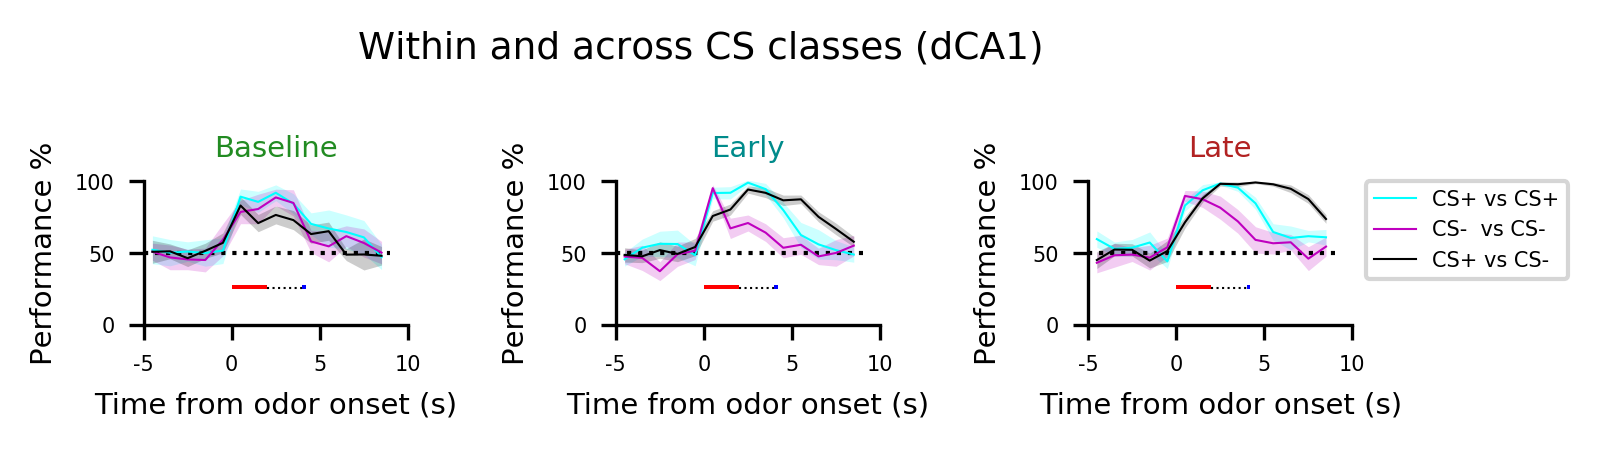

In [107]:
fig, ax = pl.subplots(1,3, figsize=(5, 1.5))

for comp,c,la in zip(['CS1vsCS2','CS3vsCS4','CSPvsCSM'],['cyan','m','k'],['CS+ vs CS+','CS-  vs CS-','CS+ vs CS-']):
    for r,sess in zip(range(3),sessions):
        ax[r].plot([(t-4.5) for t in range(14)], [(np.mean(eval("scores_tb_%s_%s[sess]"%(t,comp)))*100) for t in range(14)],
                   color=c, ls='-',lw=.5, zorder=19 ,ms=1,label=la)
        m = np.array([(np.mean(eval("scores_tb_%s_%s[sess]"%(t,comp)))*100) for t in range(14)])
        s = np.array([np.std(eval("scores_tb_%s_%s[sess]"%(t,comp)))*100 for t in range(14)])
        ax[r].fill_between([(t-4.5) for t in range(14)],m-s,m+s,alpha=0.2,color=c,linewidth=0)
for x in range (3):
    ax[x].set_ylim(0, 100)
    ax[x].set_xlim(-5, 9)
    ax[x].set_xticks(np.arange(-5,11, 5))
    ax[x].set_xticklabels(np.arange(-5,11, 5))
    ax[x].hlines(50, -5,9, color='k', lw=1, linestyles='dotted')
    ax[x].set_xlabel('Time from odor onset (s)')
    ax[x].set_ylabel('Performance %')
    pt.plot_period_bar(ax[x], 25, start_end=(0, 2), color='r', delta_y=3)
# pt.plot_period_bar(ax, 25, start_end=(2, 4), color='0.7', delta_y=2)
    pt.plot_period_bar(ax[x], 25, start_end=(4, 4.2), color='b', delta_y=3)
    ax[x].hlines(25+1, 2, 4, color='k', lw=0.5, linestyles='dotted')
ax[0].set_title('Baseline', color=dark_co[0])
ax[1].set_title('Early', color = dark_co[1])
ax[2].set_title('Late', color = dark_co[2])
ax[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("Within and across CS classes (dCA1)", fontsize=9, y=1.05)

fig.tight_layout(pad=2)


fig.savefig('../img/%s_3comp_horizontal.jpg'%NOTEBOOK_NAME)

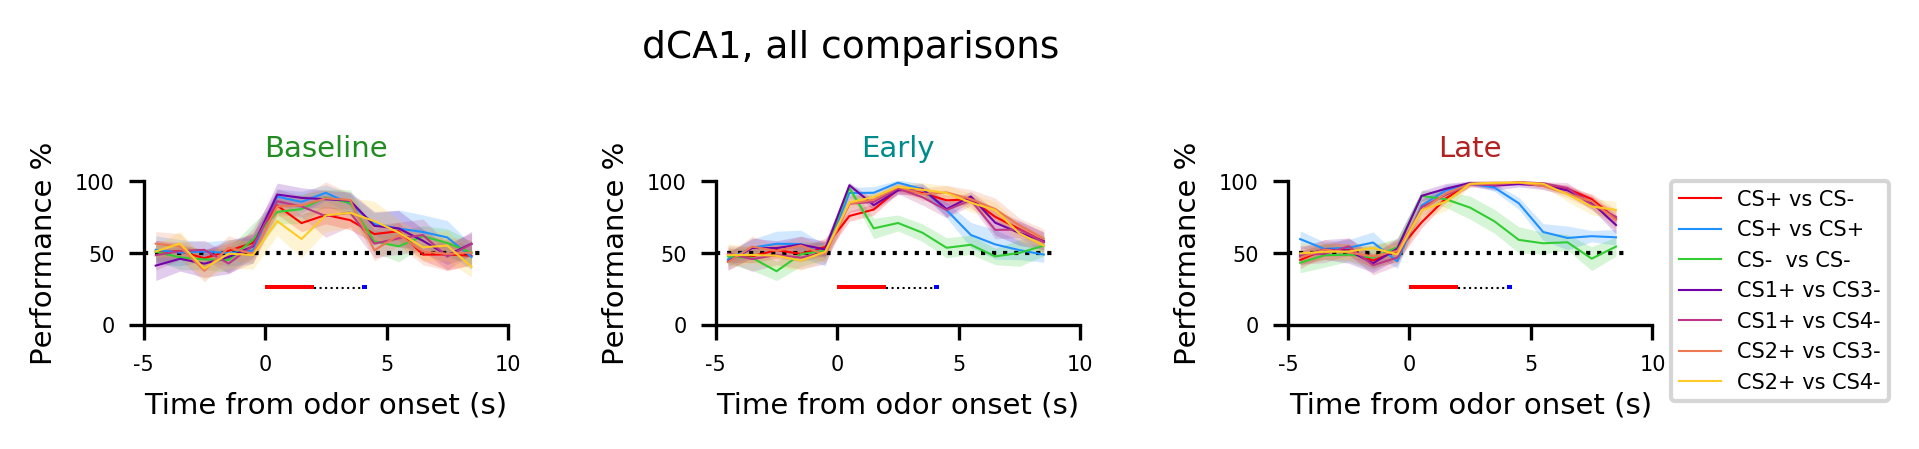

In [108]:
fig, ax = pl.subplots(1,3, figsize=(6, 1.5))

for comp,c,la in zip(comparisons,comp_colors,comp_labels):
    for r,sess in zip(range(3),sessions):
        ax[r].plot([(t-4.5) for t in range(14)], [(np.mean(eval("scores_tb_%s_%s[sess]"%(t,comp)))*100) for t in range(14)],
                   color=c, ls='-',lw=.5, zorder=19 ,ms=1,label=la)
        m = np.array([(np.mean(eval("scores_tb_%s_%s[sess]"%(t,comp)))*100) for t in range(14)])
        s = np.array([np.std(eval("scores_tb_%s_%s[sess]"%(t,comp)))*100 for t in range(14)])
        ax[r].fill_between([(t-4.5) for t in range(14)],m-s,m+s,alpha=0.2,color=c,linewidth=0)
for x in range (3):
    ax[x].set_ylim(0, 100)
    ax[x].set_xlim(-5, 9)
    ax[x].set_xticks(np.arange(-5,11, 5))
    ax[x].set_xticklabels(np.arange(-5,11, 5))
    ax[x].hlines(50, -5,9, color='k', lw=1, linestyles='dotted')
    ax[x].set_xlabel('Time from odor onset (s)')
    ax[x].set_ylabel('Performance %')
    pt.plot_period_bar(ax[x], 25, start_end=(0, 2), color='r', delta_y=3)
# pt.plot_period_bar(ax, 25, start_end=(2, 4), color='0.7', delta_y=2)
    pt.plot_period_bar(ax[x], 25, start_end=(4, 4.2), color='b', delta_y=3)
    ax[x].hlines(25+1, 2, 4, color='k', lw=0.5, linestyles='dotted')
ax[0].set_title('Baseline', color=dark_co[0])
ax[1].set_title('Early', color = dark_co[1])
ax[2].set_title('Late', color = dark_co[2])
ax[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("dCA1, all comparisons", fontsize=9, y=1.05)

fig.tight_layout(pad=2)


#fig.savefig('../img/%s_CSPvsCSM_horizontal.pdf'%NOTEBOOK_NAME)

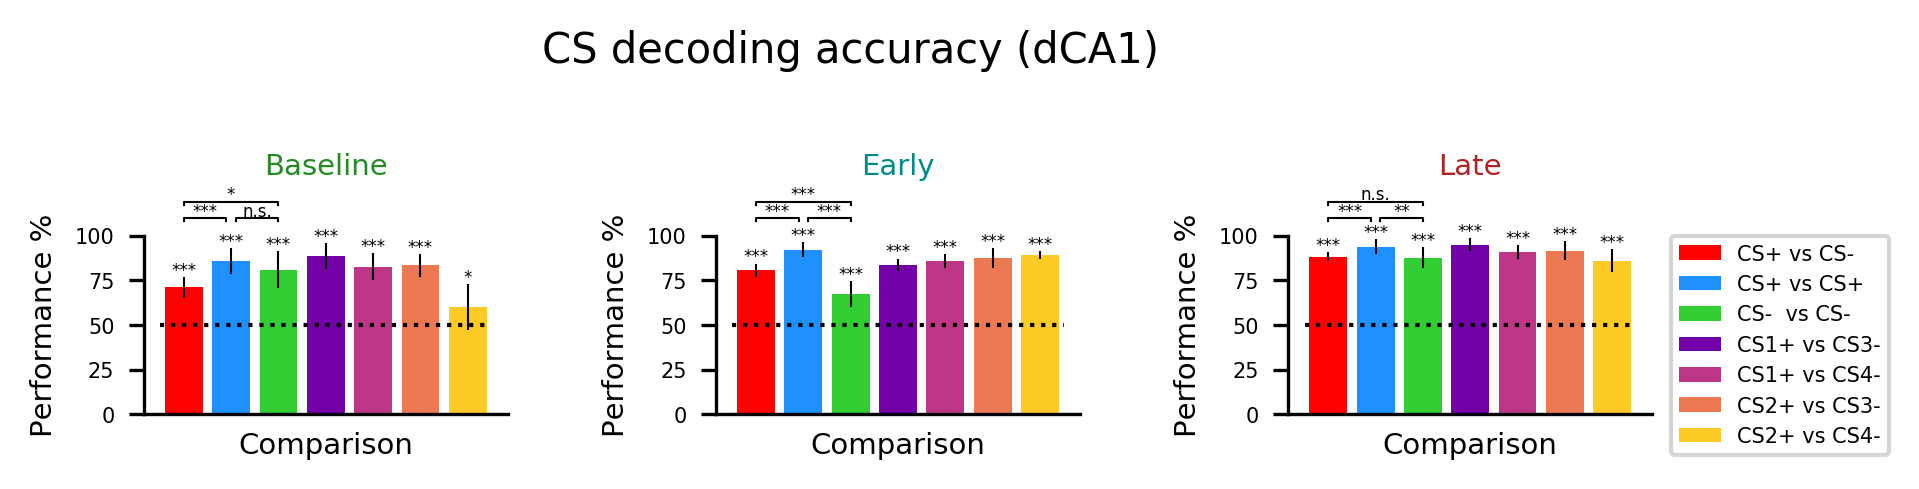

In [109]:
fig, ax = pl.subplots(1,3, figsize=(6, 1.7))
loops=15
for comp,c,la,i in zip(comparisons,comp_colors,comp_labels,range(len(comparisons))):
    for r,sess in zip(range(3),sessions):
        ax[r].bar(i,np.mean(eval("scores_tb_6_%s[sess][:loops]"%(comp)))*100,width=.8, color=c,label=la)
        exec("s_%s_%s = np.array(np.std(scores_tb_6_%s[sess][:loops])*100)"%(comp,sess,comp))
        ax[r].errorbar(i,np.mean(eval("scores_tb_6_%s[sess][:loops]"%(comp)))*100,yerr=eval('s_%s_%s'%(comp,sess)),color='k')
for x in range (3):
    ax[x].set_ylim(0, 100)
    #ax[x].set_xlim(-5, 9)
    ax[x].hlines(50, -0.5,6.5, color='k', lw=1, linestyles='dotted')
    ax[x].set_xlabel('Comparison')
    ax[x].set_ylabel('Performance %')
    ax[x].tick_params(axis='x',bottom='off',labelbottom='off')

pvs=[]
for r,sess in zip(range(3),sessions):
    pvs.append(add_significance(ax[r], eval("scores_tb_6_%s[sess]"%(comparisons[0]))[:loops],
                eval("scores_tb_6_%s[sess]"%(comparisons[1]))[:loops],0,.9,110))
    pvs.append(add_significance(ax[r], eval("scores_tb_6_%s[sess]"%(comparisons[1]))[:loops],
                eval("scores_tb_6_%s[sess]"%(comparisons[2]))[:loops],1.1,2,110))
    pvs.append(add_significance(ax[r], eval("scores_tb_6_%s[sess]"%(comparisons[0]))[:loops],
                eval("scores_tb_6_%s[sess]"%(comparisons[2]))[:loops],0,2,119))
for comp,i in zip(comparisons, range(len(comparisons))):
    for r,sess in zip(range(3),sessions):
        pvs.append(sig_vs_chance(ax[r],eval("scores_tb_6_%s[sess]"%(comp))[:loops],.5,i,
               np.mean(eval("scores_tb_6_%s[sess][:loops]"%(comp)))*100+(eval("s_%s_%s"%(comp,sess)))+1,loops=loops,sig_func=None,colors='k'))

ax[0].set_title('Baseline', color=dark_co[0], y=1.2)
ax[1].set_title('Early', color = dark_co[1], y=1.2)
ax[2].set_title('Late', color = dark_co[2], y=1.2)
ax[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("CS decoding accuracy (dCA1)", fontsize=10, y=1)

fig.tight_layout(pad=2)


#fig.savefig('../img/%s_CSPvsCSM_horizontal.pdf'%NOTEBOOK_NAME)

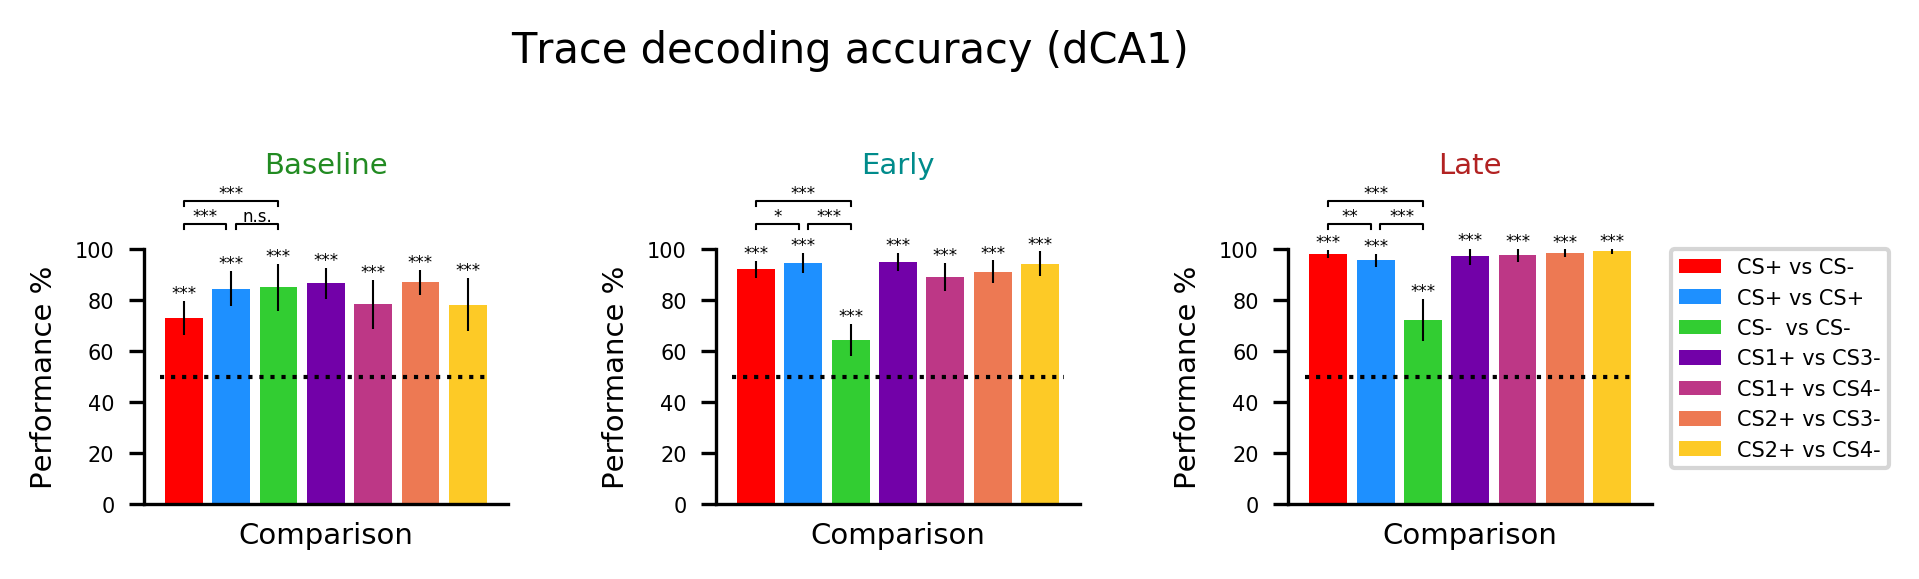

In [111]:
fig, ax = pl.subplots(1,3, figsize=(6, 2))
loops=15
for comp,c,la,i in zip(comparisons,comp_colors,comp_labels,range(len(comparisons))):
    for r,sess in zip(range(3),sessions):
        ax[r].bar(i,np.mean(eval("scores_tb_8_%s[sess][:loops]"%(comp)))*100,width=.8, color=c,label=la)
        exec("s_%s_%s = np.array(np.std(scores_tb_8_%s[sess][:loops])*100)"%(comp,sess,comp))
        ax[r].errorbar(i,np.mean(eval("scores_tb_8_%s[sess][:loops]"%(comp)))*100,yerr=eval('s_%s_%s'%(comp,sess)),color='k')
for x in range (3):
    ax[x].set_ylim(0, 100)
    #ax[x].set_xlim(-5, 9)
    ax[x].hlines(50, -0.5,6.5, color='k', lw=1, linestyles='dotted')
    ax[x].set_xlabel('Comparison')
    ax[x].set_ylabel('Performance %')
    ax[x].tick_params(axis='x',bottom='off',labelbottom='off')

pvs=[]
for r,sess in zip(range(3),sessions):
    pvs.append(add_significance(ax[r], eval("scores_tb_8_%s[sess]"%(comparisons[0]))[:loops],
                eval("scores_tb_8_%s[sess]"%(comparisons[1]))[:loops],0,.9,110))
    pvs.append(add_significance(ax[r], eval("scores_tb_8_%s[sess]"%(comparisons[1]))[:loops],
                eval("scores_tb_8_%s[sess]"%(comparisons[2]))[:loops],1.1,2,110))
    pvs.append(add_significance(ax[r], eval("scores_tb_8_%s[sess]"%(comparisons[0]))[:loops],
                eval("scores_tb_8_%s[sess]"%(comparisons[2]))[:loops],0,2,119))
for comp,i in zip(comparisons, range(len(comparisons))):
    for r,sess in zip(range(3),sessions):
        pvs.append(sig_vs_chance(ax[r],eval("scores_tb_8_%s[sess]"%(comp))[:loops],.5,i,
               np.mean(eval("scores_tb_8_%s[sess][:loops]"%(comp)))*100+(eval("s_%s_%s"%(comp,sess)))+1,loops=loops,sig_func=None,colors='k'))

ax[0].set_title('Baseline', color=dark_co[0], y=1.2)
ax[1].set_title('Early', color = dark_co[1], y=1.2)
ax[2].set_title('Late', color = dark_co[2], y=1.2)
ax[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("Trace decoding accuracy (dCA1)", fontsize=10, y=1)


fig.tight_layout(pad=2)


#fig.savefig('../img/%s_CSPvsCSM_horizontal.pdf'%NOTEBOOK_NAME)

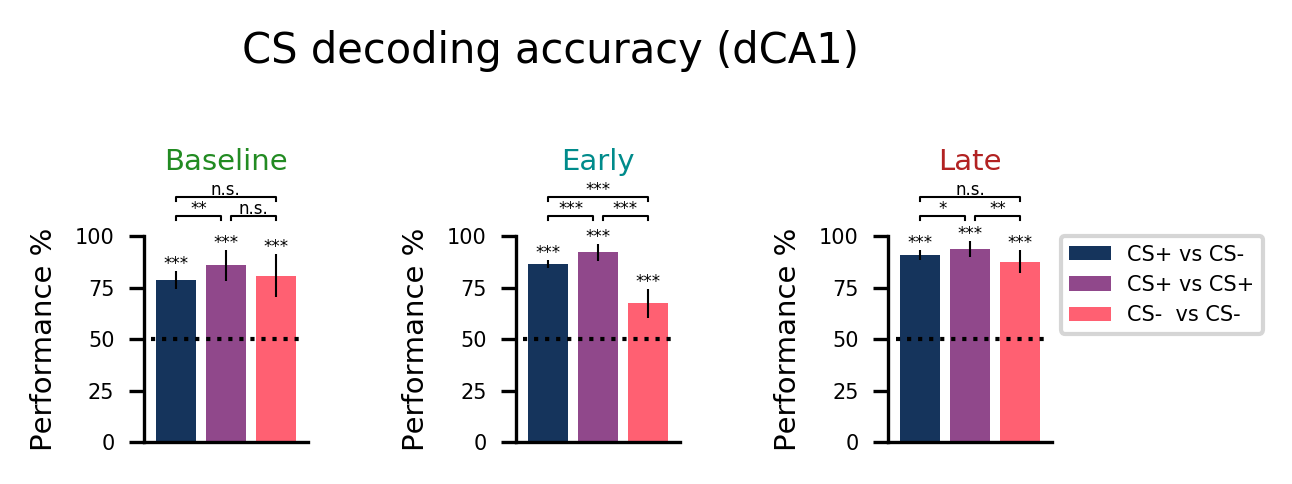

In [112]:
fig, ax = pl.subplots(1,3, figsize=(4, 1.7))
loops=15
for comp,c,la,i in zip(alt_comparisons[:3],alt2_colors[:3],comp_labels[:3],range(len(comparisons[:3]))):
    for r,sess in zip(range(3),sessions):
        ax[r].bar(i,np.mean(eval("scores_tb_6_%s[sess][:loops]"%(comp)))*100,width=.8, color=c,label=la)
        exec("s_%s_%s = np.array(np.std(scores_tb_6_%s[sess][:loops])*100)"%(comp,sess,comp))
        ax[r].errorbar(i,np.mean(eval("scores_tb_6_%s[sess][:loops]"%(comp)))*100,yerr=eval('s_%s_%s'%(comp,sess)),color='k')
for x in range (3):
    ax[x].set_ylim(0, 100)
    #ax[x].set_xlim(-5, 9)
    ax[x].hlines(50, -0.5,2.5, color='k', lw=1, linestyles='dotted')
    #ax[x].set_xlabel('Comparison')
    ax[x].set_ylabel('Performance %')
    ax[x].tick_params(axis='x',bottom='off',labelbottom='off')

pvs=[]
for r,sess in zip(range(3),sessions):
    pvs.append(add_significance(ax[r], eval("scores_tb_6_%s[sess]"%(alt_comparisons[0]))[:loops],
                eval("scores_tb_6_%s[sess]"%(alt_comparisons[1]))[:loops],0,.9,110))
    pvs.append(add_significance(ax[r], eval("scores_tb_6_%s[sess]"%(alt_comparisons[1]))[:loops],
                eval("scores_tb_6_%s[sess]"%(alt_comparisons[2]))[:loops],1.1,2,110))
    pvs.append(add_significance(ax[r], eval("scores_tb_6_%s[sess]"%(alt_comparisons[0]))[:loops],
                eval("scores_tb_6_%s[sess]"%(alt_comparisons[2]))[:loops],0,2,119))
for comp,i in zip(alt_comparisons[:3], range(len(alt_comparisons[:3]))):
    for r,sess in zip(range(3),sessions):
        pvs.append(sig_vs_chance(ax[r],eval("scores_tb_6_%s[sess]"%(comp))[:loops],.5,i,
               np.mean(eval("scores_tb_6_%s[sess][:loops]"%(comp)))*100+(eval("s_%s_%s"%(comp,sess)))+1,loops=loops,sig_func=None,colors='k'))

ax[0].set_title('Baseline', color=dark_co[0], y=1.2)
ax[1].set_title('Early', color = dark_co[1], y=1.2)
ax[2].set_title('Late', color = dark_co[2], y=1.2)
ax[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("CS decoding accuracy (dCA1)", fontsize=10, y=1)

fig.tight_layout(pad=2)


fig.savefig('../img/%s_3comp_bars_CS.jpg'%NOTEBOOK_NAME)

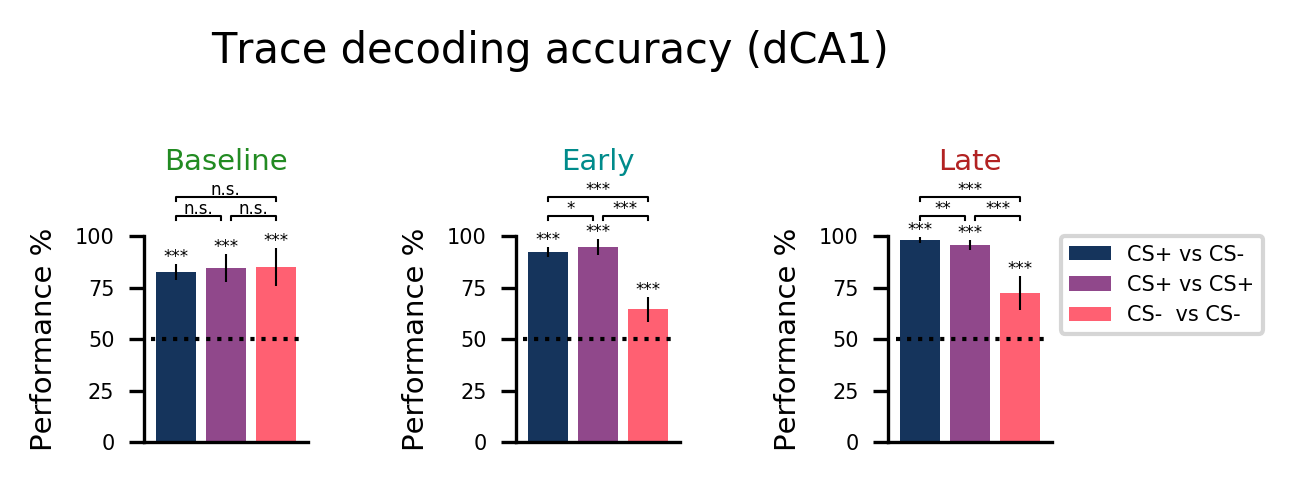

In [113]:
fig, ax = pl.subplots(1,3, figsize=(4, 1.7))
loops=15
for comp,c,la,i in zip(alt_comparisons[:3],alt2_colors[:3],comp_labels[:3],range(len(alt_comparisons[:3]))):
    for r,sess in zip(range(3),sessions):
        ax[r].bar(i,np.mean(eval("scores_tb_8_%s[sess][:loops]"%(comp)))*100,width=.8, color=c,label=la)
        exec("s_%s_%s = np.array(np.std(scores_tb_8_%s[sess][:loops])*100)"%(comp,sess,comp))
        ax[r].errorbar(i,np.mean(eval("scores_tb_8_%s[sess][:loops]"%(comp)))*100,yerr=eval('s_%s_%s'%(comp,sess)),color='k')
for x in range (3):
    ax[x].set_ylim(0, 100)
    #ax[x].set_xlim(-5, 9)
    ax[x].hlines(50, -0.5,2.5, color='k', lw=1, linestyles='dotted')
    #ax[x].set_xlabel('Comparison')
    ax[x].set_ylabel('Performance %')
    ax[x].tick_params(axis='x',bottom='off',labelbottom='off')

pvs=[]
for r,sess in zip(range(3),sessions):
    pvs.append(add_significance(ax[r], eval("scores_tb_8_%s[sess]"%(alt_comparisons[0]))[:loops],
                eval("scores_tb_8_%s[sess]"%(alt_comparisons[1]))[:loops],0,.9,110))
    pvs.append(add_significance(ax[r], eval("scores_tb_8_%s[sess]"%(alt_comparisons[1]))[:loops],
                eval("scores_tb_8_%s[sess]"%(alt_comparisons[2]))[:loops],1.1,2,110))
    pvs.append(add_significance(ax[r], eval("scores_tb_8_%s[sess]"%(alt_comparisons[0]))[:loops],
                eval("scores_tb_8_%s[sess]"%(alt_comparisons[2]))[:loops],0,2,119))
for comp,i in zip(alt_comparisons[:3], range(len(alt_comparisons[:3]))):
    for r,sess in zip(range(3),sessions):
        pvs.append(sig_vs_chance(ax[r],eval("scores_tb_8_%s[sess]"%(comp))[:loops],.5,i,
               np.mean(eval("scores_tb_8_%s[sess][:loops]"%(comp)))*100+(eval("s_%s_%s"%(comp,sess)))+1,loops=loops,sig_func=None,colors='k'))

ax[0].set_title('Baseline', color=dark_co[0], y=1.2)
ax[1].set_title('Early', color = dark_co[1], y=1.2)
ax[2].set_title('Late', color = dark_co[2], y=1.2)
ax[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("Trace decoding accuracy (dCA1)", fontsize=10, y=1)

fig.tight_layout(pad=2)


fig.savefig('../img/%s_3comp_bars_Tr.jpg'%NOTEBOOK_NAME)

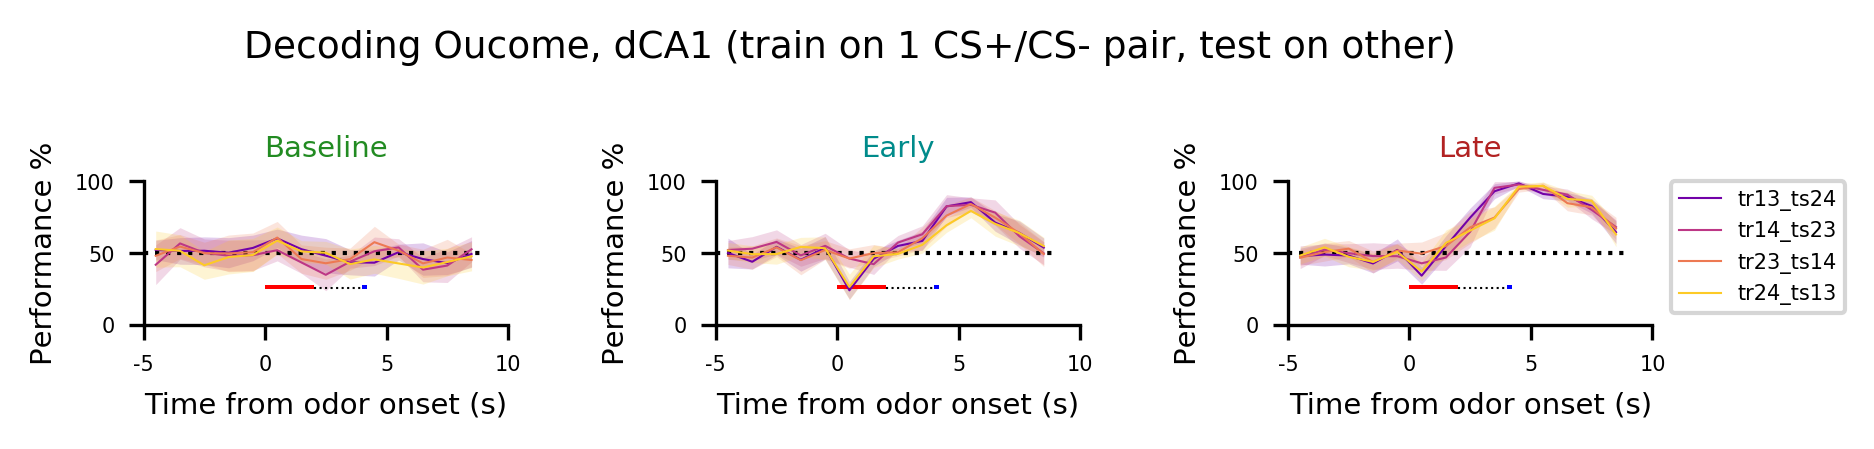

In [114]:
fig, ax = pl.subplots(1,3, figsize=(6, 1.5))

for comp,c,la in zip(['tr13_ts24','tr14_ts23','tr23_ts14','tr24_ts13'],tt_colors,['tr13_ts24','tr14_ts23','tr23_ts14','tr24_ts13']):
    for r,sess in zip(range(3),sessions):
        ax[r].plot([(t-4.5) for t in range(14)], [(np.mean(eval("scores_tb_%s_outcome_%s[sess]"%(t,comp)))*100) for t in range(14)],
                   color=c, ls='-',lw=.5, zorder=19 ,ms=1,label=la)
        m = np.array([(np.mean(eval("scores_tb_%s_outcome_%s[sess]"%(t,comp)))*100) for t in range(14)])
        s = np.array([np.std(eval("scores_tb_%s_outcome_%s[sess]"%(t,comp)))*100 for t in range(14)])
        ax[r].fill_between([(t-4.5) for t in range(14)],m-s,m+s,alpha=0.2,color=c,linewidth=0)
for x in range (3):
    ax[x].set_ylim(0, 100)
    ax[x].set_xlim(-5, 9)
    ax[x].set_xticks(np.arange(-5,11, 5))
    ax[x].set_xticklabels(np.arange(-5,11, 5))
    ax[x].hlines(50, -5,9, color='k', lw=1, linestyles='dotted')
    ax[x].set_xlabel('Time from odor onset (s)')
    ax[x].set_ylabel('Performance %')
    pt.plot_period_bar(ax[x], 25, start_end=(0, 2), color='r', delta_y=3)
# pt.plot_period_bar(ax, 25, start_end=(2, 4), color='0.7', delta_y=2)
    pt.plot_period_bar(ax[x], 25, start_end=(4, 4.2), color='b', delta_y=3)
    ax[x].hlines(25+1, 2, 4, color='k', lw=0.5, linestyles='dotted')
ax[0].set_title('Baseline', color=dark_co[0])
ax[1].set_title('Early', color = dark_co[1])
ax[2].set_title('Late', color = dark_co[2])
ax[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("Decoding Oucome, dCA1 (train on 1 CS+/CS- pair, test on other)", fontsize=9, y=1.05)

fig.tight_layout(pad=2)


fig.savefig('../img/%s_outcome_horizontal.jpg'%NOTEBOOK_NAME)

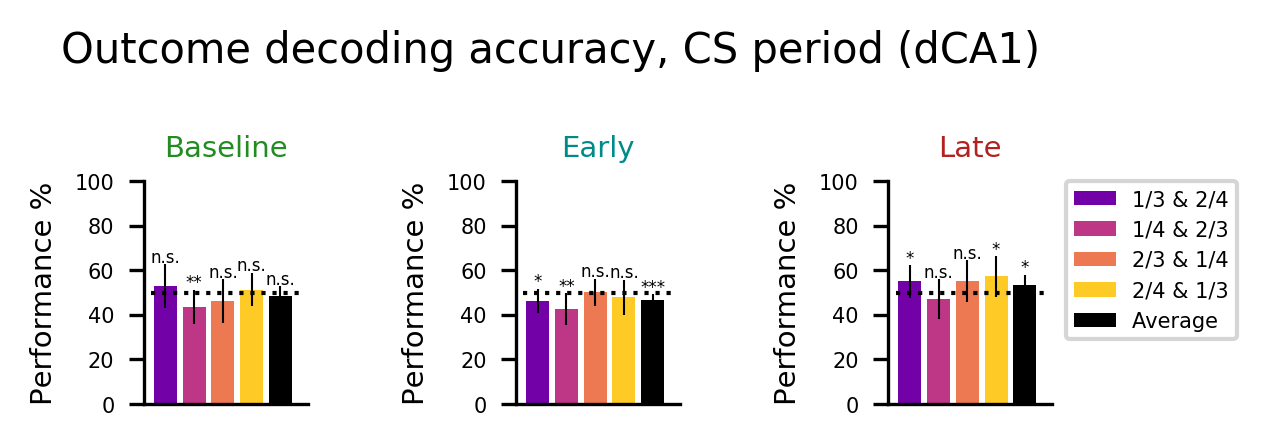

In [115]:
fig, ax = pl.subplots(1,3, figsize=(4, 1.5))
loops=15
tt_comparisons =['tr13_ts24','tr14_ts23','tr23_ts14','tr24_ts13','averaged']
for comp,c,la,i in zip(tt_comparisons,tt_colors_k,['1/3 & 2/4','1/4 & 2/3','2/3 & 1/4','2/4 & 1/3','Average'],range(5)):
    for r,sess in zip(range(3),sessions):
        ax[r].bar(i,np.mean(eval("scores_tb_6_outcome_%s[sess][:loops]"%(comp)))*100,width=.8, color=c,label=la)
        exec("s_%s_%s = np.array(np.std(scores_tb_6_outcome_%s[sess][:loops])*100)"%(comp,sess,comp))
        ax[r].errorbar(i,np.mean(eval("scores_tb_6_outcome_%s[sess][:loops]"%(comp)))*100,yerr=eval('s_%s_%s'%(comp,sess)),color='k')
for x in range (3):
    ax[x].set_ylim(0, 100)
    #ax[x].set_xlim(-5, 9)
    ax[x].hlines(50, -0.5,4.7, color='k', lw=1, linestyles='dotted')
    #ax[x].set_xlabel('Comparison')
    ax[x].set_ylabel('Performance %')
    ax[x].tick_params(axis='x',bottom='off',labelbottom='off')

pvs=[]
#for r,sess in zip(range(3),sessions):
#    pvs.append(add_significance(ax[r], eval("scores_tb_8_outcome_%s[sess]"%(tt_comparisons[0]))[:loops],
#                eval("scores_tb_8_outcome_%s[sess]"%(tt_comparisons[1]))[:loops],0,.9,110))
#    pvs.append(add_significance(ax[r], eval("scores_tb_8_outcome_%s[sess]"%(tt_comparisons[1]))[:loops],
#                eval("scores_tb_8_outcome_%s[sess]"%(tt_comparisons[2]))[:loops],1.1,2,110))
#    pvs.append(add_significance(ax[r], eval("scores_tb_8_outcome_%s[sess]"%(tt_comparisons[0]))[:loops],
#                eval("scores_tb_8_outcome_%s[sess]"%(tt_comparisons[2]))[:loops],0,2,119))
for comp,i in zip(tt_comparisons, range(len(tt_comparisons))):
    for r,sess in zip(range(3),sessions):
        pvs.append(sig_vs_chance(ax[r],eval("scores_tb_6_outcome_%s[sess][:loops]"%(comp)),.5,i,
               np.mean(eval("scores_tb_6_outcome_%s[sess][:loops]"%(comp)))*100+(eval("s_%s_%s"%(comp,sess)))+1,loops=loops,sig_func=None,colors='k'))

ax[0].set_title('Baseline', color=dark_co[0], y=1.)
ax[1].set_title('Early', color = dark_co[1], y=1.)
ax[2].set_title('Late', color = dark_co[2], y=1.)
ax[2].legend(bbox_to_anchor=(1.08, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("Outcome decoding accuracy, CS period (dCA1)", fontsize=10, y=1.05)

fig.tight_layout(pad=2)


fig.savefig('../img/%s_outcome_bars_CS.jpg'%NOTEBOOK_NAME)

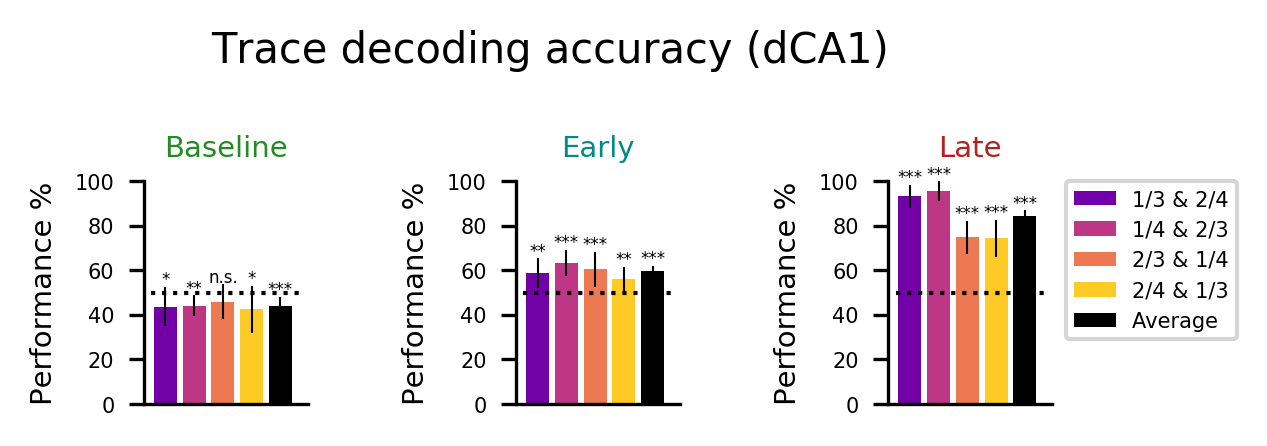

In [116]:
fig, ax = pl.subplots(1,3, figsize=(4, 1.5))
loops=15
tt_comparisons =['tr13_ts24','tr14_ts23','tr23_ts14','tr24_ts13','averaged']
for comp,c,la,i in zip(tt_comparisons,tt_colors_k,['1/3 & 2/4','1/4 & 2/3','2/3 & 1/4','2/4 & 1/3','Average'],range(5)):
    for r,sess in zip(range(3),sessions):
        ax[r].bar(i,np.mean(eval("scores_tb_8_outcome_%s[sess][:loops]"%(comp)))*100,width=.8, color=c,label=la)
        exec("s_%s_%s = np.array(np.std(scores_tb_8_outcome_%s[sess][:loops])*100)"%(comp,sess,comp))
        ax[r].errorbar(i,np.mean(eval("scores_tb_8_outcome_%s[sess][:loops]"%(comp)))*100,yerr=eval('s_%s_%s'%(comp,sess)),color='k')
for x in range (3):
    ax[x].set_ylim(0, 100)
    #ax[x].set_xlim(-5, 9)
    ax[x].hlines(50, -0.5,4.7, color='k', lw=1, linestyles='dotted')
    #ax[x].set_xlabel('Comparison')
    ax[x].set_ylabel('Performance %')
    ax[x].tick_params(axis='x',bottom='off',labelbottom='off')

pvs=[]
#for r,sess in zip(range(3),sessions):
#    pvs.append(add_significance(ax[r], eval("scores_tb_8_outcome_%s[sess]"%(tt_comparisons[0]))[:loops],
#                eval("scores_tb_8_outcome_%s[sess]"%(tt_comparisons[1]))[:loops],0,.9,110))
#    pvs.append(add_significance(ax[r], eval("scores_tb_8_outcome_%s[sess]"%(tt_comparisons[1]))[:loops],
#                eval("scores_tb_8_outcome_%s[sess]"%(tt_comparisons[2]))[:loops],1.1,2,110))
#    pvs.append(add_significance(ax[r], eval("scores_tb_8_outcome_%s[sess]"%(tt_comparisons[0]))[:loops],
#                eval("scores_tb_8_outcome_%s[sess]"%(tt_comparisons[2]))[:loops],0,2,119))
for comp,i in zip(tt_comparisons, range(len(tt_comparisons))):
    for r,sess in zip(range(3),sessions):
        pvs.append(sig_vs_chance(ax[r],eval("scores_tb_8_outcome_%s[sess]"%(comp))[:loops],.5,i,
               np.mean(eval("scores_tb_8_outcome_%s[sess][:loops]"%(comp)))*100+(eval("s_%s_%s"%(comp,sess)))+1,loops=loops,sig_func=None,colors='k'))

ax[0].set_title('Baseline', color=dark_co[0], y=1.)
ax[1].set_title('Early', color = dark_co[1], y=1.)
ax[2].set_title('Late', color = dark_co[2], y=1.)
ax[2].legend(bbox_to_anchor=(1.08, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("Trace decoding accuracy (dCA1)", fontsize=10, y=1.05)

fig.tight_layout(pad=2)


fig.savefig('../img/%s_outcome_bars_CS.jpg'%NOTEBOOK_NAME)

# Now for equalizing cell #s across all sess by using min

In [117]:
#get number of vHPC cells used for decoding
cell_total = ['total_cells_expo_vHPC', 'total_cells_pre_vHPC', 'total_cells_post_vHPC']
for tot in cell_total:
    what = ut.load_variable('%s'%(tot), '../notebooks/autorestore/decoding_n_cells/')
    exec('%s = what'%(tot))
    print '%s ='%(tot),
    print what

total_cells_expo_vHPC = 332
total_cells_pre_vHPC = 271
total_cells_post_vHPC = 630


In [118]:
#get number of dHPC cells used for decoding
cell_total = ['total_cells_expo_dHPC', 'total_cells_pre_dHPC', 'total_cells_post_dHPC']
for tot in cell_total:
    what = ut.load_variable('%s'%(tot), '../notebooks/autorestore/decoding_n_cells/')
    exec('%s = what'%(tot))
    print '%s ='%(tot),
    print what

total_cells_expo_dHPC = 557
total_cells_pre_dHPC = 517
total_cells_post_dHPC = 550


In [119]:
gmin = np.min((total_cells_pre_vHPC,total_cells_pre_dHPC, total_cells_post_vHPC,total_cells_post_dHPC,
                total_cells_expo_vHPC,total_cells_expo_dHPC))
print gmin

dmin = np.min((total_cells_pre_dHPC, total_cells_post_dHPC,total_cells_expo_dHPC))
print dmin

271
517


In [178]:
#get train and test subsamples for each timebin, for each session
relabel = {1:0,2:1,3:-1,4:-1}
n_loops=50
for t in range(14): # number of time bins
    exec('scores_tb_%s_gmin_CS1vsCS2 = {}'%t)
    for sess in sessions:
        print sess,
        print t,
        eval("scores_tb_%s_gmin_CS1vsCS2"%t)[sess] = np.r_[[do_test_within(eval("patterns_tb_%s_%s"%(t,sess)),eval("labels_%s"%sess),
              classes=range(1,5), n_cells=gmin, relabel=relabel) for i in range(n_loops)]]

expo 0 pre 0 post 0 expo 1 pre 1 post 1 expo 2 pre 2 post 2 expo 3 pre 3 post 3 expo 4 pre 4 post 4 expo 5 pre 5 post 5 expo 6 pre 6 post 6 expo 7 pre 7 post 7 expo 8 pre 8 post 8 expo 9 pre 9 post 9 expo 10 pre 10 post 10 expo 11 pre 11 post 11 expo 12 pre 12 post 12 expo 13 pre 13 post 13


In [179]:
%%time
relabel = {1:0,2:0,3:1,4:1}
for t in range(14): # number of time bins
    exec('scores_tb_%s_gmin_CSPvsCSM = {}'%t)
    n_loops = 50
    for sess in sessions:
        print sess,
        print t,
        eval("scores_tb_%s_gmin_CSPvsCSM"%t)[sess] = np.r_[[do_test_within(eval("patterns_tb_%s_%s"%(t,sess)),eval("labels_%s"%sess),
              classes=range(1,5), n_cells=gmin, relabel=relabel) for i in range(n_loops)]]

expo 0 pre 0 post 0 expo 1 pre 1 post 1 expo 2 pre 2 post 2 expo 3 pre 3 post 3 expo 4 pre 4 post 4 expo 5 pre 5 post 5 expo 6 pre 6 post 6 expo 7 pre 7 post 7 expo 8 pre 8 post 8 expo 9 pre 9 post 9 expo 10 pre 10 post 10 expo 11 pre 11 post 11 expo 12 pre 12 post 12 expo 13 pre 13 post 13CPU times: user 1min 43s, sys: 148 ms, total: 1min 43s
Wall time: 1min 43s



In [180]:
%%time
relabel = {1:0,2:-1,3:1,4:-1}
for t in range(14): # number of time bins
    exec('scores_tb_%s_gmin_CS1vsCS3 = {}'%t)
    n_loops = 50
    for sess in sessions:
        print sess,
        print t,
        eval("scores_tb_%s_gmin_CS1vsCS3"%t)[sess] = np.r_[[do_test_within(eval("patterns_tb_%s_%s"%(t,sess)),eval("labels_%s"%sess),
              classes=range(1,5), n_cells=gmin, relabel=relabel) for i in range(n_loops)]]

expo 0 pre 0 post 0 expo 1 pre 1 post 1 expo 2 pre 2 post 2 expo 3 pre 3 post 3 expo 4 pre 4 post 4 expo 5 pre 5 post 5 expo 6 pre 6 post 6 expo 7 pre 7 post 7 expo 8 pre 8 post 8 expo 9 pre 9 post 9 expo 10 pre 10 post 10 expo 11 pre 11 post 11 expo 12 pre 12 post 12 expo 13 pre 13 post 13CPU times: user 1min 14s, sys: 148 ms, total: 1min 14s
Wall time: 1min 14s



In [181]:
%%time
relabel = {1:0,2:-1,3:-1,4:1}
for t in range(14): # number of time bins
    exec('scores_tb_%s_gmin_CS1vsCS4 = {}'%t)
    n_loops = 50
    for sess in sessions:
        print sess,
        print t,
        eval("scores_tb_%s_gmin_CS1vsCS4"%t)[sess] = np.r_[[do_test_within(eval("patterns_tb_%s_%s"%(t,sess)),eval("labels_%s"%sess),
              classes=range(1,5), n_cells=gmin, relabel=relabel) for i in range(n_loops)]]

expo 0 pre 0 post 0 expo 1 pre 1 post 1 expo 2 pre 2 post 2 expo 3 pre 3 post 3 expo 4 pre 4 post 4 expo 5 pre 5 post 5 expo 6 pre 6 post 6 expo 7 pre 7 post 7 expo 8 pre 8 post 8 expo 9 pre 9 post 9 expo 10 pre 10 post 10 expo 11 pre 11 post 11 expo 12 pre 12 post 12 expo 13 pre 13 post 13CPU times: user 1min 14s, sys: 200 ms, total: 1min 14s
Wall time: 1min 14s



In [182]:
%%time
relabel = {1:-1,2:0,3:1,4:-1}
for t in range(14): # number of time bins
    exec('scores_tb_%s_gmin_CS2vsCS3 = {}'%t)
    n_loops = 50
    for sess in sessions:
        print sess,
        print t,
        eval("scores_tb_%s_gmin_CS2vsCS3"%t)[sess] = np.r_[[do_test_within(eval("patterns_tb_%s_%s"%(t,sess)),eval("labels_%s"%sess),
              classes=range(1,5), n_cells=gmin, relabel=relabel) for i in range(n_loops)]]

expo 0 pre 0 post 0 expo 1 pre 1 post 1 expo 2 pre 2 post 2 expo 3 pre 3 post 3 expo 4 pre 4 post 4 expo 5 pre 5 post 5 expo 6 pre 6 post 6 expo 7 pre 7 post 7 expo 8 pre 8 post 8 expo 9 pre 9 post 9 expo 10 pre 10 post 10 expo 11 pre 11 post 11 expo 12 pre 12 post 12 expo 13 pre 13 post 13CPU times: user 1min 14s, sys: 152 ms, total: 1min 14s
Wall time: 1min 14s



In [183]:
%%time
relabel = {1:-1,2:0,3:-1,4:1}
for t in range(14): # number of time bins
    exec('scores_tb_%s_gmin_CS2vsCS4 = {}'%t)
    n_loops = 50
    for sess in sessions:
        print sess,
        print t,
        eval("scores_tb_%s_gmin_CS2vsCS4"%t)[sess] = np.r_[[do_test_within(eval("patterns_tb_%s_%s"%(t,sess)),eval("labels_%s"%sess),
              classes=range(1,5), n_cells=gmin, relabel=relabel) for i in range(n_loops)]]

expo 0 pre 0 post 0 expo 1 pre 1 post 1 expo 2 pre 2 post 2 expo 3 pre 3 post 3 expo 4 pre 4 post 4 expo 5 pre 5 post 5 expo 6 pre 6 post 6 expo 7 pre 7 post 7 expo 8 pre 8 post 8 expo 9 pre 9 post 9 expo 10 pre 10 post 10 expo 11 pre 11 post 11 expo 12 pre 12 post 12 expo 13 pre 13 post 13CPU times: user 1min 14s, sys: 176 ms, total: 1min 15s
Wall time: 1min 14s



In [184]:
%%time
relabel = {1:-1,2:-1,3:0,4:1}
for t in range(14): # number of time bins
    exec('scores_tb_%s_gmin_CS3vsCS4 = {}'%t)
    n_loops = 50
    for sess in sessions:
        print sess,
        print t,
        eval("scores_tb_%s_gmin_CS3vsCS4"%t)[sess] = np.r_[[do_test_within(eval("patterns_tb_%s_%s"%(t,sess)),eval("labels_%s"%sess),
              classes=range(1,5), n_cells=gmin, relabel=relabel) for i in range(n_loops)]]

expo 0 pre 0 post 0 expo 1 pre 1 post 1 expo 2 pre 2 post 2 expo 3 pre 3 post 3 expo 4 pre 4 post 4 expo 5 pre 5 post 5 expo 6 pre 6 post 6 expo 7 pre 7 post 7 expo 8 pre 8 post 8 expo 9 pre 9 post 9 expo 10 pre 10 post 10 expo 11 pre 11 post 11 expo 12 pre 12 post 12 expo 13 pre 13 post 13CPU times: user 1min 15s, sys: 152 ms, total: 1min 15s
Wall time: 1min 15s



In [185]:
%%time
tt_relabels = [{1:0,2:-1,3:1,4:-1}, {1:0,2:-1,3:-1,4:1}, {1:-1,2:0,3:1,4:-1}, {1:-1,2:0,3:-1,4:1}]
tt_relabels_test = [{1:-1,2:0,3:-1,4:1}, {1:-1,2:0,3:1,4:-1}, {1:0,2:-1,3:-1,4:1}, {1:0,2:-1,3:1,4:-1}]
tt_pairs = ['tr13_ts24','tr14_ts23','tr23_ts14','tr24_ts13']
for t in range(14): # number of time bins
    for re, rete, it in zip(tt_relabels,tt_relabels_test,tt_pairs):
        exec('scores_tb_%s_gmin_outcome_%s = {}'%(t,it))
        n_loops = 50
        for sess in sessions:
            print sess,
            print t,
            eval("scores_tb_%s_gmin_outcome_%s"%(t,it))[sess] = np.r_[[do_test_within(eval("patterns_tb_%s_%s"%(t,sess)),eval("labels_%s"%sess),
                  classes=range(1,5), n_cells=gmin, relabel=re, relabel_test=rete) for i in range(n_loops)]]

expo 0 pre 0 post 0 expo 0 pre 0 post 0 expo 0 pre 0 post 0 expo 0 pre 0 post 0 expo 1 pre 1 post 1 expo 1 pre 1 post 1 expo 1 pre 1 post 1 expo 1 pre 1 post 1 expo 2 pre 2 post 2 expo 2 pre 2 post 2 expo 2 pre 2 post 2 expo 2 pre 2 post 2 expo 3 pre 3 post 3 expo 3 pre 3 post 3 expo 3 pre 3 post 3 expo 3 pre 3 post 3 expo 4 pre 4 post 4 expo 4 pre 4 post 4 expo 4 pre 4 post 4 expo 4 pre 4 post 4 expo 5 pre 5 post 5 expo 5 pre 5 post 5 expo 5 pre 5 post 5 expo 5 pre 5 post 5 expo 6 pre 6 post 6 expo 6 pre 6 post 6 expo 6 pre 6 post 6 expo 6 pre 6 post 6 expo 7 pre 7 post 7 expo 7 pre 7 post 7 expo 7 pre 7 post 7 expo 7 pre 7 post 7 expo 8 pre 8 post 8 expo 8 pre 8 post 8 expo 8 pre 8 post 8 expo 8 pre 8 post 8 expo 9 pre 9 post 9 expo 9 pre 9 post 9 expo 9 pre 9 post 9 expo 9 pre 9 post 9 expo 10 pre 10 post 10 expo 10 pre 10 post 10 expo 10 pre 10 post 10 expo 10 pre 10 post 10 expo 11 pre 11 post 11 expo 11 pre 11 post 11 expo 11 pre 11 post 11 expo 11 pre 11 post 11 expo 12 pre 12 p

In [196]:
%%time
tt_relabels_cont = [{1:0,2:1,3:-1,4:-1}]
tt_relabels_test_cont = [{1:-1,2:-1,3:0,4:1}]
for t in range(14): # number of time bins
    for re, rete, it in zip(tt_relabels_cont,tt_relabels_test_cont,['tr12_ts34']):
        exec('scores_tb_%s_gmin_outcome_%s = {}'%(t,it))
        n_loops = 20
        for sess in sessions:
            print sess,
            print t,
            eval("scores_tb_%s_gmin_outcome_%s"%(t,it))[sess] = np.r_[[do_test_within(eval("patterns_tb_%s_%s"%(t,sess)),eval("labels_%s"%sess),
                  classes=range(1,5), n_cells=gmin, relabel=re, relabel_test=rete) for i in range(n_loops)]]

expo 0 pre 0 post 0 expo 1 pre 1 post 1 expo 2 pre 2 post 2 expo 3 pre 3 post 3 expo 4 pre 4 post 4 expo 5 pre 5 post 5 expo 6 pre 6 post 6 expo 7 pre 7 post 7 expo 8 pre 8 post 8 expo 9 pre 9 post 9 expo 10 pre 10 post 10 expo 11 pre 11 post 11 expo 12 pre 12 post 12 expo 13 pre 13 post 13CPU times: user 30.7 s, sys: 88 ms, total: 30.8 s
Wall time: 30.7 s



In [186]:
#for an alternative take on CS+ vs CS-, average each idividual comparison
for t in range(14):
    exec("scores_tb_%s_gmin_CSPvsCSM_averaged = {}"%t)
    for sess in sessions:
        exec("scores_tb_%s_gmin_CSPvsCSM_averaged[sess] = np.mean((scores_tb_%s_gmin_CS1vsCS3[sess],scores_tb_%s_gmin_CS1vsCS4[sess],\
              scores_tb_%s_gmin_CS2vsCS3[sess],scores_tb_%s_gmin_CS2vsCS4[sess]),axis=0)"%(t,t,t,t,t))

In [187]:
#for outcome endoding, average each idividual comparison
for t in range(14):
    exec("scores_tb_%s_gmin_outcome_averaged = {}"%t)
    for sess in sessions:
        exec("scores_tb_%s_gmin_outcome_averaged[sess] = np.mean((scores_tb_%s_gmin_outcome_tr13_ts24[sess],scores_tb_%s_gmin_outcome_tr14_ts23[sess],\
              scores_tb_%s_gmin_outcome_tr23_ts14[sess],scores_tb_%s_gmin_outcome_tr24_ts13[sess]),axis=0)"%(t,t,t,t,t))

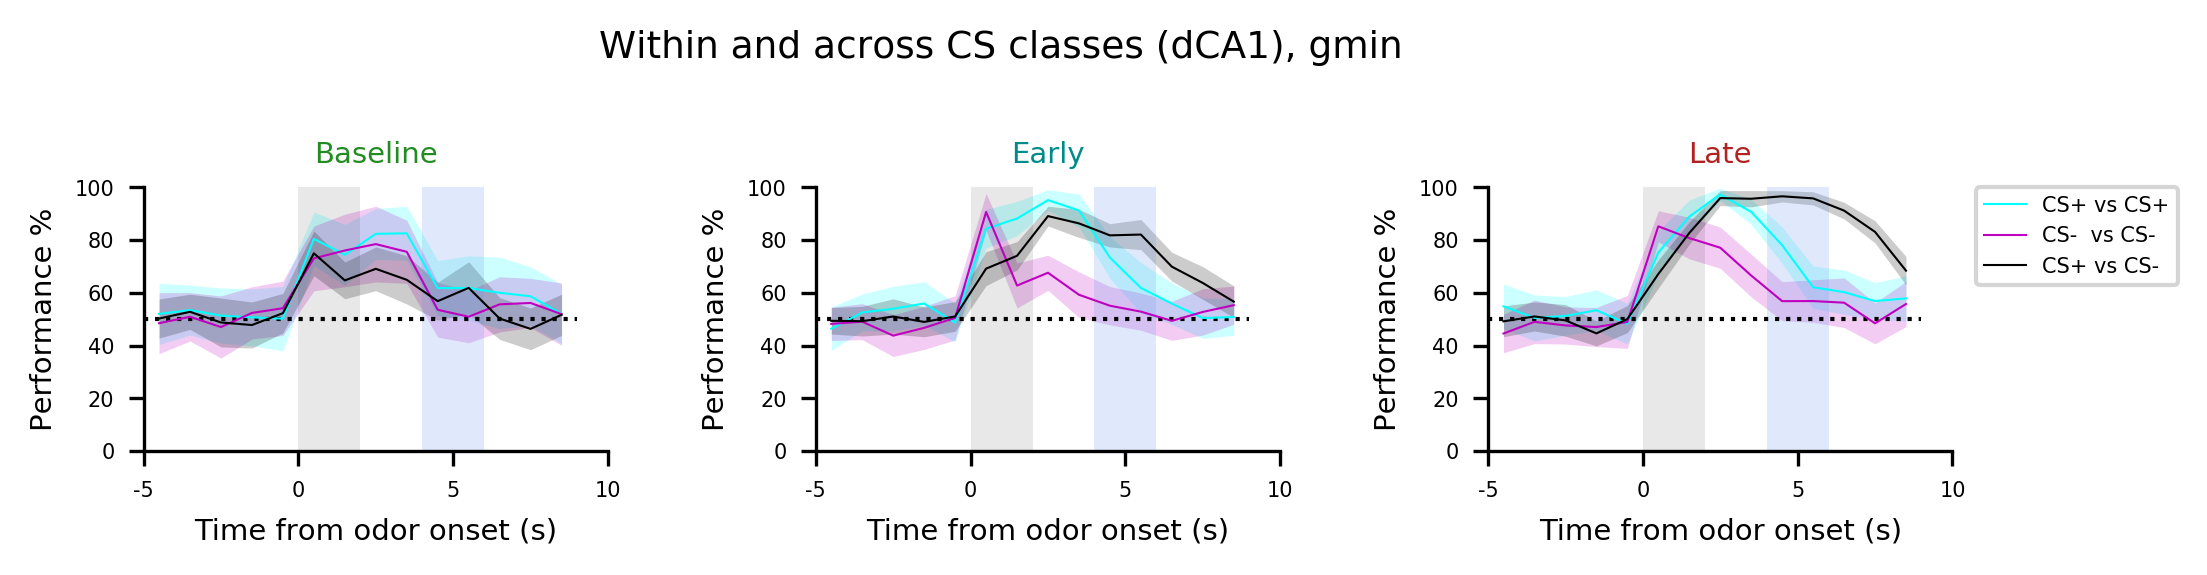

In [190]:
fig, ax = pl.subplots(1,3, figsize=(7, 1.9))

for comp,c,la in zip(['CS1vsCS2','CS3vsCS4','CSPvsCSM'],['cyan','m','k'],['CS+ vs CS+','CS-  vs CS-','CS+ vs CS-']):
    for r,sess in zip(range(3),sessions):
        ax[r].plot([(t-4.5) for t in range(14)], [(np.mean(eval("scores_tb_%s_gmin_%s[sess]"%(t,comp)))*100) for t in range(14)],
                   color=c, ls='-',lw=.5, zorder=19 ,ms=1,label=la)
        m = np.array([(np.mean(eval("scores_tb_%s_gmin_%s[sess]"%(t,comp)))*100) for t in range(14)])
        s = np.array([np.std(eval("scores_tb_%s_gmin_%s[sess]"%(t,comp)))*100 for t in range(14)])
        ax[r].fill_between([(t-4.5) for t in range(14)],m-s,m+s,alpha=0.2,color=c,linewidth=0)
for x in range (3):
    ax[x].set_ylim(0, 100)
    ax[x].set_xlim(-5, 9)
    ax[x].set_xticks(np.arange(-5,11, 5))
    ax[x].set_xticklabels(np.arange(-5,11, 5))
    ax[x].hlines(50, -5,9, color='k', lw=1, linestyles='dotted')
    ax[x].set_xlabel('Time from odor onset (s)')
    ax[x].set_ylabel('Performance %')
    pt.plot_period_bar(ax[x], 0, start_end=(0, 2), color='k', delta_y=100,alpha=.09)
    pt.plot_period_bar(ax[x], 0, start_end=(4, 6), color='cornflowerblue', delta_y=100, alpha=.2)
ax[0].set_title('Baseline', color=dark_co[0])
ax[1].set_title('Early', color = dark_co[1])
ax[2].set_title('Late', color = dark_co[2])
ax[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("Within and across CS classes (dCA1), gmin", fontsize=9, y=1.05)

fig.tight_layout(pad=2)


fig.savefig('../img/%s_3comp_horizontal_gmin.jpg'%NOTEBOOK_NAME)

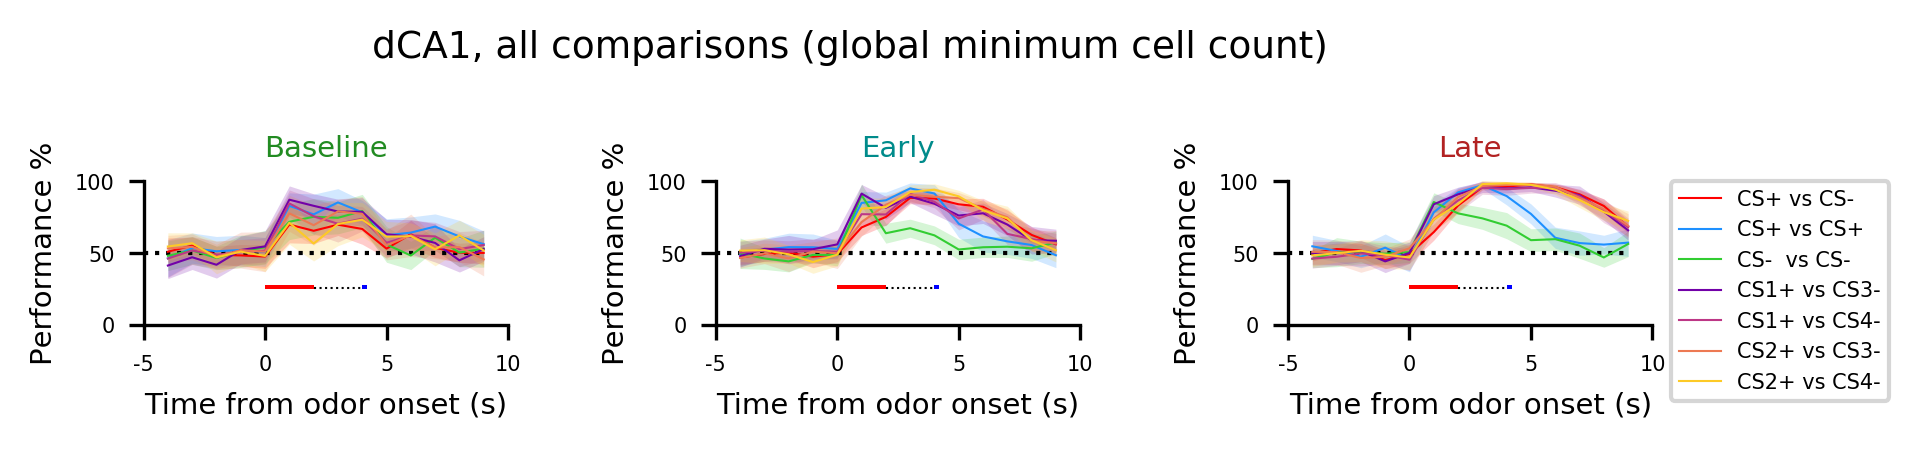

In [130]:
fig, ax = pl.subplots(1,3, figsize=(6, 1.5))

for comp,c,la in zip(comparisons,comp_colors,comp_labels):
    for r,sess in zip(range(3),sessions):
        ax[r].plot([(t-4) for t in range(14)], [(np.mean(eval("scores_tb_%s_gmin_%s[sess]"%(t,comp)))*100) for t in range(14)],
                   color=c, ls='-',lw=.5, zorder=19 ,ms=1,label=la)
        m = np.array([(np.mean(eval("scores_tb_%s_gmin_%s[sess]"%(t,comp)))*100) for t in range(14)])
        s = np.array([np.std(eval("scores_tb_%s_gmin_%s[sess]"%(t,comp)))*100 for t in range(14)])
        ax[r].fill_between([(t-4) for t in range(14)],m-s,m+s,alpha=0.2,color=c,linewidth=0)
for x in range (3):
    ax[x].set_ylim(0, 100)
    ax[x].set_xlim(-5, 9)
    ax[x].set_xticks(np.arange(-5,11, 5))
    ax[x].set_xticklabels(np.arange(-5,11, 5))
    ax[x].hlines(50, -5,9, color='k', lw=1, linestyles='dotted')
    ax[x].set_xlabel('Time from odor onset (s)')
    ax[x].set_ylabel('Performance %')
    pt.plot_period_bar(ax[x], 25, start_end=(0, 2), color='r', delta_y=3)
# pt.plot_period_bar(ax, 25, start_end=(2, 4), color='0.7', delta_y=2)
    pt.plot_period_bar(ax[x], 25, start_end=(4, 4.2), color='b', delta_y=3)
    ax[x].hlines(25+1, 2, 4, color='k', lw=0.5, linestyles='dotted')
ax[0].set_title('Baseline', color=dark_co[0])
ax[1].set_title('Early', color = dark_co[1])
ax[2].set_title('Late', color = dark_co[2])
ax[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("dCA1, all comparisons (global minimum cell count)", fontsize=9, y=1.05)

fig.tight_layout(pad=2)


#fig.savefig('../img/%s_CSPvsCSM_horizontal.pdf'%NOTEBOOK_NAME)

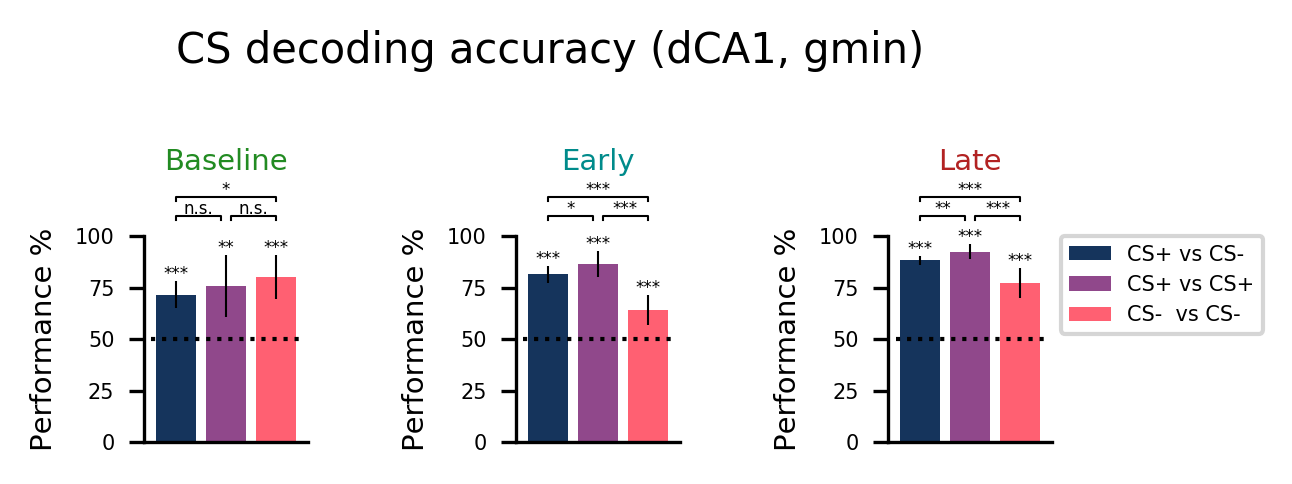

In [131]:
fig, ax = pl.subplots(1,3, figsize=(4, 1.7))
loops=15
for comp,c,la,i in zip(alt_comparisons[:3],alt2_colors[:3],comp_labels[:3],range(len(comparisons[:3]))):
    for r,sess in zip(range(3),sessions):
        ax[r].bar(i,np.mean(eval("scores_tb_6_gmin_%s[sess][:loops]"%(comp)))*100,width=.8, color=c,label=la)
        exec("s_%s_%s = np.array(np.std(scores_tb_6_gmin_%s[sess][:loops])*100)"%(comp,sess,comp))
        ax[r].errorbar(i,np.mean(eval("scores_tb_6_gmin_%s[sess][:loops]"%(comp)))*100,yerr=eval('s_%s_%s'%(comp,sess)),color='k')
for x in range (3):
    ax[x].set_ylim(0, 100)
    #ax[x].set_xlim(-5, 9)
    ax[x].hlines(50, -0.5,2.5, color='k', lw=1, linestyles='dotted')
    #ax[x].set_xlabel('Comparison')
    ax[x].set_ylabel('Performance %')
    ax[x].tick_params(axis='x',bottom='off',labelbottom='off')

pvs=[]
for r,sess in zip(range(3),sessions):
    pvs.append(add_significance(ax[r], eval("scores_tb_6_gmin_%s[sess]"%(alt_comparisons[0]))[:loops],
                eval("scores_tb_6_gmin_%s[sess]"%(alt_comparisons[1]))[:loops],0,.9,110))
    pvs.append(add_significance(ax[r], eval("scores_tb_6_gmin_%s[sess]"%(alt_comparisons[1]))[:loops],
                eval("scores_tb_6_gmin_%s[sess]"%(alt_comparisons[2]))[:loops],1.1,2,110))
    pvs.append(add_significance(ax[r], eval("scores_tb_6_gmin_%s[sess]"%(alt_comparisons[0]))[:loops],
                eval("scores_tb_6_gmin_%s[sess]"%(alt_comparisons[2]))[:loops],0,2,119))
for comp,i in zip(alt_comparisons[:3], range(len(alt_comparisons[:3]))):
    for r,sess in zip(range(3),sessions):
        pvs.append(sig_vs_chance(ax[r],eval("scores_tb_6_gmin_%s[sess]"%(comp))[:loops],.5,i,
               np.mean(eval("scores_tb_6_gmin_%s[sess][:loops]"%(comp)))*100+(eval("s_%s_%s"%(comp,sess)))+1,loops=loops,sig_func=None,colors='k'))

ax[0].set_title('Baseline', color=dark_co[0], y=1.2)
ax[1].set_title('Early', color = dark_co[1], y=1.2)
ax[2].set_title('Late', color = dark_co[2], y=1.2)
ax[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("CS decoding accuracy (dCA1, gmin)", fontsize=10, y=1)

fig.tight_layout(pad=2)


#fig.savefig('../img/%s_CSPvsCSM_horizontal.pdf'%NOTEBOOK_NAME)

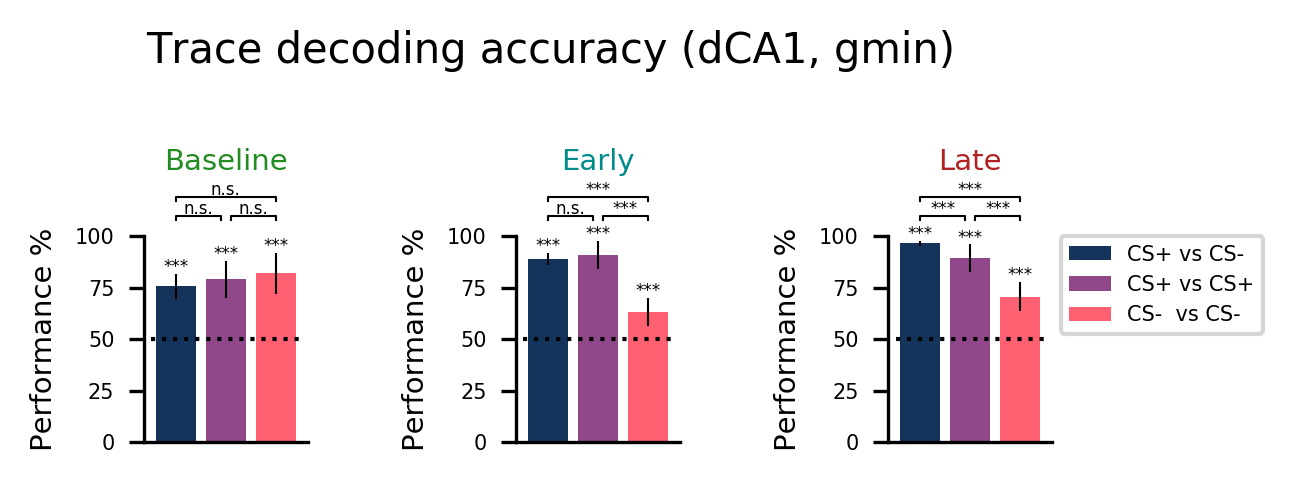

In [132]:
fig, ax = pl.subplots(1,3, figsize=(4, 1.7))
loops=15
for comp,c,la,i in zip(alt_comparisons[:3],alt2_colors[:3],comp_labels[:3],range(len(alt_comparisons[:3]))):
    for r,sess in zip(range(3),sessions):
        ax[r].bar(i,np.mean(eval("scores_tb_8_gmin_%s[sess][:loops]"%(comp)))*100,width=.8, color=c,label=la)
        exec("s_%s_%s = np.array(np.std(scores_tb_8_gmin_%s[sess][:loops])*100)"%(comp,sess,comp))
        ax[r].errorbar(i,np.mean(eval("scores_tb_8_gmin_%s[sess][:loops]"%(comp)))*100,yerr=eval('s_%s_%s'%(comp,sess)),color='k')
for x in range (3):
    ax[x].set_ylim(0, 100)
    #ax[x].set_xlim(-5, 9)
    ax[x].hlines(50, -0.5,2.5, color='k', lw=1, linestyles='dotted')
    #ax[x].set_xlabel('Comparison')
    ax[x].set_ylabel('Performance %')
    ax[x].tick_params(axis='x',bottom='off',labelbottom='off')

pvs=[]
for r,sess in zip(range(3),sessions):
    pvs.append(add_significance(ax[r], eval("scores_tb_8_gmin_%s[sess]"%(alt_comparisons[0]))[:loops],
                eval("scores_tb_8_gmin_%s[sess]"%(alt_comparisons[1]))[:loops],0,.9,110))
    pvs.append(add_significance(ax[r], eval("scores_tb_8_gmin_%s[sess]"%(alt_comparisons[1]))[:loops],
                eval("scores_tb_8_gmin_%s[sess]"%(alt_comparisons[2]))[:loops],1.1,2,110))
    pvs.append(add_significance(ax[r], eval("scores_tb_8_gmin_%s[sess]"%(alt_comparisons[0]))[:loops],
                eval("scores_tb_8_gmin_%s[sess]"%(alt_comparisons[2]))[:loops],0,2,119))
for comp,i in zip(alt_comparisons[:3], range(len(alt_comparisons[:3]))):
    for r,sess in zip(range(3),sessions):
        pvs.append(sig_vs_chance(ax[r],eval("scores_tb_8_gmin_%s[sess]"%(comp))[:loops],.5,i,
               np.mean(eval("scores_tb_8_gmin_%s[sess][:loops]"%(comp)))*100+(eval("s_%s_%s"%(comp,sess)))+1,loops=loops,sig_func=None,colors='k'))

ax[0].set_title('Baseline', color=dark_co[0], y=1.2)
ax[1].set_title('Early', color = dark_co[1], y=1.2)
ax[2].set_title('Late', color = dark_co[2], y=1.2)
ax[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("Trace decoding accuracy (dCA1, gmin)", fontsize=10, y=1)

fig.tight_layout(pad=2)


#fig.savefig('../img/%s_CSPvsCSM_horizontal.pdf'%NOTEBOOK_NAME)

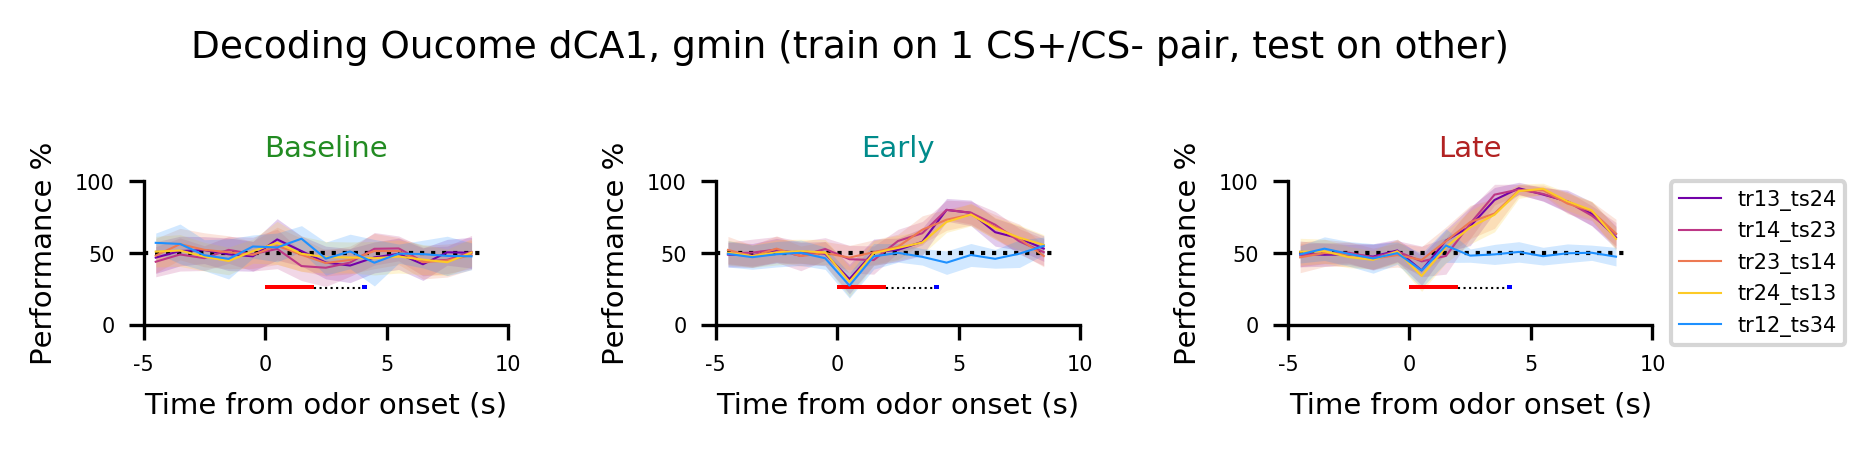

In [198]:
fig, ax = pl.subplots(1,3, figsize=(6, 1.5))

for comp,c,la in zip(['tr13_ts24','tr14_ts23','tr23_ts14','tr24_ts13','tr12_ts34'],tt_colors,['tr13_ts24','tr14_ts23','tr23_ts14','tr24_ts13','tr12_ts34']):
    for r,sess in zip(range(3),sessions):
        ax[r].plot([(t-4.5) for t in range(14)], [(np.mean(eval("scores_tb_%s_gmin_outcome_%s[sess]"%(t,comp)))*100) for t in range(14)],
                   color=c, ls='-',lw=.5, zorder=19 ,ms=1,label=la)
        m = np.array([(np.mean(eval("scores_tb_%s_gmin_outcome_%s[sess]"%(t,comp)))*100) for t in range(14)])
        s = np.array([np.std(eval("scores_tb_%s_gmin_outcome_%s[sess]"%(t,comp)))*100 for t in range(14)])
        ax[r].fill_between([(t-4.5) for t in range(14)],m-s,m+s,alpha=0.2,color=c,linewidth=0)
for x in range (3):
    ax[x].set_ylim(0, 100)
    ax[x].set_xlim(-5, 9)
    ax[x].set_xticks(np.arange(-5,11, 5))
    ax[x].set_xticklabels(np.arange(-5,11, 5))
    ax[x].hlines(50, -5,9, color='k', lw=1, linestyles='dotted')
    ax[x].set_xlabel('Time from odor onset (s)')
    ax[x].set_ylabel('Performance %')
    pt.plot_period_bar(ax[x], 25, start_end=(0, 2), color='r', delta_y=3)
# pt.plot_period_bar(ax, 25, start_end=(2, 4), color='0.7', delta_y=2)
    pt.plot_period_bar(ax[x], 25, start_end=(4, 4.2), color='b', delta_y=3)
    ax[x].hlines(25+1, 2, 4, color='k', lw=0.5, linestyles='dotted')
ax[0].set_title('Baseline', color=dark_co[0])
ax[1].set_title('Early', color = dark_co[1])
ax[2].set_title('Late', color = dark_co[2])
ax[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("Decoding Oucome dCA1, gmin (train on 1 CS+/CS- pair, test on other)", fontsize=9, y=1.05)

fig.tight_layout(pad=2)


#fig.savefig('../img/%s_CSPvsCSM_horizontal.pdf'%NOTEBOOK_NAME)

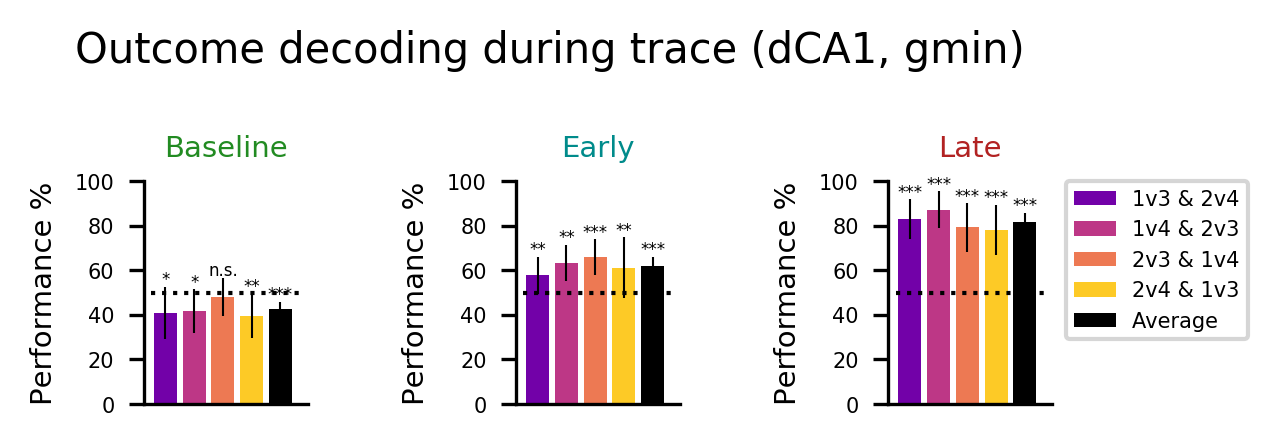

In [167]:
fig, ax = pl.subplots(1,3, figsize=(4, 1.5))
loops=15
tt_comparisons =['tr13_ts24','tr14_ts23','tr23_ts14','tr24_ts13','averaged']
for comp,c,la,i in zip(tt_comparisons,tt_colors_k,['1v3 & 2v4','1v4 & 2v3','2v3 & 1v4','2v4 & 1v3','Average'],range(5)):
    for r,sess in zip(range(3),sessions):
        ax[r].bar(i,np.mean(eval("scores_tb_8_gmin_outcome_%s[sess][:loops]"%(comp)))*100,width=.8, color=c,label=la)
        exec("s_%s_%s = np.array(np.std(scores_tb_8_gmin_outcome_%s[sess][:loops])*100)"%(comp,sess,comp))
        ax[r].errorbar(i,np.mean(eval("scores_tb_8_gmin_outcome_%s[sess][:loops]"%(comp)))*100,yerr=eval('s_%s_%s'%(comp,sess)),color='k')
for x in range (3):
    ax[x].set_ylim(0, 100)
    #ax[x].set_xlim(-5, 9)
    ax[x].hlines(50, -0.5,4.7, color='k', lw=1, linestyles='dotted')
    #ax[x].set_xlabel('Comparison')
    ax[x].set_ylabel('Performance %')
    ax[x].tick_params(axis='x',bottom='off',labelbottom='off')

pvs=[]
#for r,sess in zip(range(3),sessions):
#    pvs.append(add_significance(ax[r], eval("scores_tb_8_gmin_outcome_%s[sess]"%(tt_comparisons[0]))[:loops],
#                eval("scores_tb_8_gmin_outcome_%s[sess]"%(tt_comparisons[1]))[:loops],0,.9,110))
#    pvs.append(add_significance(ax[r], eval("scores_tb_8_gmin_outcome_%s[sess]"%(tt_comparisons[1]))[:loops],
#                eval("scores_tb_8_gmin_outcome_%s[sess]"%(tt_comparisons[2]))[:loops],1.1,2,110))
#    pvs.append(add_significance(ax[r], eval("scores_tb_8_gmin_outcome_%s[sess]"%(tt_comparisons[0]))[:loops],
#                eval("scores_tb_8_gmin_outcome_%s[sess]"%(tt_comparisons[2]))[:loops],0,2,119))
for comp,i in zip(tt_comparisons, range(len(tt_comparisons))):
    for r,sess in zip(range(3),sessions):
        pvs.append(sig_vs_chance(ax[r],eval("scores_tb_8_gmin_outcome_%s[sess]"%(comp))[:loops],.5,i,
               np.mean(eval("scores_tb_8_gmin_outcome_%s[sess][:loops]"%(comp)))*100+(eval("s_%s_%s"%(comp,sess)))+1,loops=loops,sig_func=None,colors='k'))

ax[0].set_title('Baseline', color=dark_co[0], y=1.)
ax[1].set_title('Early', color = dark_co[1], y=1.)
ax[2].set_title('Late', color = dark_co[2], y=1.)
ax[2].legend(bbox_to_anchor=(1.08, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("Outcome decoding during trace (dCA1, gmin)", fontsize=10, y=1.05)

fig.tight_layout(pad=2)


#fig.savefig('../img/%s_CSPvsCSM_horizontal.pdf'%NOTEBOOK_NAME)

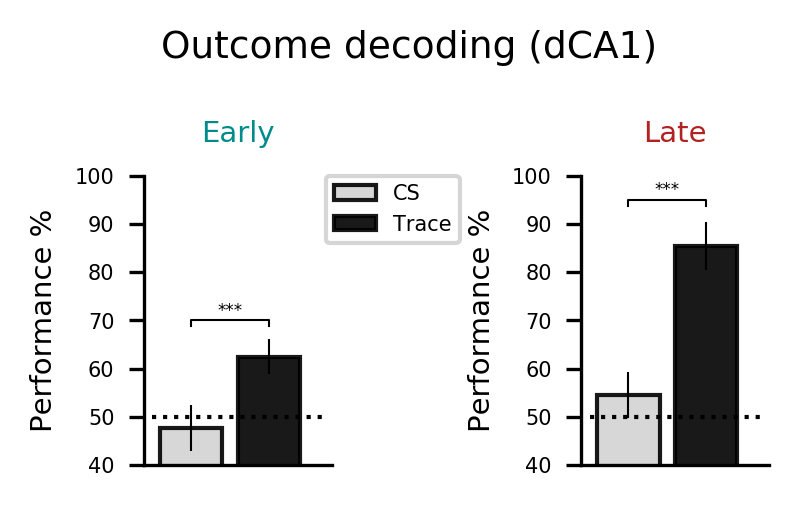

In [207]:
fig, ax = pl.subplots(1,2, figsize=(2.8, 1.5))
loops=15
tt_comparisons =['tr13_ts24','tr14_ts23','tr23_ts14','tr24_ts13','averaged']
for i,k,c,la in zip(range(2),[6,8],['lightgrey','k'],['CS','Trace']):
    for r,sess in zip(range(2),sessions[1:]):
        ax[r].bar(i,np.mean(eval("scores_tb_%s_gmin_outcome_averaged[sess][:loops]"%(k)))*100,width=.8,
                  color=c,alpha=.9,label=la,edgecolor='k')
        exec("s_%s_%s = np.array(np.std(scores_tb_%s_gmin_outcome_averaged[sess][:loops])*100)"%(k,sess,k))
        ax[r].errorbar(i,np.mean(eval("scores_tb_%s_gmin_outcome_averaged[sess][:loops]"%(k)))*100,yerr=eval('s_%s_%s'%(k,sess)),color='k')
for x in range (2):
    ax[x].set_ylim(40, 100)
    #ax[x].set_xlim(-5, 9)
    ax[x].hlines(50, -0.5,1.7, color='k', lw=1, linestyles='dotted')
    #ax[x].set_xlabel('Comparison')
    ax[x].set_ylabel('Performance %')
    ax[x].tick_params(axis='x',bottom='off',labelbottom='off')

pvs=[]
for r,sess,q in zip(range(2),sessions[1:],[70,95]):
    pvs.append(add_significance(ax[r], scores_tb_6_gmin_outcome_averaged[sess][:loops],
                scores_tb_8_gmin_outcome_averaged[sess][:loops],0,1,q))
#for i,k,c,la in zip(range(2),[6,8],['lightgrey','k'],['CS','Trace']):
#    for r,sess in zip(range(2),sessions[1:]):
#        pvs.append(sig_vs_chance(ax[r],eval("scores_tb_%s_gmin_outcome_averaged[sess][:loops]"%(k))[:loops],.5,i,
#               np.mean(eval("scores_tb_%s_gmin_outcome_averaged[sess][:loops]"%(k)))*100+(eval("s_%s_%s"%(k,sess)))+1,loops=loops,sig_func=None,colors='k'))

#ax[0].set_title('Baseline', color=dark_co[0], y=1.)
ax[0].set_title('Early', color = dark_co[1], y=1.03)
ax[1].set_title('Late', color = dark_co[2], y=1.03)
ax[0].legend(bbox_to_anchor=(.97, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("Outcome decoding (dCA1)", fontsize=9, y=1.1)

fig.tight_layout(w_pad=3)


fig.savefig('../img/%s_CSvsTr_outcome_decoding.pdf'%NOTEBOOK_NAME)

# And now for decoding across time bins! (using distinct trials for train/test)

In [136]:
def combine_train_test_patterns_across_tbs(patterns_train, patterns_test, labels, train_test_split=0.5, classes=None, n_cells=None,
                                relabel=None, relabel_test=None):

    if classes is None:
        classes = [0, 1]

    which_train = {}
    which_test = {}
    for ani in patterns_train.keys():
        which_trains = []
        which_tests = []
        for l in classes:
            if l>=0:
                wt = np.random.permutation(np.where(labels[ani]==l)[0])
                if train_test_split<1:
                    wT = wt[:int(len(wt)*train_test_split)]
                    which_trains.append(wt[int(len(wt)*train_test_split):])
                    which_tests.append(wT)
                else:
                    which_trains.append(wt)
        which_train[ani] = np.concatenate(which_trains)
        if train_test_split<1:
            which_test[ani] = np.concatenate(which_tests)
    
    patterns_t = patterns_train.copy()
    labels_t = labels.copy()
    for ani in patterns_train.keys():
        patterns_t[ani] = patterns_train[ani][which_train[ani]]
        labels_t[ani] = labels[ani][which_train[ani]]
    patterns_comb_train, labels_comb_ = ut.combine_patterns(patterns_t, labels_t, classes=classes)
        
    if train_test_split<1:
        patterns_T = patterns_test.copy()
        labels_T = labels.copy()
        for ani in patterns_test.keys():
            patterns_T[ani] = patterns_test[ani][which_test[ani]]
            labels_T[ani] = labels[ani][which_test[ani]]
        patterns_comb_test, labels_comb_test_ = ut.combine_patterns(patterns_T, labels_T, classes=classes)
    else:
        patterns_comb_test = None
    
    if relabel is not None:
        labels_comb = np.r_[[relabel[l] for l in labels_comb_]]
    else:
        labels_comb = labels_comb_
    
    if train_test_split<1:
        if relabel_test is not None:
            labels_comb_test = np.r_[[relabel_test[l] for l in labels_comb_test_]]
        else:
            if relabel is not None:
                labels_comb_test = np.r_[[relabel[l] for l in labels_comb_test_]]
            else:
                labels_comb_test = labels_comb_test_
    elif train_test_split == 1:
        labels_comb_test = None
    
    
    if n_cells is None:
        which_cells = [True]*patterns_comb_train.shape[1]
    else:
        which_cells = np.random.permutation(range(patterns_comb_train.shape[1]))[:n_cells]
     
    patterns_comb_train = patterns_comb_train[:, which_cells]
    patterns_comb_test = patterns_comb_test[:, which_cells] if train_test_split<1 else patterns_comb_test
    
    if train_test_split<1:
        return (patterns_comb_train[labels_comb>=0], labels_comb[labels_comb>=0],
                patterns_comb_test[labels_comb_test>=0], labels_comb_test[labels_comb_test>=0])
    if train_test_split == 1:
        return (patterns_comb_train[labels_comb>=0], labels_comb[labels_comb>=0],
                None,None)

def do_test_across_tbs(patterns_train, patterns_test, labels, **args):
    x, y, xT, yT = combine_train_test_patterns_across_tbs(patterns_train, patterns_test, labels, train_test_split=0.5, **args)
    decoder.fit(x, y)
    return decoder.score(xT, yT)

### running the cell below will take over an hour!

In [137]:
%%time
n_loops=20
for t in range (14):
    for c in range (14):
        for comp,relab in zip(comparisons,relabels):
            exec('scores_tb_%s_VS_%s_%s = {}'%(t,c,comp))
            for sess in sessions:
                print sess,t,c,comp,
                print " ",
                eval('scores_tb_%s_VS_%s_%s'%(t,c,comp))[sess] = np.r_[[do_test_across_tbs(eval('patterns_tb_%s_%s'%(t,sess)),
                      eval('patterns_tb_%s_%s'%(c,sess)),eval('labels_%s'%sess),classes=range(1,5),
                      n_cells=None, relabel=relab) for i in range(n_loops)]]

expo 0 0 CSPvsCSM   pre 0 0 CSPvsCSM   post 0 0 CSPvsCSM   expo 0 0 CS1vsCS2   pre 0 0 CS1vsCS2   post 0 0 CS1vsCS2   expo 0 0 CS3vsCS4   pre 0 0 CS3vsCS4   post 0 0 CS3vsCS4   expo 0 0 CS1vsCS3   pre 0 0 CS1vsCS3   post 0 0 CS1vsCS3   expo 0 0 CS1vsCS4   pre 0 0 CS1vsCS4   post 0 0 CS1vsCS4   expo 0 0 CS2vsCS3   pre 0 0 CS2vsCS3   post 0 0 CS2vsCS3   expo 0 0 CS2vsCS4   pre 0 0 CS2vsCS4   post 0 0 CS2vsCS4   expo 0 1 CSPvsCSM   pre 0 1 CSPvsCSM   post 0 1 CSPvsCSM   expo 0 1 CS1vsCS2   pre 0 1 CS1vsCS2   post 0 1 CS1vsCS2   expo 0 1 CS3vsCS4   pre 0 1 CS3vsCS4   post 0 1 CS3vsCS4   expo 0 1 CS1vsCS3   pre 0 1 CS1vsCS3   post 0 1 CS1vsCS3   expo 0 1 CS1vsCS4   pre 0 1 CS1vsCS4   post 0 1 CS1vsCS4   expo 0 1 CS2vsCS3   pre 0 1 CS2vsCS3   post 0 1 CS2vsCS3   expo 0 1 CS2vsCS4   pre 0 1 CS2vsCS4   post 0 1 CS2vsCS4   expo 0 2 CSPvsCSM   pre 0 2 CSPvsCSM   post 0 2 CSPvsCSM   expo 0 2 CS1vsCS2   pre 0 2 CS1vsCS2   post 0 2 CS1vsCS2   expo 0 2 CS3vsCS4   pre 0 2 CS3vsCS4   post 0 2 CS3vsCS4

In [138]:
%%time
tt_relabels = [{1:0,2:-1,3:1,4:-1}, {1:0,2:-1,3:-1,4:1}, {1:-1,2:0,3:1,4:-1}, {1:-1,2:0,3:-1,4:1}]
tt_relabels_test = [{1:-1,2:0,3:-1,4:1}, {1:-1,2:0,3:1,4:-1}, {1:0,2:-1,3:-1,4:1}, {1:0,2:-1,3:1,4:-1}]
tt_pairs = ['tr13_ts24','tr14_ts23','tr23_ts14','tr24_ts13']
n_loops=20
for t in range (14):
    for c in range (14):
        for re, rete, it in zip(tt_relabels,tt_relabels_test,tt_pairs):
            exec('scores_tb_%s_VS_%s_outcome_%s = {}'%(t,c,it))
            for sess in sessions:
                print sess,t,c,it,
                print " ",
                eval('scores_tb_%s_VS_%s_outcome_%s'%(t,c,it))[sess] = np.r_[[do_test_across_tbs(eval('patterns_tb_%s_%s'%(t,sess)),
                      eval('patterns_tb_%s_%s'%(c,sess)),eval('labels_%s'%sess),classes=range(1,5),
                      n_cells=None, relabel=re, relabel_test=rete) for i in range(n_loops)]]

expo 0 0 tr13_ts24   pre 0 0 tr13_ts24   post 0 0 tr13_ts24   expo 0 0 tr14_ts23   pre 0 0 tr14_ts23   post 0 0 tr14_ts23   expo 0 0 tr23_ts14   pre 0 0 tr23_ts14   post 0 0 tr23_ts14   expo 0 0 tr24_ts13   pre 0 0 tr24_ts13   post 0 0 tr24_ts13   expo 0 1 tr13_ts24   pre 0 1 tr13_ts24   post 0 1 tr13_ts24   expo 0 1 tr14_ts23   pre 0 1 tr14_ts23   post 0 1 tr14_ts23   expo 0 1 tr23_ts14   pre 0 1 tr23_ts14   post 0 1 tr23_ts14   expo 0 1 tr24_ts13   pre 0 1 tr24_ts13   post 0 1 tr24_ts13   expo 0 2 tr13_ts24   pre 0 2 tr13_ts24   post 0 2 tr13_ts24   expo 0 2 tr14_ts23   pre 0 2 tr14_ts23   post 0 2 tr14_ts23   expo 0 2 tr23_ts14   pre 0 2 tr23_ts14   post 0 2 tr23_ts14   expo 0 2 tr24_ts13   pre 0 2 tr24_ts13   post 0 2 tr24_ts13   expo 0 3 tr13_ts24   pre 0 3 tr13_ts24   post 0 3 tr13_ts24   expo 0 3 tr14_ts23   pre 0 3 tr14_ts23   post 0 3 tr14_ts23   expo 0 3 tr23_ts14   pre 0 3 tr23_ts14   post 0 3 tr23_ts14   expo 0 3 tr24_ts13   pre 0 3 tr24_ts13   post 0 3 tr24_ts13   expo 0 4

In [139]:
#for outcome endoding, average each idividual comparison
for t in range(14):
    for c in range(14):
        exec("scores_tb_%s_VS_%s_outcome_averaged = {}"%(t,c))
        for sess in sessions:
            exec("scores_tb_%s_VS_%s_outcome_averaged[sess] = np.mean((scores_tb_%s_VS_%s_outcome_tr13_ts24[sess],\
                 scores_tb_%s_VS_%s_outcome_tr14_ts23[sess],scores_tb_%s_VS_%s_outcome_tr23_ts14[sess],\
                 scores_tb_%s_VS_%s_outcome_tr24_ts13[sess]),axis=0)"%(t,c,t,c,t,c,t,c,t,c))

In [140]:
#for outcome endoding, average each idividual comparison
for t in range(14):
    for c in range(14):
        exec("scores_tb_%s_VS_%s_CSPvsCSM_averaged = {}"%(t,c))
        for sess in sessions:
            exec("scores_tb_%s_VS_%s_CSPvsCSM_averaged[sess] = np.mean((scores_tb_%s_VS_%s_CS1vsCS3[sess],\
                 scores_tb_%s_VS_%s_CS1vsCS4[sess],scores_tb_%s_VS_%s_CS2vsCS3[sess],\
                 scores_tb_%s_VS_%s_CS2vsCS4[sess]),axis=0)"%(t,c,t,c,t,c,t,c,t,c))

In [141]:
comparisons_av = ['CSPvsCSM','CS1vsCS2','CS3vsCS4','CS1vsCS3','CS1vsCS4','CS2vsCS3','CS2vsCS4','CSPvsCSM_averaged']
comp_labels_av = ['CS+ vs CS-','CS+ vs CS+','CS-  vs CS-','CS1+ vs CS3-','CS1+ vs CS4-','CS2+ vs CS3-','CS2+ vs CS4-','CS+ vs CS- avg']

In [142]:
for t in range (14):
    for comp in comparisons_av:
        exec('distinct%s_%s = {}'%(t,comp))
for sess in sessions:
    for t in range (14):
        for comp in comparisons_av:
            exec("distinct%s_%s['%s'] = []"%(t,comp,sess))
            for c in range (14):
                eval('distinct%s_%s'%(t,comp))[sess].insert(c,(eval('scores_tb_%s_VS_%s_%s'%(t,c,comp))[sess].mean()))

In [143]:
for t in range (14):
    for comp in comparisons_av:
        exec('distinct%s_%s_wilcox = {}'%(t,comp))
for sess in sessions:
    for t in range (14):
        for comp in comparisons_av:
            exec("distinct%s_%s_wilcox[sess] = []"%(t,comp))
            for c in range (14):
                exec("subtracted = [x-0.5 for x in scores_tb_%s_VS_%s_%s[sess]]"%(t,c,comp))
                eval('distinct%s_%s_wilcox'%(t,comp))[sess].insert(c, sstats.wilcoxon(subtracted[:15]))
            for x,i in zip(eval('distinct%s_%s_wilcox'%(t,comp))[sess],range(len(eval('distinct%s_%s_wilcox'%(t,comp))[sess]))):
                exec("distinct%s_%s_wilcox[sess][i] = x[-1]"%(t,comp)) #only take p-values

In [144]:
for comp in comparisons_av:
    exec("distinct_%s={}"%comp)
    for sess in sessions:
        exec("distinct_%s[sess]=(distinct0_%s[sess], distinct1_%s[sess], distinct2_%s[sess], distinct3_%s[sess], distinct4_%s[sess], distinct5_%s[sess], distinct6_%s[sess], distinct7_%s[sess],\
              distinct8_%s[sess], distinct9_%s[sess], distinct10_%s[sess], distinct11_%s[sess], distinct12_%s[sess],\
              distinct13_%s[sess])"%(comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp))
        np.array([eval("distinct_%s[sess]"%comp)])

In [145]:
for comp in comparisons_av:
    exec("distinct_%s_wilcox={}"%comp)
    for sess in sessions:
        exec("distinct_%s_wilcox[sess]=(distinct0_%s_wilcox[sess], distinct1_%s_wilcox[sess], distinct2_%s_wilcox[sess], distinct3_%s_wilcox[sess], distinct4_%s_wilcox[sess], distinct5_%s_wilcox[sess], distinct6_%s_wilcox[sess], distinct7_%s_wilcox[sess],\
              distinct8_%s_wilcox[sess], distinct9_%s_wilcox[sess], distinct10_%s_wilcox[sess], distinct11_%s_wilcox[sess], distinct12_%s_wilcox[sess],\
              distinct13_%s_wilcox[sess])"%(comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp))
        np.array([eval("distinct_%s_wilcox[sess]"%comp)])

In [146]:
session_labels = ('Baseline','Early','Late')

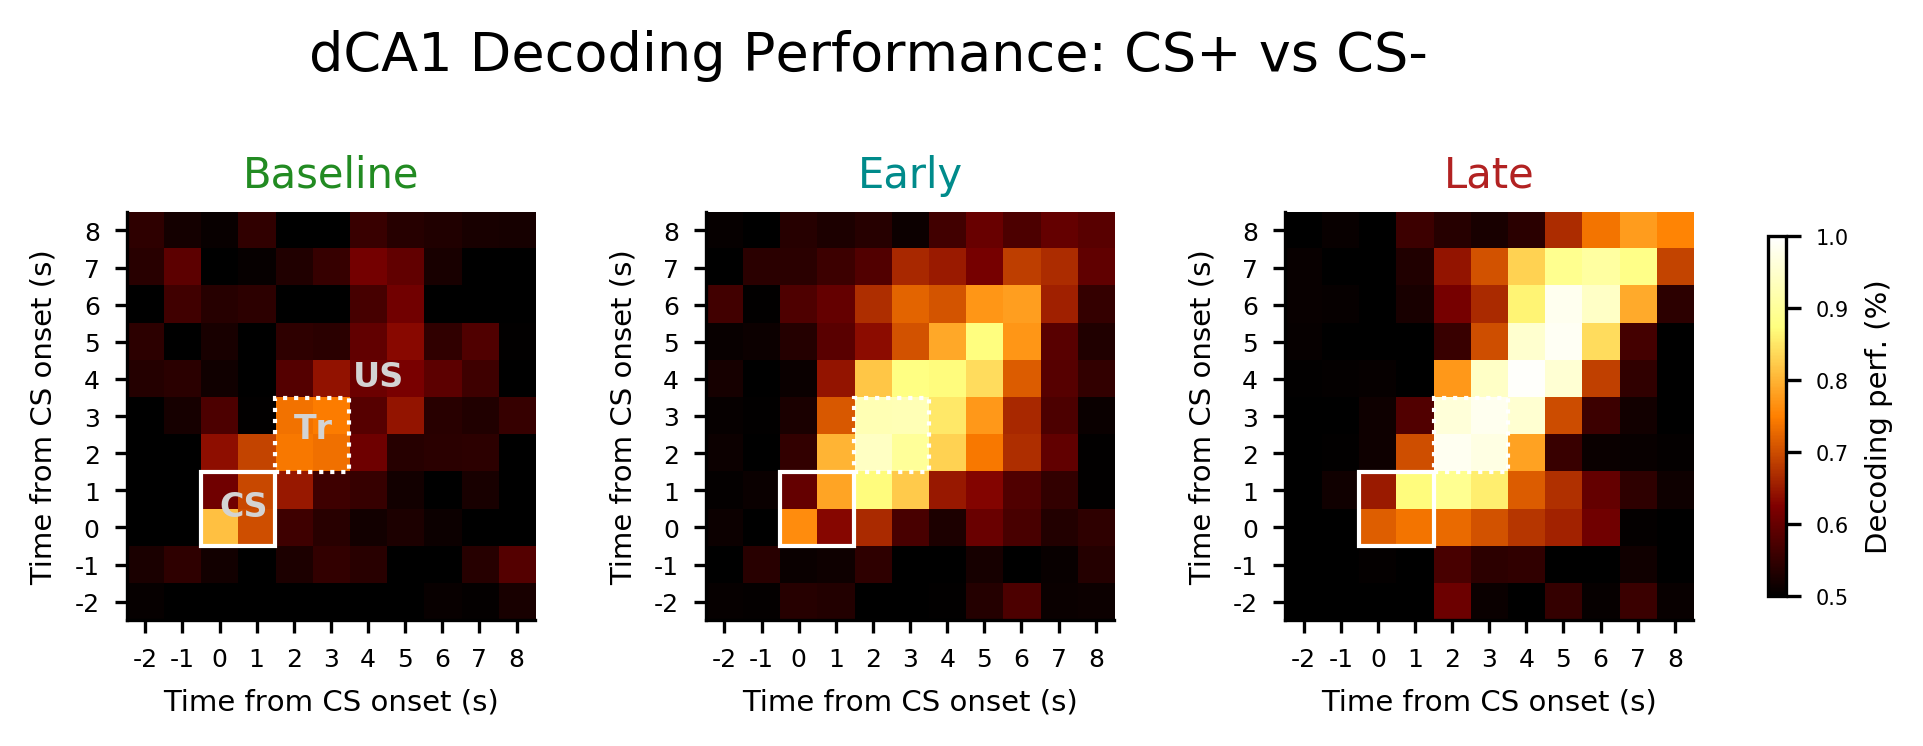

In [147]:
fig, ax = pl.subplots(1, 3, figsize=(6, 3))#, sharex=True, sharey=True)
vmin=0.5
vmax=1
for sess,x in zip(sessions,range(len(sessions))):
    im = ax[x].imshow(distinct_CSPvsCSM[sess],origin='lower', interpolation='nearest', vmin=vmin, vmax=vmax,cmap='afmhot')
for x in range (3):
    ax[x].set_xticks(range(14))
    ax[x].set_yticks(range(14))
    ax[x].set_ylim(2.5, 13.5)
    ax[x].set_xlim(2.5,13.5)
    ax[x].set_xticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_yticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_ylabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_xlabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_title(session_labels[x],fontsize=10,color=dark_co[x])
    ax[x].tick_params(length=3)

import matplotlib.patches as patches
for x in range(3):
# Create a Rectangle patch
    CS = patches.Rectangle((4.5,4.5),2,2,linewidth=1,edgecolor='w',facecolor='none')
    Tr = patches.Rectangle((6.5,6.5),2,2,linewidth=1,edgecolor='w',facecolor='none',linestyle=':')
# Add the patch to the Axes
    ax[x].add_patch(CS)
    ax[x].add_patch(Tr)

ax[0].text(5,5.3,"CS",fontsize=8, weight='bold', color='lightgray')
ax[0].text(7,7.4,"Tr",fontsize=8, weight='bold', color='lightgray')
ax[0].text(8.6,8.8,"US",fontsize=8, weight='bold', color='lightgray')

pl.suptitle('dCA1 Decoding Performance: CS+ vs CS-',y=.93,fontsize=13)

cax = fig.add_axes([1,0.3, 0.01, 0.4])
fig.colorbar(im, cax=cax, label='Decoding perf. (%)')
fig.tight_layout(pad=1.5)
#fig.savefig('../img/%s_gmin_across_bins_distinct_horizontal.pdf'%NOTEBOOK_NAME)

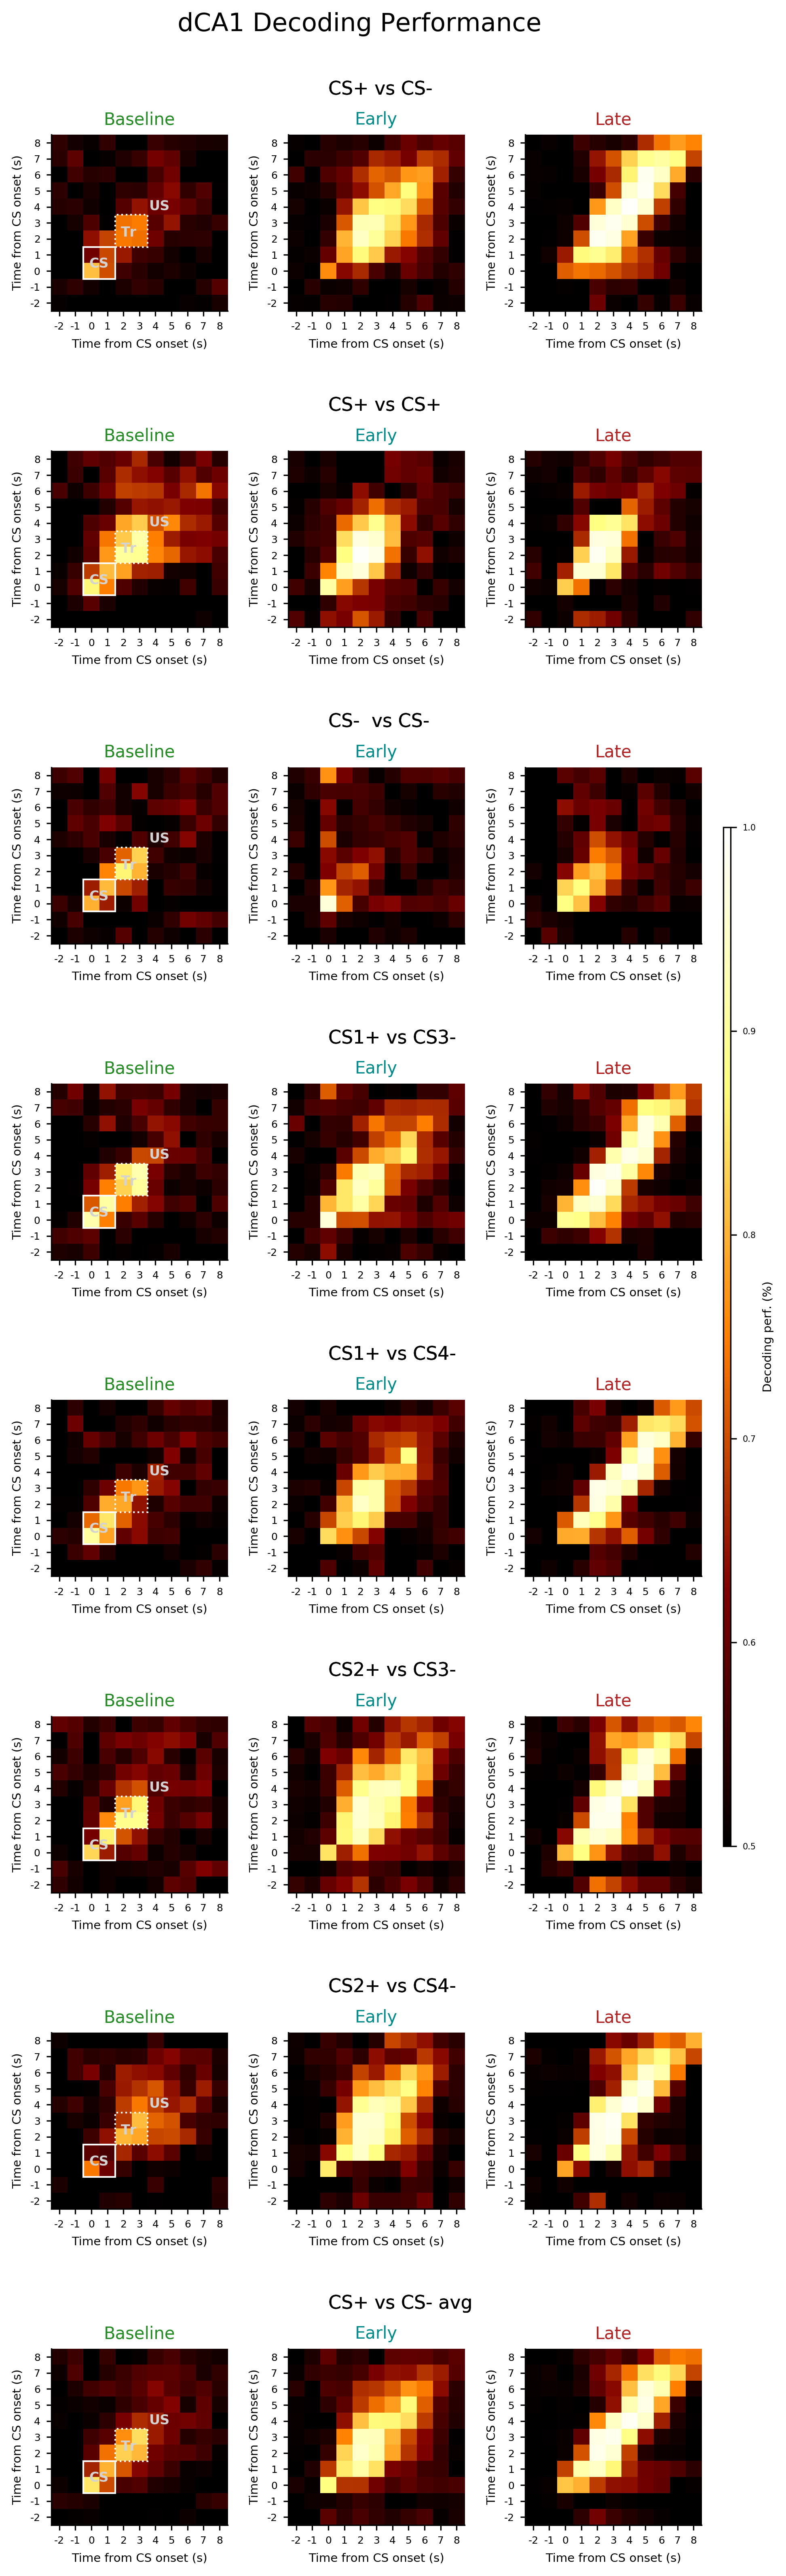

In [148]:
fig, ax = pl.subplots(8, 3, figsize=(6, 21))#, sharex=True, sharey=True)
vmin=0.5
vmax=1
for sess,x in zip(sessions,range(len(sessions))):
    for comp,i in zip(comparisons_av,range(len(comparisons_av))):
        im = ax[i][x].imshow(eval("distinct_%s[sess]"%comp),origin='lower', interpolation='nearest', vmin=vmin, vmax=vmax,cmap='afmhot')
        ax[i][x].set_xticks(range(14))
        ax[i][x].set_yticks(range(14))
        ax[i][x].set_ylim(2.5,13.5)
        ax[i][x].set_xlim(2.5,13.5)
        ax[i][x].set_xticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
        ax[i][x].set_yticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
        ax[i][x].set_ylabel('Time from CS onset (s)', fontsize=7)
        ax[i][x].set_xlabel('Time from CS onset (s)', fontsize=7)
        ax[i][x].set_title(session_labels[x],fontsize=10,color=dark_co[x])
        ax[i][x].tick_params(length=3)
        ax[i][1].text(5,16,comp_labels_av[i],fontsize=11)

import matplotlib.patches as patches
for i in range(8):
# Create a Rectangle patch
    CS = patches.Rectangle((4.5,4.5),2,2,linewidth=1,edgecolor='w',facecolor='none')
    Tr = patches.Rectangle((6.5,6.5),2,2,linewidth=1,edgecolor='w',facecolor='none',linestyle=':')
# Add the patch to the Axes
    ax[i][0].add_patch(CS)
    ax[i][0].add_patch(Tr)
    ax[i][0].text(4.85,5.2,"CS",fontsize=8, weight='bold', color='lightgray')
    ax[i][0].text(6.85,7.15,"Tr",fontsize=8, weight='bold', color='lightgray')
    ax[i][0].text(8.6,8.8,"US",fontsize=8, weight='bold', color='lightgray')

pl.suptitle('dCA1 Decoding Performance',y=1.02,fontsize=15)

cax = fig.add_axes([1,0.3, 0.01, 0.4])
fig.colorbar(im, cax=cax, label='Decoding perf. (%)')
fig.tight_layout(pad=1)
#fig.savefig('../img/%s_gmin_across_bins_distinct_horizontal.pdf'%NOTEBOOK_NAME)

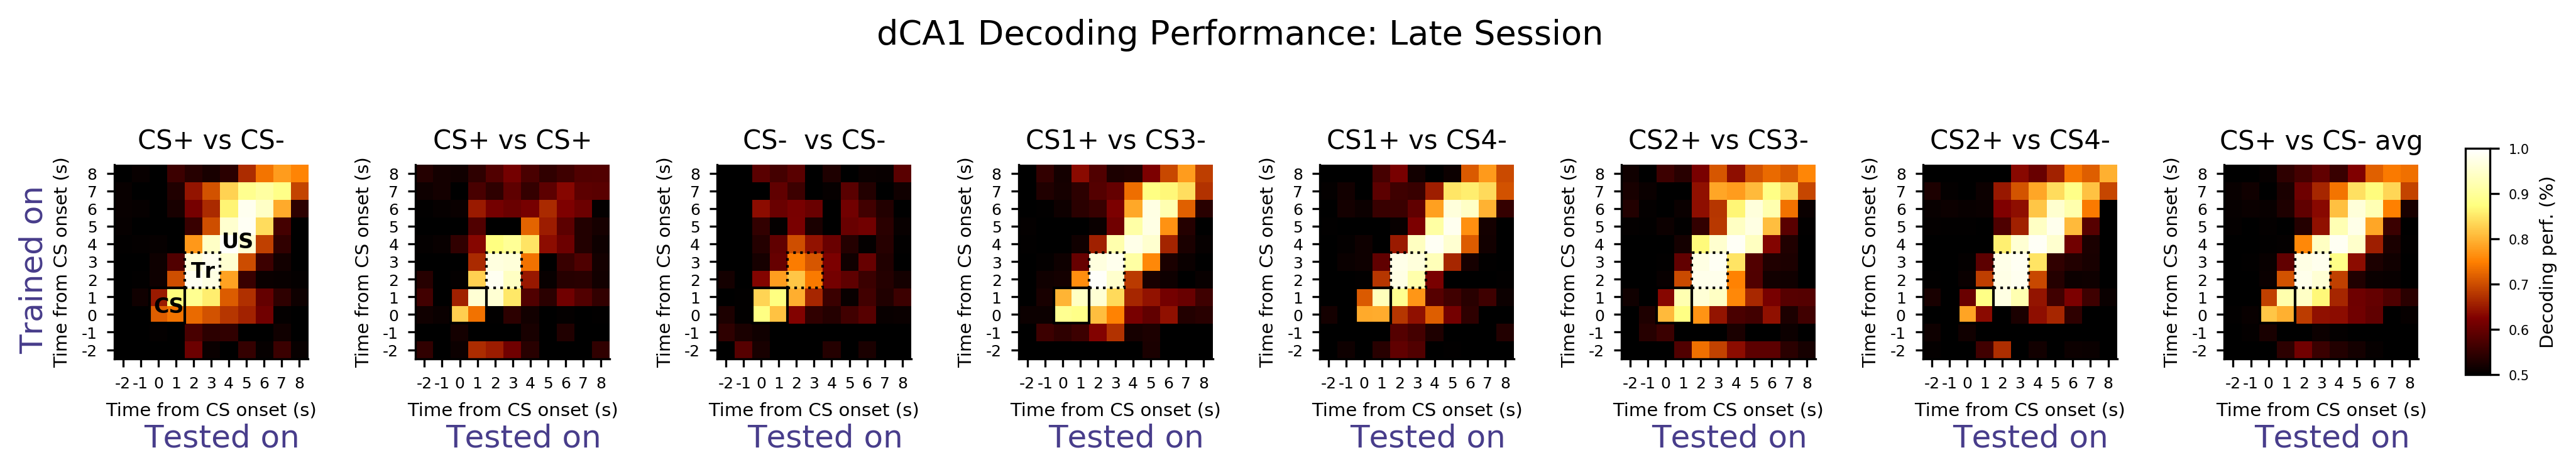

In [149]:
fig, ax = pl.subplots(1, 8, figsize=(13, 3))#, sharex=True, sharey=True)
vmin=0.5
vmax=1
for comp,x in zip(comparisons_av,range(len(comparisons_av))):
    im = ax[x].imshow(eval("distinct_%s['post']"%comp),origin='lower', interpolation='nearest', vmin=vmin, vmax=vmax,cmap='afmhot')
for x in range (8):
    ax[x].set_xticks(range(14))
    ax[x].set_yticks(range(14))
    ax[x].set_ylim(2.5, 13.5)
    ax[x].set_xlim(2.5,13.5)
    ax[x].set_xticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_yticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_ylabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_xlabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_title(comp_labels_av[x],fontsize=10,color='k')
    ax[x].tick_params(length=3)

import matplotlib.patches as patches
for x in range(8):
# Create a Rectangle patch
    CS = patches.Rectangle((4.5,4.5),2,2,linewidth=1,edgecolor='k',facecolor='none')
    Tr = patches.Rectangle((6.5,6.5),2,2,linewidth=1,edgecolor='k',facecolor='none',linestyle=':')
# Add the patch to the Axes
    ax[x].add_patch(CS)
    ax[x].add_patch(Tr)
    ax[x].text(4.2,-2.5,'Tested on',fontsize=12,color='darkslateblue')

ax[0].text(-2.9,11,'Trained on',rotation=90,fontsize=12,color='darkslateblue')
ax[0].text(4.75,5.1,"CS",fontsize=8, weight='bold', color='k')
ax[0].text(6.85,7.1,"Tr",fontsize=8, weight='bold', color='k')
ax[0].text(8.6,8.8,"US",fontsize=8, weight='bold', color='k')

pl.suptitle('dCA1 Decoding Performance: Late Session',y=.93,fontsize=13)

cax = fig.add_axes([1,0.3, 0.01, 0.4])
fig.colorbar(im, cax=cax, label='Decoding perf. (%)')
fig.tight_layout(pad=1.5)
fig.savefig('../img/%s_across_bins_LATE.jpg'%NOTEBOOK_NAME)

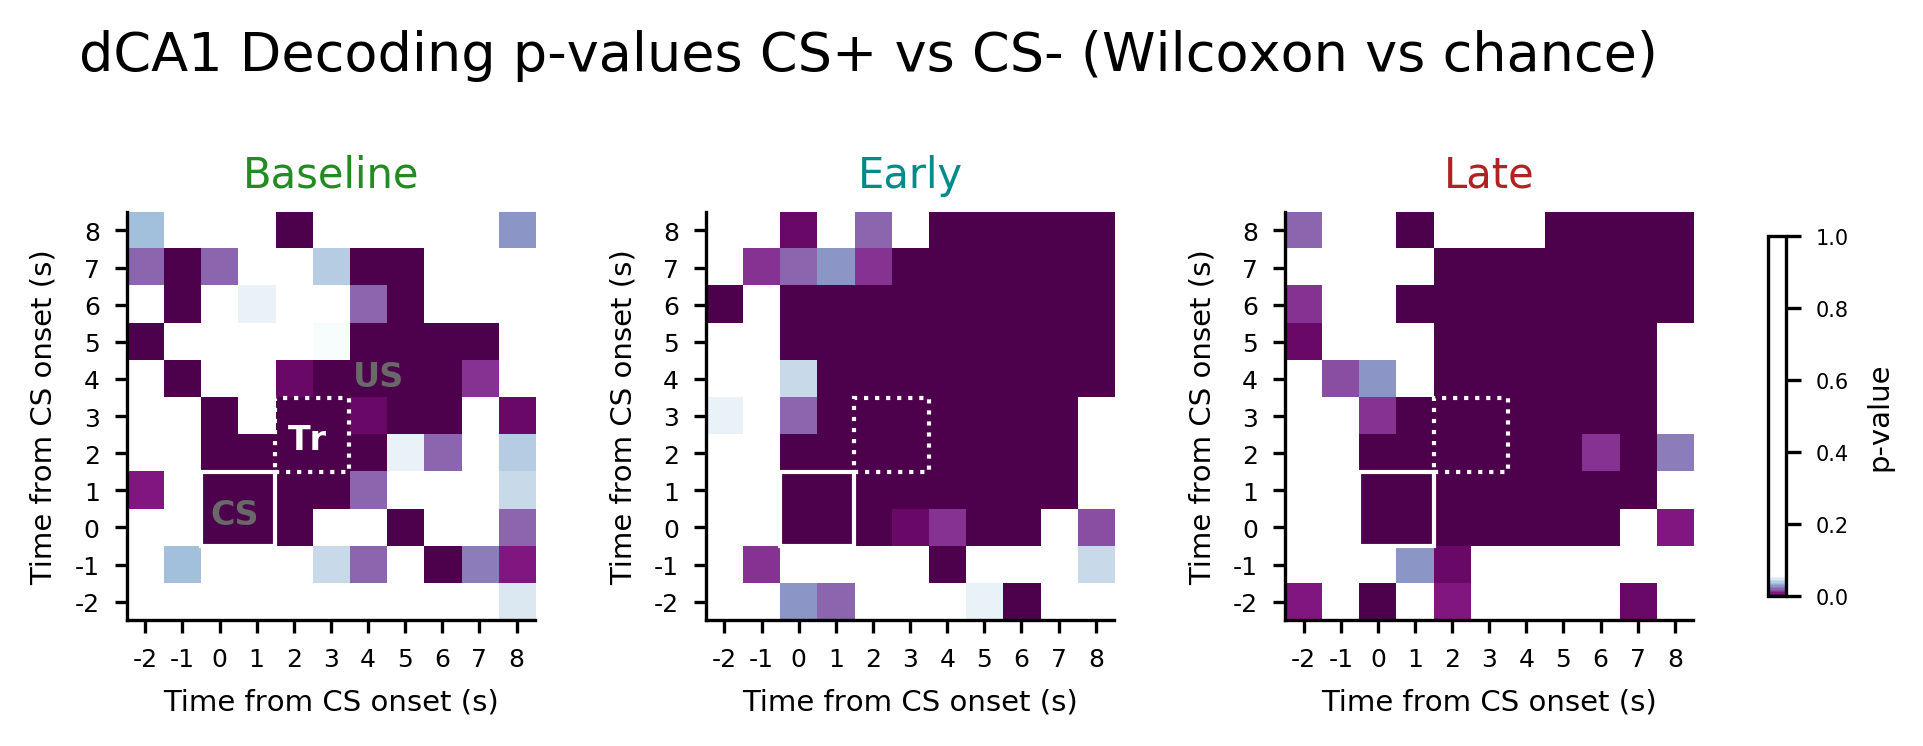

In [150]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
#make unique colormap for emphasizing significant p-values
sigs = cm.get_cmap('BuPu', 15)
white = np.array([1, 1, 1, 1])
newcolors = np.vstack((sigs(np.linspace(1, 0, 15)),
                       sigs(np.linspace(0, 1, 241))))
#pink = np.array([.96, .09, .6, 1])
newcolors[15:, :] = white
newcmap = ListedColormap(newcolors)

fig, ax = pl.subplots(1, 3, figsize=(6, 3))#, sharex=True, sharey=True)
vmin=0
vmax=1
for sess,x in zip(sessions,range(len(sessions))):
    im = ax[x].imshow(distinct_CSPvsCSM_wilcox[sess],origin='lower', interpolation='nearest', vmin=vmin, vmax=vmax,cmap=newcmap)
for x in range (3):
    ax[x].set_xticks(range(14))
    ax[x].set_yticks(range(14))
    ax[x].set_ylim(2.5, 13.5)
    ax[x].set_xlim(2.5,13.5)
    ax[x].set_xticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_yticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_ylabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_xlabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_title(session_labels[x],fontsize=10,color=dark_co[x])
    ax[x].tick_params(length=3)

import matplotlib.patches as patches
for x in range(3):
# Create a Rectangle patch
    CS = patches.Rectangle((4.5,4.5),2,2,linewidth=1,edgecolor='w',facecolor='none')
    Tr = patches.Rectangle((6.5,6.5),2,2,linewidth=1,edgecolor='w',facecolor='none',linestyle=':')
# Add the patch to the Axes
    ax[x].add_patch(CS)
    ax[x].add_patch(Tr)

ax[0].text(4.75,5.1,"CS",fontsize=8, weight='bold', color='dimgrey')
ax[0].text(6.85,7.1,"Tr",fontsize=8, weight='bold', color='w')
ax[0].text(8.6,8.8,"US",fontsize=8, weight='bold', color='dimgrey')

pl.suptitle('dCA1 Decoding p-values CS+ vs CS- (Wilcoxon vs chance)',y=.93,fontsize=13)

cax = fig.add_axes([1,0.3, 0.01, 0.4])
fig.colorbar(im, cax=cax, label='p-value')#,ticks=[0,.05,.1])
#cax.axes.set_ylim(0,.1)
fig.tight_layout(pad=1.5)
#fig.savefig('../img/%s_gmin_across_bins_distinct_horizontal_wilcoxon.pdf'%NOTEBOOK_NAME)

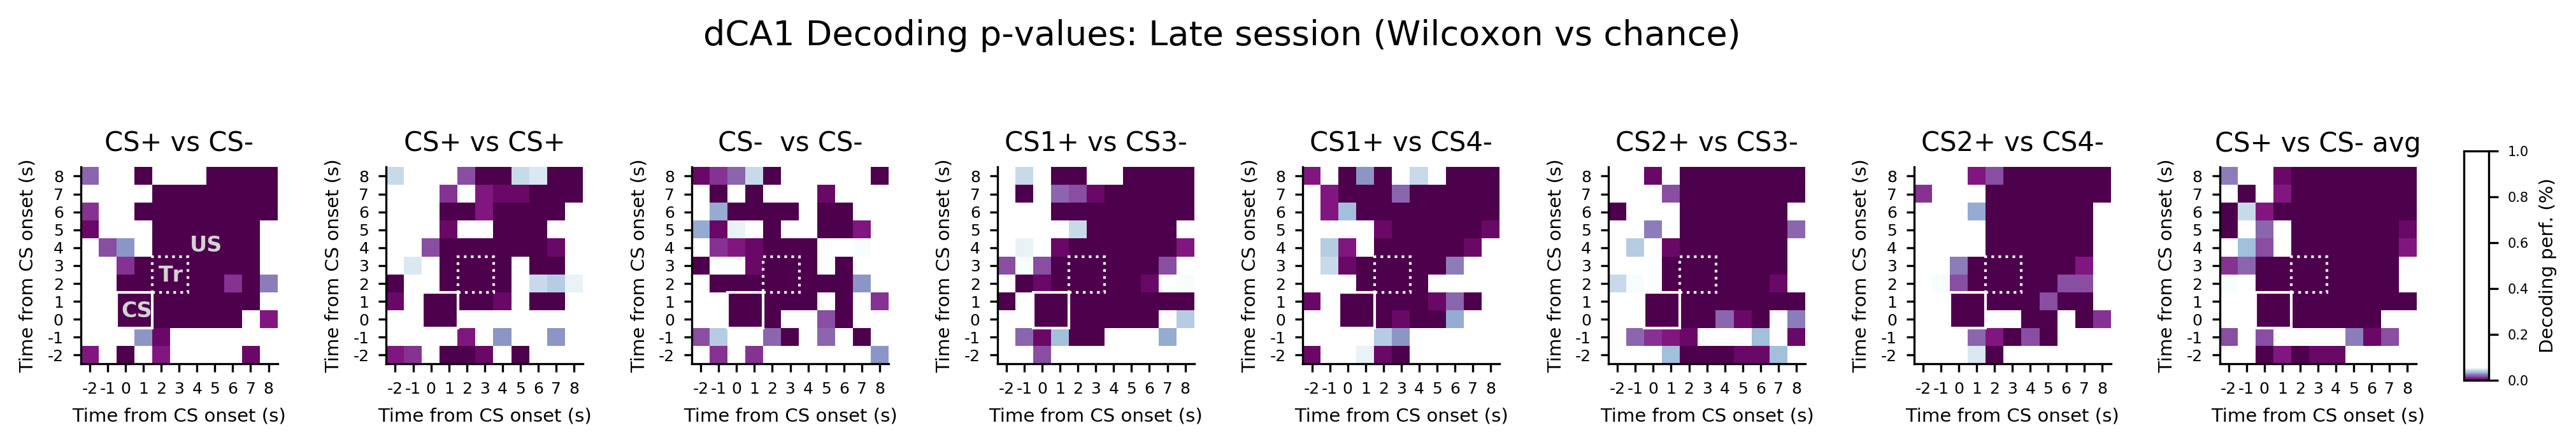

In [151]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
#make unique colormap for emphasizing significant p-values
sigs = cm.get_cmap('BuPu', 15)
white = np.array([1, 1, 1, 1])
newcolors = np.vstack((sigs(np.linspace(1, 0, 15)),
                       sigs(np.linspace(0, 1, 241))))
#pink = np.array([.96, .09, .6, 1])
newcolors[15:, :] = white
newcmap = ListedColormap(newcolors)

fig, ax = pl.subplots(1, 8, figsize=(13, 3))#, sharex=True, sharey=True)
vmin=0
vmax=1
for comp,x in zip(comparisons_av,range(len(comparisons_av))):
    im = ax[x].imshow(eval("distinct_%s_wilcox['post']"%comp),origin='lower', interpolation='nearest', vmin=vmin, vmax=vmax,cmap=newcmap)
for x in range (8):
    ax[x].set_xticks(range(14))
    ax[x].set_yticks(range(14))
    ax[x].set_ylim(2.5, 13.5)
    ax[x].set_xlim(2.5,13.5)
    ax[x].set_xticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_yticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_ylabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_xlabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_title(comp_labels_av[x],fontsize=10,color='k')
    ax[x].tick_params(length=3)

import matplotlib.patches as patches
for x in range(8):
# Create a Rectangle patch
    CS = patches.Rectangle((4.5,4.5),2,2,linewidth=1,edgecolor='w',facecolor='none')
    Tr = patches.Rectangle((6.5,6.5),2,2,linewidth=1,edgecolor='w',facecolor='none',linestyle=':')
# Add the patch to the Axes
    ax[x].add_patch(CS)
    ax[x].add_patch(Tr)

ax[0].text(4.75,5.1,"CS",fontsize=8, weight='bold', color='lightgrey')
ax[0].text(6.85,7.1,"Tr",fontsize=8, weight='bold', color='lightgrey')
ax[0].text(8.6,8.8,"US",fontsize=8, weight='bold', color='lightgrey')

pl.suptitle('dCA1 Decoding p-values: Late session (Wilcoxon vs chance)',y=.93,fontsize=13)

cax = fig.add_axes([1,0.3, 0.01, 0.4])
fig.colorbar(im, cax=cax, label='Decoding perf. (%)')
fig.tight_layout(pad=1.5)
#fig.savefig('../img/%s_gmin_across_bins_distinct_horizontal.pdf'%NOTEBOOK_NAME)

## Now reciprocally train/test on 2 time bins

In [208]:
def do_test_across_tbs_bothWays(patterns_train, patterns_test, labels, **args):
    x, y, xT, yT = combine_train_test_patterns_across_tbs(patterns_train, patterns_test, labels, train_test_split=0.5, **args)
    decoder.fit(x, y)
    scores = decoder.score(xT, yT)
    decoder.fit(xT, yT)
    return np.append(scores, decoder.score(x,y))

In [209]:
%%time
n_loops=30
for t in range (14):
    for c in range (14):
        for comp,relab in zip(comparisons,relabels):
            exec('scores_tb_%s_VS_%s_%s_bothWays = {}'%(t,c,comp))
            for sess in sessions:
                print sess,t,c,comp,
                print " ",
                eval('scores_tb_%s_VS_%s_%s_bothWays'%(t,c,comp))[sess] = np.r_[[do_test_across_tbs_bothWays(eval('patterns_tb_%s_%s'%(t,sess)),
                      eval('patterns_tb_%s_%s'%(c,sess)),eval('labels_%s'%sess),classes=range(1,5),
                      n_cells=None, relabel=relab) for i in range(n_loops)]]

expo 0 0 CSPvsCSM   pre 0 0 CSPvsCSM   post 0 0 CSPvsCSM   expo 0 0 CS1vsCS2   pre 0 0 CS1vsCS2   post 0 0 CS1vsCS2   expo 0 0 CS3vsCS4   pre 0 0 CS3vsCS4   post 0 0 CS3vsCS4   expo 0 0 CS1vsCS3   pre 0 0 CS1vsCS3   post 0 0 CS1vsCS3   expo 0 0 CS1vsCS4   pre 0 0 CS1vsCS4   post 0 0 CS1vsCS4   expo 0 0 CS2vsCS3   pre 0 0 CS2vsCS3   post 0 0 CS2vsCS3   expo 0 0 CS2vsCS4   pre 0 0 CS2vsCS4   post 0 0 CS2vsCS4   expo 0 1 CSPvsCSM   pre 0 1 CSPvsCSM   post 0 1 CSPvsCSM   expo 0 1 CS1vsCS2   pre 0 1 CS1vsCS2   post 0 1 CS1vsCS2   expo 0 1 CS3vsCS4   pre 0 1 CS3vsCS4   post 0 1 CS3vsCS4   expo 0 1 CS1vsCS3   pre 0 1 CS1vsCS3   post 0 1 CS1vsCS3   expo 0 1 CS1vsCS4   pre 0 1 CS1vsCS4   post 0 1 CS1vsCS4   expo 0 1 CS2vsCS3   pre 0 1 CS2vsCS3   post 0 1 CS2vsCS3   expo 0 1 CS2vsCS4   pre 0 1 CS2vsCS4   post 0 1 CS2vsCS4   expo 0 2 CSPvsCSM   pre 0 2 CSPvsCSM   post 0 2 CSPvsCSM   expo 0 2 CS1vsCS2   pre 0 2 CS1vsCS2   post 0 2 CS1vsCS2   expo 0 2 CS3vsCS4   pre 0 2 CS3vsCS4   post 0 2 CS3vsCS4

In [210]:
#for outcome endoding, average each idividual comparison
for t in range(14):
    for c in range(14):
        exec("scores_tb_%s_VS_%s_CSPvsCSM_averaged_bothWays = {}"%(t,c))
        for sess in sessions:
            exec("scores_tb_%s_VS_%s_CSPvsCSM_averaged_bothWays[sess] = np.mean((scores_tb_%s_VS_%s_CS1vsCS3_bothWays[sess],\
                 scores_tb_%s_VS_%s_CS1vsCS4_bothWays[sess],scores_tb_%s_VS_%s_CS2vsCS3_bothWays[sess],\
                 scores_tb_%s_VS_%s_CS2vsCS4_bothWays[sess]),axis=0)"%(t,c,t,c,t,c,t,c,t,c))

In [227]:
for t in range (14):
    for comp in comparisons_av:
        exec('distinct_bothWays%s_%s = {}'%(t,comp))
for sess in sessions:
    for t in range (14):
        for comp in comparisons_av:
            exec("distinct_bothWays%s_%s['%s'] = []"%(t,comp,sess))
            for c in range (14):
                eval('distinct_bothWays%s_%s'%(t,comp))[sess].insert(c,(eval('scores_tb_%s_VS_%s_%s_bothWays'%(t,c,comp))[sess].mean()))

In [234]:
scores_tb_0_VS_0_CS1vsCS2_bothWays['expo'].mean(1)

array([ 0.54  ,  0.6825,  0.5475,  0.6775,  0.61  ,  0.565 ,  0.5675,
        0.33  ,  0.3975,  0.6175,  0.5375,  0.495 ,  0.63  ,  0.425 ,
        0.54  ,  0.5   ,  0.4875,  0.6   ,  0.505 ,  0.5425,  0.4325,
        0.6725,  0.495 ,  0.4025,  0.5025,  0.44  ,  0.6225,  0.3875,
        0.425 ,  0.515 ])

In [235]:
for t in range (14):
    for comp in comparisons_av:
        exec('distinct_bothWays%s_%s_wilcox = {}'%(t,comp))
for sess in sessions:
    for t in range (14):
        for comp in comparisons_av:
            exec("distinct_bothWays%s_%s_wilcox[sess] = []"%(t,comp))
            for c in range (14):
                exec("subtracted = [x-0.5 for x in scores_tb_%s_VS_%s_%s_bothWays[sess].mean(1)]"%(t,c,comp))
                eval('distinct_bothWays%s_%s_wilcox'%(t,comp))[sess].insert(c, sstats.wilcoxon(subtracted[:15]))
            for x,i in zip(eval('distinct_bothWays%s_%s_wilcox'%(t,comp))[sess],range(len(eval('distinct_bothWays%s_%s_wilcox'%(t,comp))[sess]))):
                exec("distinct_bothWays%s_%s_wilcox[sess][i] = x[-1]"%(t,comp)) #only take p-values

In [236]:
for comp in comparisons_av:
    exec("distinct_bothWays_%s={}"%comp)
    for sess in sessions:
        exec("distinct_bothWays_%s[sess]=(distinct_bothWays0_%s[sess], distinct_bothWays1_%s[sess], distinct_bothWays2_%s[sess], distinct_bothWays3_%s[sess], distinct_bothWays4_%s[sess], distinct_bothWays5_%s[sess], distinct_bothWays6_%s[sess], distinct_bothWays7_%s[sess],\
              distinct_bothWays8_%s[sess], distinct_bothWays9_%s[sess], distinct_bothWays10_%s[sess], distinct_bothWays11_%s[sess], distinct_bothWays12_%s[sess],\
              distinct_bothWays13_%s[sess])"%(comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp))
        np.array([eval("distinct_bothWays_%s[sess]"%comp)])

In [237]:
for comp in comparisons_av:
    exec("distinct_bothWays_%s_wilcox={}"%comp)
    for sess in sessions:
        exec("distinct_bothWays_%s_wilcox[sess]=(distinct_bothWays0_%s_wilcox[sess], distinct_bothWays1_%s_wilcox[sess], distinct_bothWays2_%s_wilcox[sess], distinct_bothWays3_%s_wilcox[sess], distinct_bothWays4_%s_wilcox[sess], distinct_bothWays5_%s_wilcox[sess], distinct_bothWays6_%s_wilcox[sess], distinct_bothWays7_%s_wilcox[sess],\
              distinct_bothWays8_%s_wilcox[sess], distinct_bothWays9_%s_wilcox[sess], distinct_bothWays10_%s_wilcox[sess], distinct_bothWays11_%s_wilcox[sess], distinct_bothWays12_%s_wilcox[sess],\
              distinct_bothWays13_%s_wilcox[sess])"%(comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp))
        np.array([eval("distinct_bothWays_%s_wilcox[sess]"%comp)])

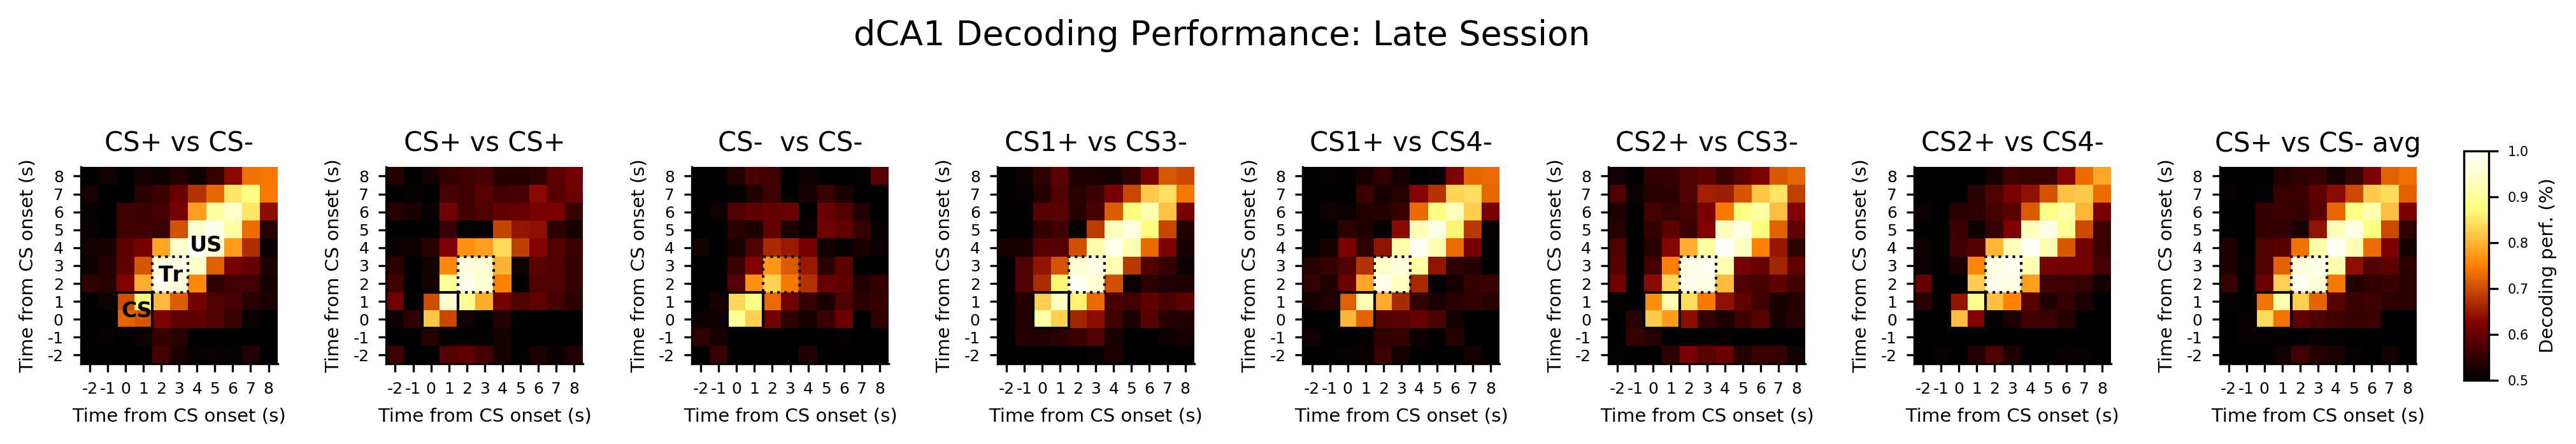

In [238]:
fig, ax = pl.subplots(1, 8, figsize=(13, 3))#, sharex=True, sharey=True)
vmin=0.5
vmax=1
for comp,x in zip(comparisons_av,range(len(comparisons_av))):
    im = ax[x].imshow(eval("distinct_bothWays_%s['post']"%comp),origin='lower', interpolation='nearest', vmin=vmin, vmax=vmax,cmap='afmhot')
for x in range (8):
    ax[x].set_xticks(range(14))
    ax[x].set_yticks(range(14))
    ax[x].set_ylim(2.5, 13.5)
    ax[x].set_xlim(2.5,13.5)
    ax[x].set_xticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_yticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_ylabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_xlabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_title(comp_labels_av[x],fontsize=10,color='k')
    ax[x].tick_params(length=3)

import matplotlib.patches as patches
for x in range(8):
# Create a Rectangle patch
    CS = patches.Rectangle((4.5,4.5),2,2,linewidth=1,edgecolor='k',facecolor='none')
    Tr = patches.Rectangle((6.5,6.5),2,2,linewidth=1,edgecolor='k',facecolor='none',linestyle=':')
# Add the patch to the Axes
    ax[x].add_patch(CS)
    ax[x].add_patch(Tr)
    #ax[x].text(4.2,-2.5,'Tested on',fontsize=12,color='darkslateblue')

#ax[0].text(-2.9,11,'Trained on',rotation=90,fontsize=12,color='darkslateblue')
ax[0].text(4.75,5.1,"CS",fontsize=8, weight='bold', color='k')
ax[0].text(6.85,7.1,"Tr",fontsize=8, weight='bold', color='k')
ax[0].text(8.6,8.8,"US",fontsize=8, weight='bold', color='k')

pl.suptitle('dCA1 Decoding Performance: Late Session',y=.93,fontsize=13)

cax = fig.add_axes([1,0.3, 0.01, 0.4])
fig.colorbar(im, cax=cax, label='Decoding perf. (%)')
fig.tight_layout(pad=1.5)
fig.savefig('../img/%s_across_bins_LATE_bothWays.jpg'%NOTEBOOK_NAME)

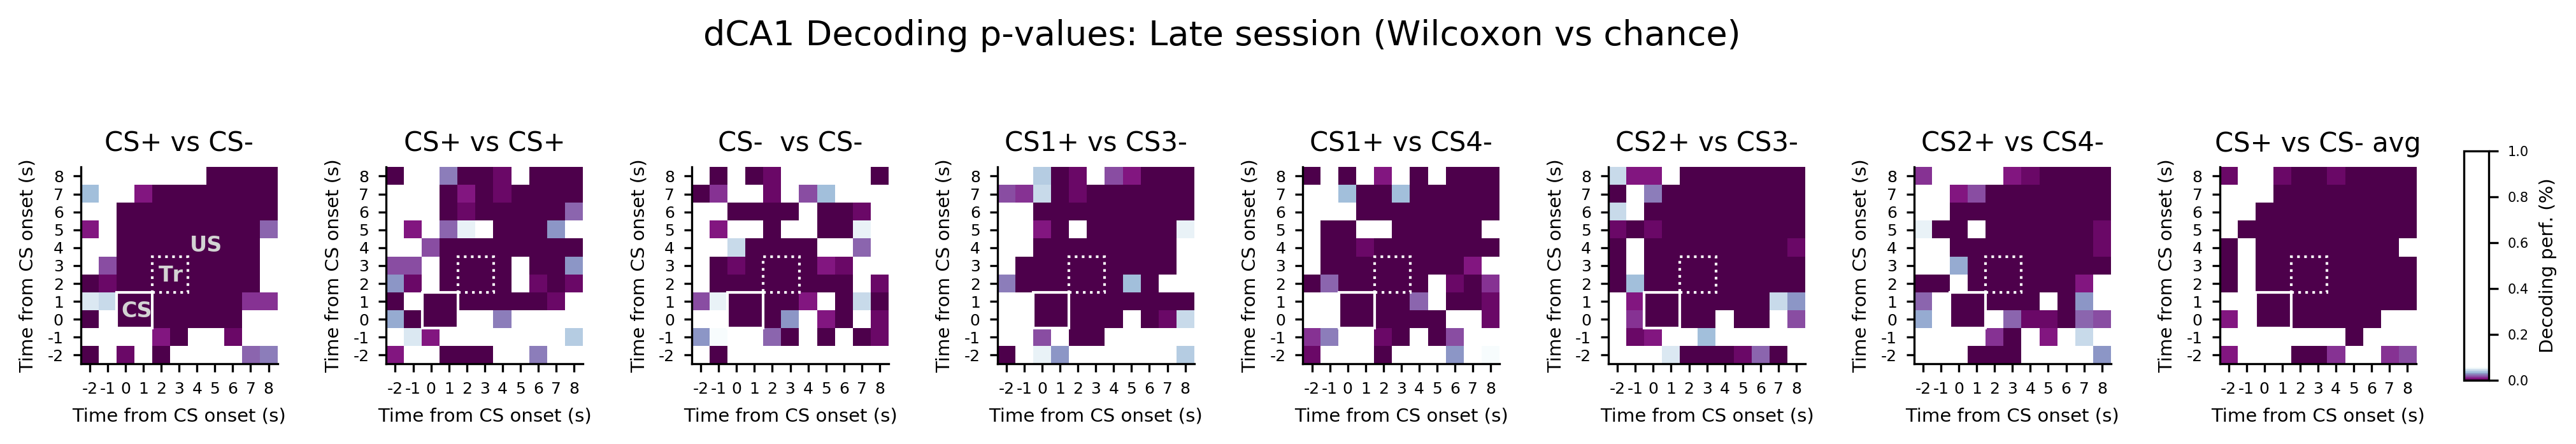

In [240]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
#make unique colormap for emphasizing significant p-values
sigs = cm.get_cmap('BuPu', 15)
white = np.array([1, 1, 1, 1])
newcolors = np.vstack((sigs(np.linspace(1, 0, 15)),
                       sigs(np.linspace(0, 1, 241))))
#pink = np.array([.96, .09, .6, 1])
newcolors[15:, :] = white
newcmap = ListedColormap(newcolors)

fig, ax = pl.subplots(1, 8, figsize=(13, 3))#, sharex=True, sharey=True)
vmin=0
vmax=1
for comp,x in zip(comparisons_av,range(len(comparisons_av))):
    im = ax[x].imshow(eval("distinct_bothWays_%s_wilcox['post']"%comp),origin='lower', interpolation='nearest', vmin=vmin, vmax=vmax,cmap=newcmap)
for x in range (8):
    ax[x].set_xticks(range(14))
    ax[x].set_yticks(range(14))
    ax[x].set_ylim(2.5, 13.5)
    ax[x].set_xlim(2.5,13.5)
    ax[x].set_xticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_yticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_ylabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_xlabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_title(comp_labels_av[x],fontsize=10,color='k')
    ax[x].tick_params(length=3)

import matplotlib.patches as patches
for x in range(8):
# Create a Rectangle patch
    CS = patches.Rectangle((4.5,4.5),2,2,linewidth=1,edgecolor='w',facecolor='none')
    Tr = patches.Rectangle((6.5,6.5),2,2,linewidth=1,edgecolor='w',facecolor='none',linestyle=':')
# Add the patch to the Axes
    ax[x].add_patch(CS)
    ax[x].add_patch(Tr)

ax[0].text(4.75,5.1,"CS",fontsize=8, weight='bold', color='lightgrey')
ax[0].text(6.85,7.1,"Tr",fontsize=8, weight='bold', color='lightgrey')
ax[0].text(8.6,8.8,"US",fontsize=8, weight='bold', color='lightgrey')

pl.suptitle('dCA1 Decoding p-values: Late session (Wilcoxon vs chance)',y=.93,fontsize=13)

cax = fig.add_axes([1,0.3, 0.01, 0.4])
fig.colorbar(im, cax=cax, label='Decoding perf. (%)')
fig.tight_layout(pad=1.5)
#fig.savefig('../img/%s_gmin_across_bins_distinct_horizontal.pdf'%NOTEBOOK_NAME)

In [152]:
tt_pairs_avg = ['tr13_ts24','tr14_ts23','tr23_ts14','tr24_ts13','averaged']
tt_labels = ['1v3 & 2v4','1v4 & 2v3','2v3 & 1v4','2v4 & 1v3','Average']

In [153]:
for t in range (14):
    for comp in tt_pairs_avg:
        exec('distinct%s_%s = {}'%(t,comp))
for sess in sessions:
    for t in range (14):
        for comp in tt_pairs_avg:
            exec("distinct%s_%s['%s'] = []"%(t,comp,sess))
            for c in range (14):
                eval('distinct%s_%s'%(t,comp))[sess].insert(c,(eval('scores_tb_%s_VS_%s_outcome_%s'%(t,c,comp))[sess].mean()))

In [154]:
for t in range (14):
    for comp in tt_pairs_avg:
        exec('distinct%s_%s_wilcox = {}'%(t,comp))
for sess in sessions:
    for t in range (14):
        for comp in tt_pairs_avg:
            exec("distinct%s_%s_wilcox[sess] = []"%(t,comp))
            for c in range (14):
                exec("subtracted = [x-0.5 for x in scores_tb_%s_VS_%s_outcome_%s[sess]]"%(t,c,comp))
                eval('distinct%s_%s_wilcox'%(t,comp))[sess].insert(c, sstats.wilcoxon(subtracted[:15]))
            for x,i in zip(eval('distinct%s_%s_wilcox'%(t,comp))[sess],range(len(eval('distinct%s_%s_wilcox'%(t,comp))[sess]))):
                exec("distinct%s_%s_wilcox[sess][i] = x[-1]"%(t,comp)) #only take p-values

In [155]:
for comp in tt_pairs_avg:
    exec("distinct_%s={}"%comp)
    for sess in sessions:
        exec("distinct_%s[sess]=(distinct0_%s[sess], distinct1_%s[sess], distinct2_%s[sess], distinct3_%s[sess], distinct4_%s[sess], distinct5_%s[sess], distinct6_%s[sess], distinct7_%s[sess],\
              distinct8_%s[sess], distinct9_%s[sess], distinct10_%s[sess], distinct11_%s[sess], distinct12_%s[sess],\
              distinct13_%s[sess])"%(comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp))
        np.array([eval("distinct_%s[sess]"%comp)])

In [156]:
for comp in tt_pairs_avg:
    exec("distinct_%s_wilcox={}"%comp)
    for sess in sessions:
        exec("distinct_%s_wilcox[sess]=(distinct0_%s_wilcox[sess], distinct1_%s_wilcox[sess], distinct2_%s_wilcox[sess], distinct3_%s_wilcox[sess], distinct4_%s_wilcox[sess], distinct5_%s_wilcox[sess], distinct6_%s_wilcox[sess], distinct7_%s_wilcox[sess],\
              distinct8_%s_wilcox[sess], distinct9_%s_wilcox[sess], distinct10_%s_wilcox[sess], distinct11_%s_wilcox[sess], distinct12_%s_wilcox[sess],\
              distinct13_%s_wilcox[sess])"%(comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp))
        np.array([eval("distinct_%s_wilcox[sess]"%comp)])

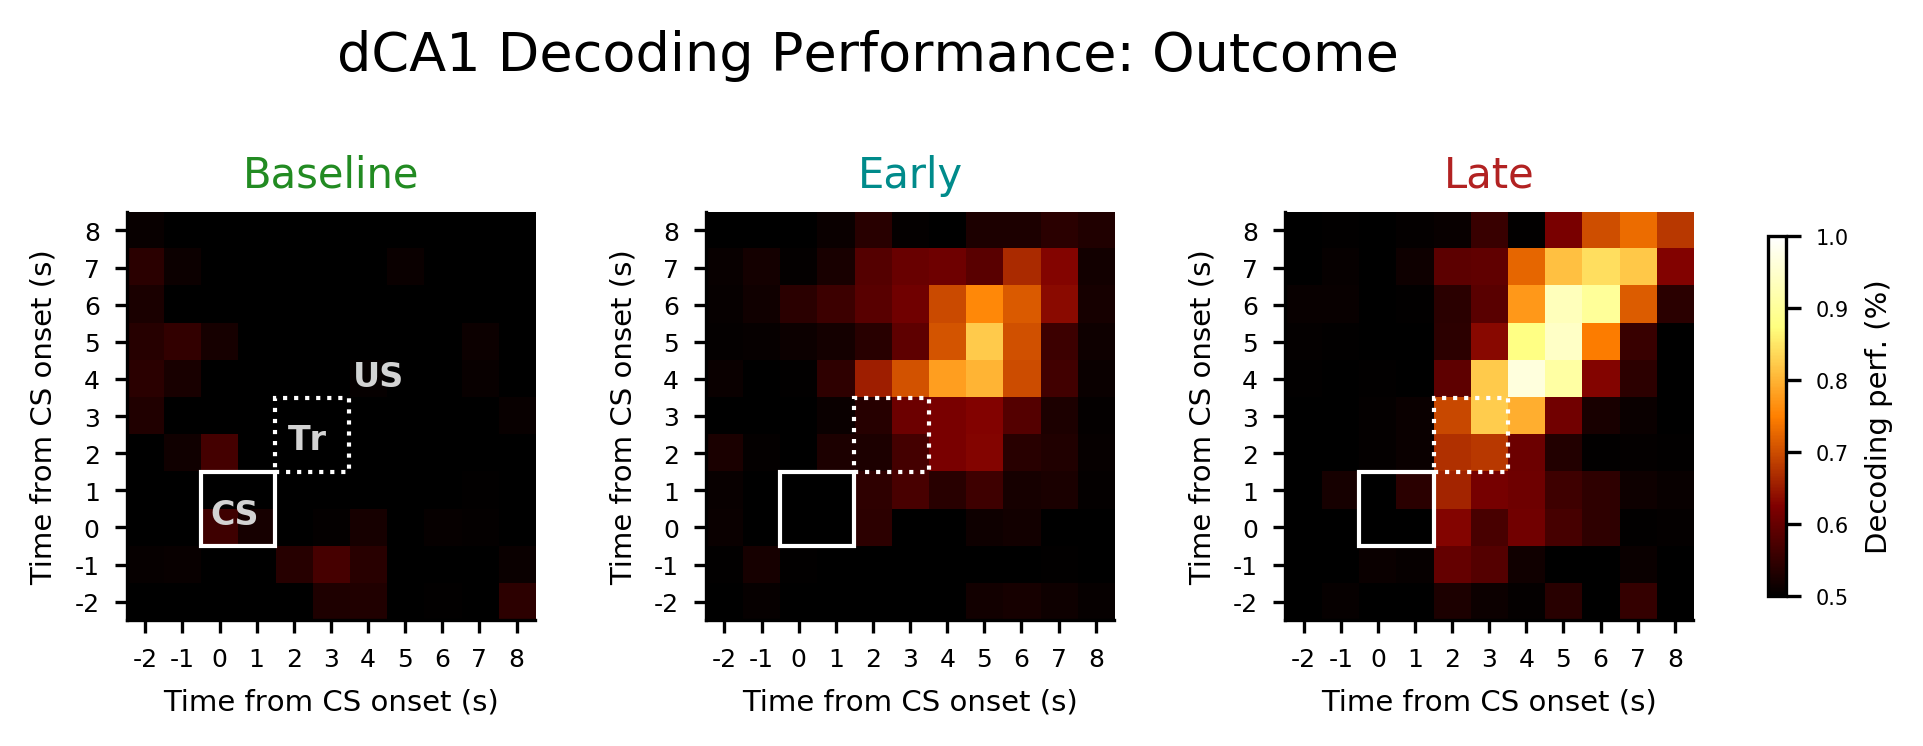

In [157]:
fig, ax = pl.subplots(1, 3, figsize=(6, 3))#, sharex=True, sharey=True)
vmin=0.5
vmax=1
for sess,x in zip(sessions,range(len(sessions))):
    im = ax[x].imshow(distinct_averaged[sess],origin='lower', interpolation='nearest', vmin=vmin, vmax=vmax,cmap='afmhot')
for x in range (3):
    ax[x].set_xticks(range(14))
    ax[x].set_yticks(range(14))
    ax[x].set_ylim(2.5, 13.5)
    ax[x].set_xlim(2.5,13.5)
    ax[x].set_xticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_yticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_ylabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_xlabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_title(session_labels[x],fontsize=10,color=dark_co[x])
    ax[x].tick_params(length=3)

import matplotlib.patches as patches
for x in range(3):
# Create a Rectangle patch
    CS = patches.Rectangle((4.5,4.5),2,2,linewidth=1,edgecolor='w',facecolor='none')
    Tr = patches.Rectangle((6.5,6.5),2,2,linewidth=1,edgecolor='w',facecolor='none',linestyle=':')
# Add the patch to the Axes
    ax[x].add_patch(CS)
    ax[x].add_patch(Tr)

ax[0].text(4.75,5.1,"CS",fontsize=8, weight='bold', color='lightgray')
ax[0].text(6.85,7.1,"Tr",fontsize=8, weight='bold', color='lightgray')
ax[0].text(8.6,8.8,"US",fontsize=8, weight='bold', color='lightgray')

pl.suptitle('dCA1 Decoding Performance: Outcome',y=.93,fontsize=13)

cax = fig.add_axes([1,0.3, 0.01, 0.4])
fig.colorbar(im, cax=cax, label='Decoding perf. (%)')
fig.tight_layout(pad=1.5)
#fig.savefig('../img/%s_gmin_across_bins_distinct_horizontal.pdf'%NOTEBOOK_NAME)

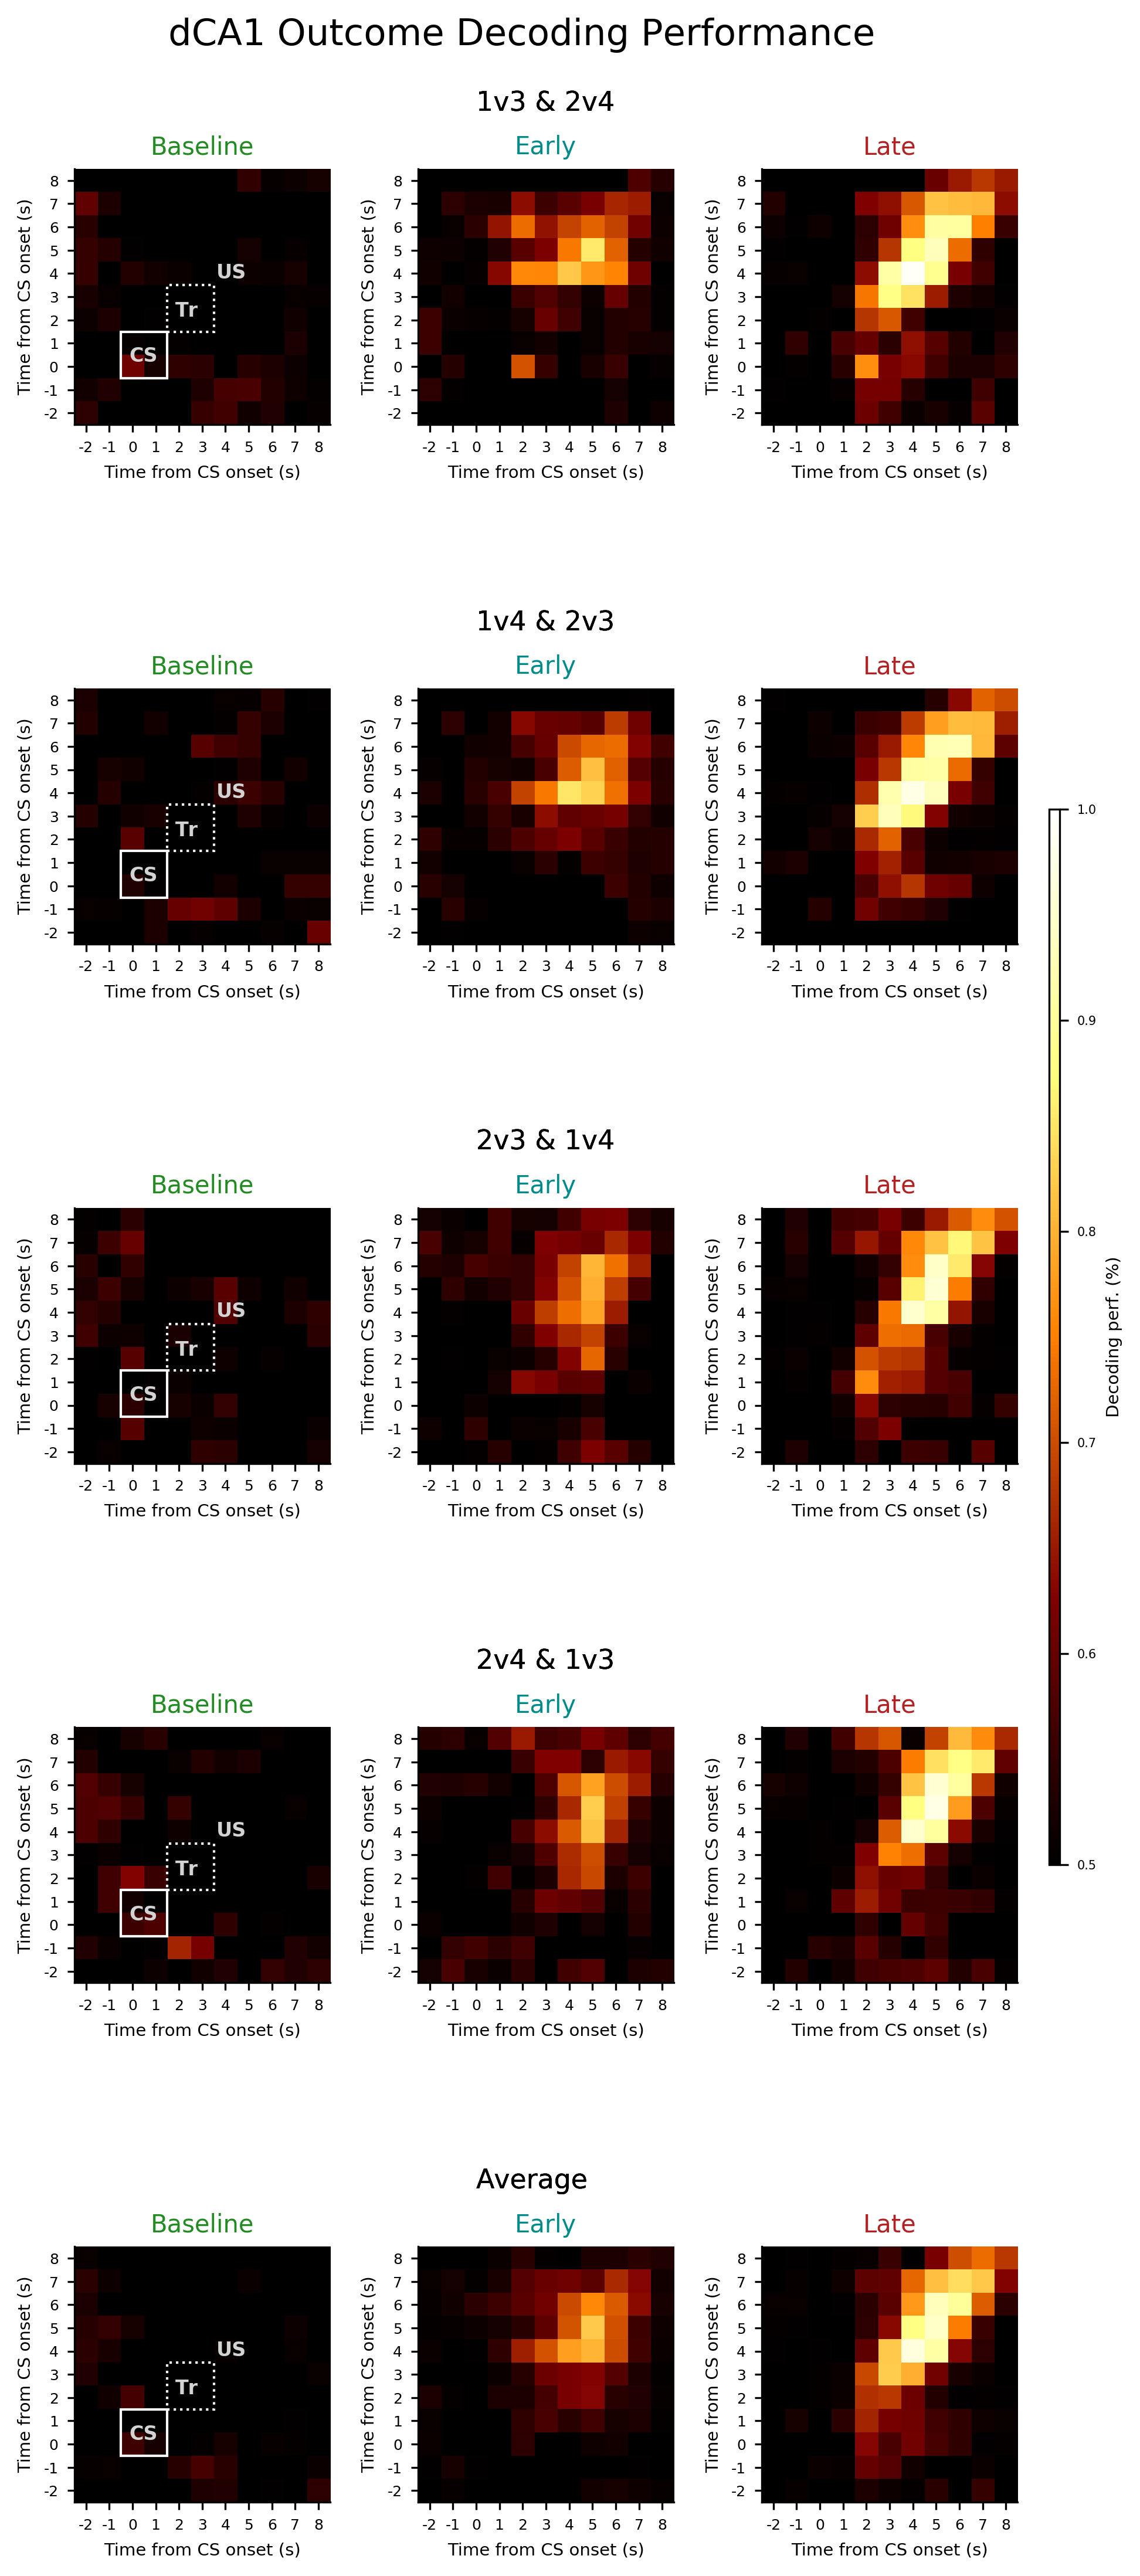

In [158]:
fig, ax = pl.subplots(5, 3, figsize=(6, 15))#, sharex=True, sharey=True)
vmin=0.5
vmax=1
for sess,x in zip(sessions,range(len(sessions))):
    for comp,i in zip(tt_pairs_avg,range(len(tt_pairs_avg))):
        im = ax[i][x].imshow(eval("distinct_%s[sess]"%comp),origin='lower', interpolation='nearest', vmin=vmin, vmax=vmax,cmap='afmhot')
        ax[i][x].set_xticks(range(14))
        ax[i][x].set_yticks(range(14))
        ax[i][x].set_ylim(2.5,13.5)
        ax[i][x].set_xlim(2.5,13.5)
        ax[i][x].set_xticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
        ax[i][x].set_yticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
        ax[i][x].set_ylabel('Time from CS onset (s)', fontsize=7)
        ax[i][x].set_xlabel('Time from CS onset (s)', fontsize=7)
        ax[i][x].set_title(session_labels[x],fontsize=10,color=dark_co[x])
        ax[i][x].tick_params(length=3)
        ax[i][1].text(5,16,tt_labels[i],fontsize=11)

import matplotlib.patches as patches
for i in range(5):
# Create a Rectangle patch
    CS = patches.Rectangle((4.5,4.5),2,2,linewidth=1,edgecolor='w',facecolor='none')
    Tr = patches.Rectangle((6.5,6.5),2,2,linewidth=1,edgecolor='w',facecolor='none',linestyle=':')
# Add the patch to the Axes
    ax[i][0].add_patch(CS)
    ax[i][0].add_patch(Tr)
    ax[i][0].text(4.85,5.2,"CS",fontsize=8, weight='bold', color='lightgray')
    ax[i][0].text(6.85,7.15,"Tr",fontsize=8, weight='bold', color='lightgray')
    ax[i][0].text(8.6,8.8,"US",fontsize=8, weight='bold', color='lightgray')

pl.suptitle('dCA1 Outcome Decoding Performance',y=1.,fontsize=15)

cax = fig.add_axes([1,0.3, 0.01, 0.4])
fig.colorbar(im, cax=cax, label='Decoding perf. (%)')
fig.tight_layout(pad=1)
#fig.savefig('../img/%s_gmin_across_bins_distinct_horizontal.pdf'%NOTEBOOK_NAME)

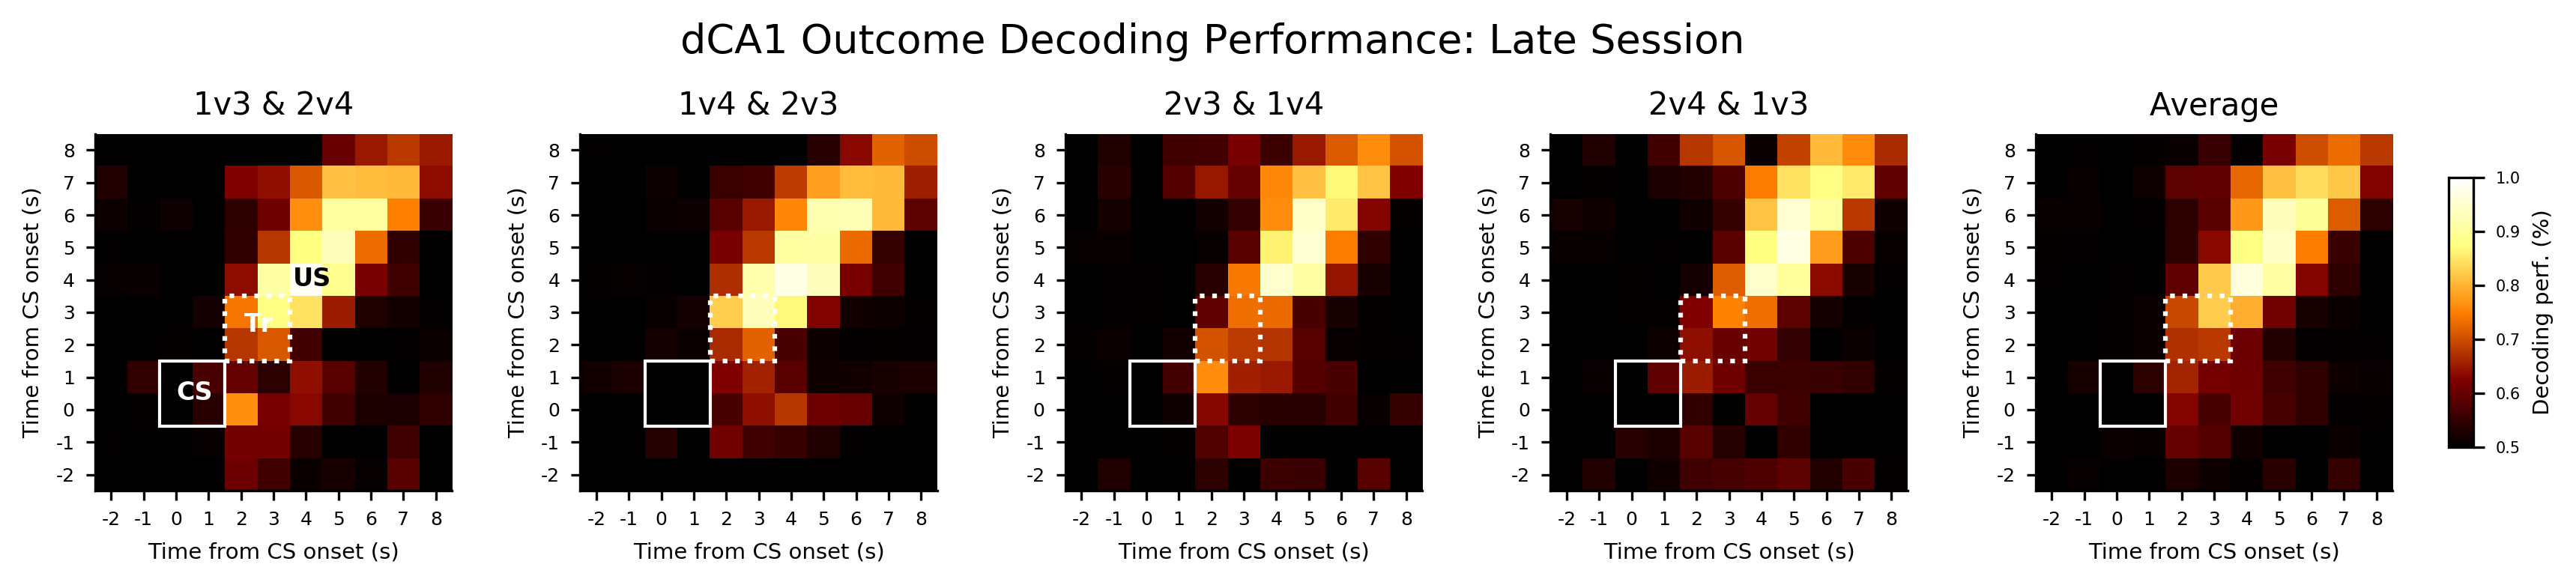

In [159]:
fig, ax = pl.subplots(1, 5, figsize=(11, 3))#, sharex=True, sharey=True)
vmin=0.5
vmax=1
for comp,x in zip(tt_pairs_avg,range(len(tt_pairs_avg))):
    im = ax[x].imshow(eval("distinct_%s['post']"%comp),origin='lower', interpolation='nearest', vmin=vmin, vmax=vmax,cmap='afmhot')
for x in range (5):
    ax[x].set_xticks(range(14))
    ax[x].set_yticks(range(14))
    ax[x].set_ylim(2.5, 13.5)
    ax[x].set_xlim(2.5,13.5)
    ax[x].set_xticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_yticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_ylabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_xlabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_title(tt_labels[x],fontsize=10,color='k')
    ax[x].tick_params(length=3)

import matplotlib.patches as patches
for x in range(5):
# Create a Rectangle patch
    CS = patches.Rectangle((4.5,4.5),2,2,linewidth=1,edgecolor='w',facecolor='none')
    Tr = patches.Rectangle((6.5,6.5),2,2,linewidth=1.5,edgecolor='w',facecolor='none',linestyle=':')
# Add the patch to the Axes
    ax[x].add_patch(CS)
    ax[x].add_patch(Tr)

ax[0].text(5,5.3,"CS",fontsize=8, weight='bold', color='w')
ax[0].text(7.1,7.4,"Tr",fontsize=8, weight='bold', color='w')
ax[0].text(8.6,8.8,"US",fontsize=8, weight='bold', color='k')

pl.suptitle('dCA1 Outcome Decoding Performance: Late Session',y=.93,fontsize=13)

cax = fig.add_axes([1,0.3, 0.01, 0.4])
fig.colorbar(im, cax=cax, label='Decoding perf. (%)')
fig.tight_layout(pad=1.5)
#fig.savefig('../img/%s_gmin_across_bins_distinct_horizontal.pdf'%NOTEBOOK_NAME)

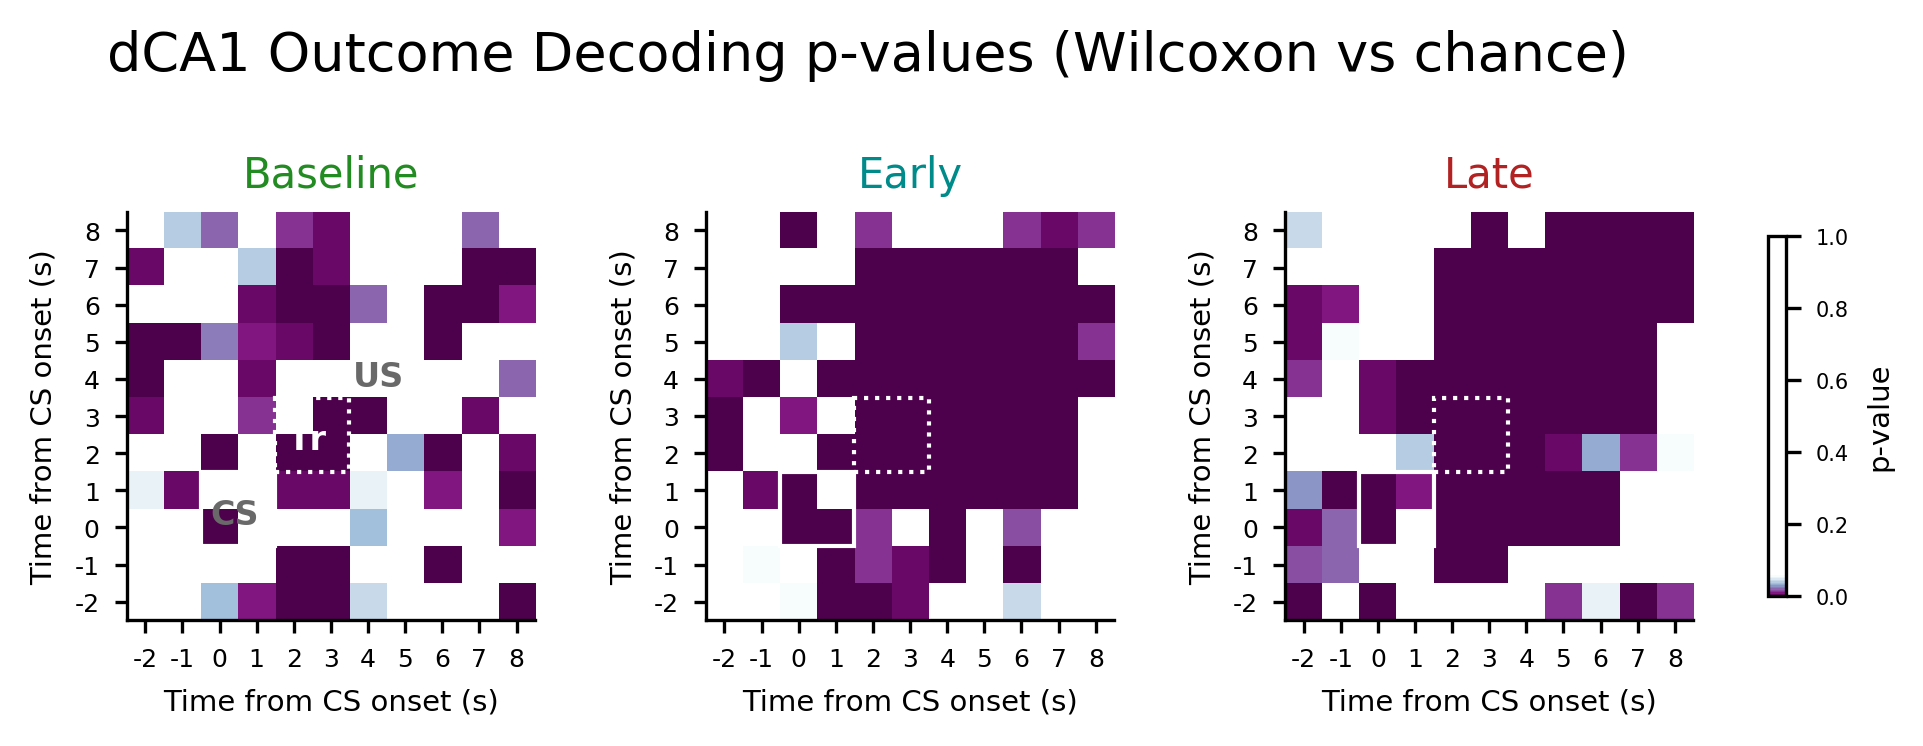

In [160]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
#make unique colormap for emphasizing significant p-values
sigs = cm.get_cmap('BuPu', 15)
white = np.array([1, 1, 1, 1])
newcolors = np.vstack((sigs(np.linspace(1, 0, 15)),
                       sigs(np.linspace(0, 1, 241))))
#pink = np.array([.96, .09, .6, 1])
newcolors[15:, :] = white
newcmap = ListedColormap(newcolors)

fig, ax = pl.subplots(1, 3, figsize=(6, 3))#, sharex=True, sharey=True)
vmin=0
vmax=1
for sess,x in zip(sessions,range(len(sessions))):
    im = ax[x].imshow(distinct_averaged_wilcox[sess],origin='lower', interpolation='nearest', vmin=vmin, vmax=vmax,cmap=newcmap)
for x in range (3):
    ax[x].set_xticks(range(14))
    ax[x].set_yticks(range(14))
    ax[x].set_ylim(2.5, 13.5)
    ax[x].set_xlim(2.5,13.5)
    ax[x].set_xticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_yticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_ylabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_xlabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_title(session_labels[x],fontsize=10,color=dark_co[x])
    ax[x].tick_params(length=3)

import matplotlib.patches as patches
for x in range(3):
# Create a Rectangle patch
    CS = patches.Rectangle((4.5,4.5),2,2,linewidth=1,edgecolor='w',facecolor='none')
    Tr = patches.Rectangle((6.5,6.5),2,2,linewidth=1,edgecolor='w',facecolor='none',linestyle=':')
# Add the patch to the Axes
    ax[x].add_patch(CS)
    ax[x].add_patch(Tr)

ax[0].text(4.75,5.1,"CS",fontsize=8, weight='bold', color='dimgrey')
ax[0].text(6.85,7.1,"Tr",fontsize=8, weight='bold', color='w')
ax[0].text(8.6,8.8,"US",fontsize=8, weight='bold', color='dimgrey')

pl.suptitle('dCA1 Outcome Decoding p-values (Wilcoxon vs chance)',y=.93,fontsize=13)

cax = fig.add_axes([1,0.3, 0.01, 0.4])
fig.colorbar(im, cax=cax, label='p-value')#,ticks=[0,.05,.1])
#cax.axes.set_ylim(0,.1)
fig.tight_layout(pad=1.5)
#fig.savefig('../img/%s_gmin_across_bins_distinct_horizontal_wilcoxon.pdf'%NOTEBOOK_NAME)

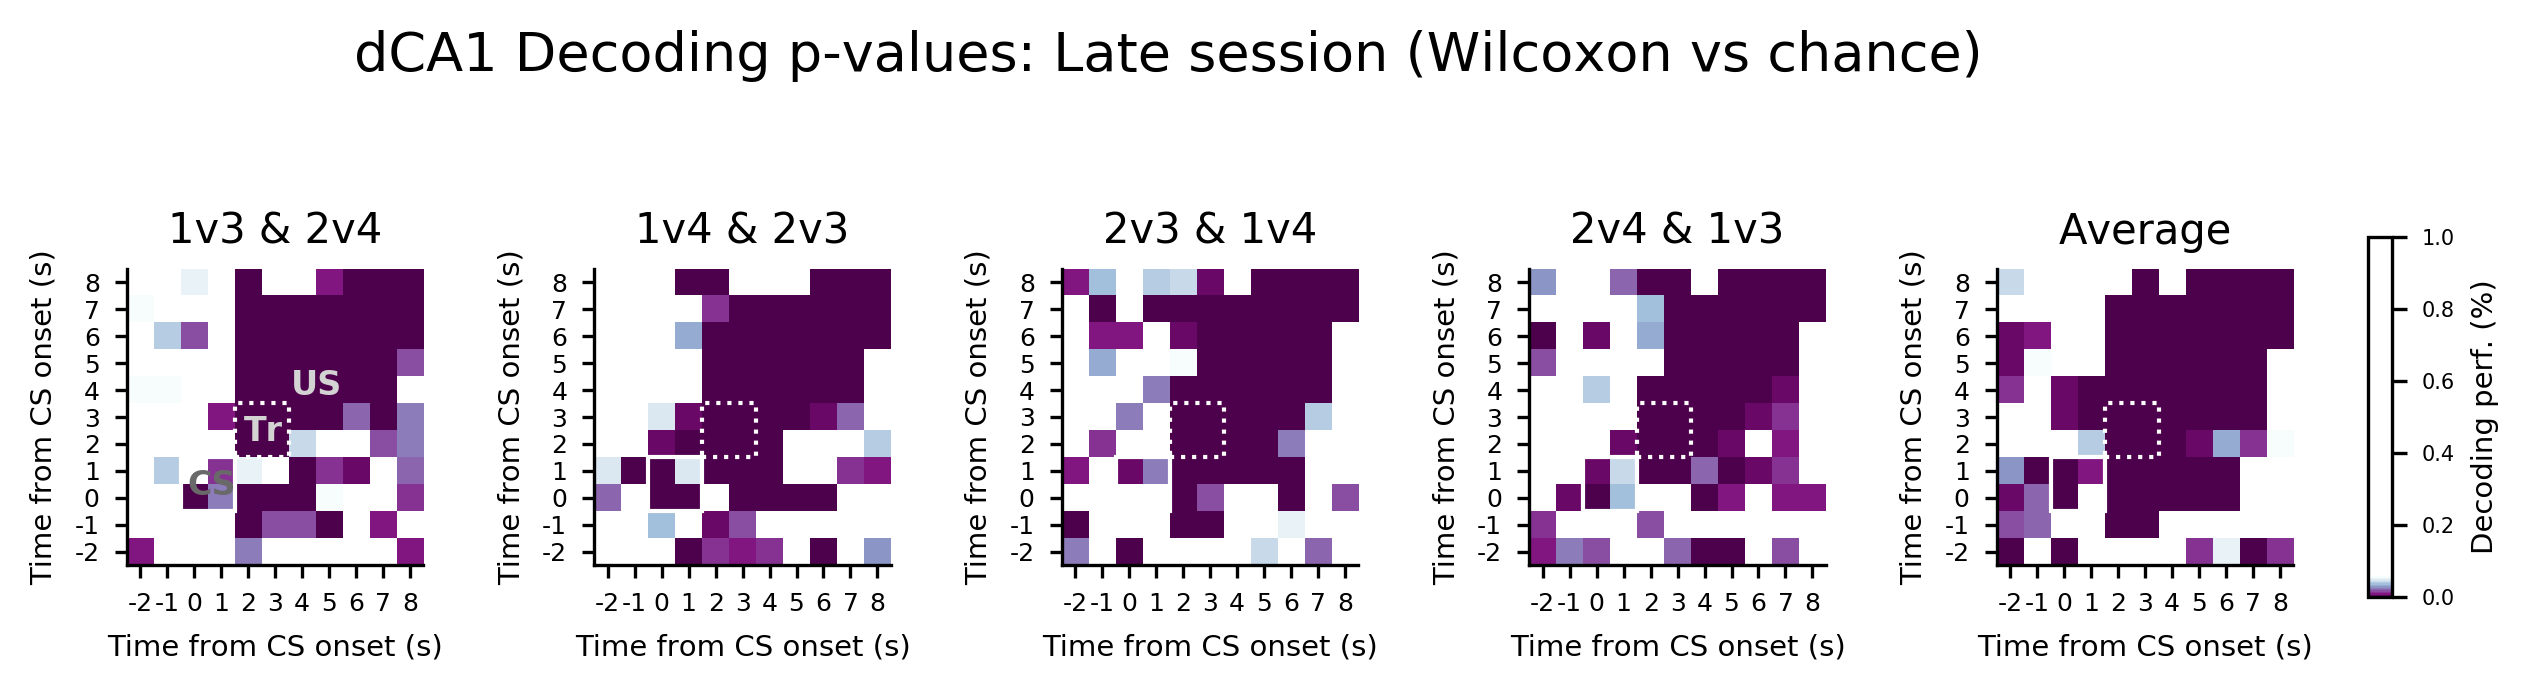

In [161]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
#make unique colormap for emphasizing significant p-values
sigs = cm.get_cmap('BuPu', 15)
white = np.array([1, 1, 1, 1])
newcolors = np.vstack((sigs(np.linspace(1, 0, 15)),
                       sigs(np.linspace(0, 1, 241))))
#pink = np.array([.96, .09, .6, 1])
newcolors[15:, :] = white
newcmap = ListedColormap(newcolors)

fig, ax = pl.subplots(1, 5, figsize=(8, 3))#, sharex=True, sharey=True)
vmin=0
vmax=1
for comp,x in zip(tt_pairs_avg,range(len(tt_pairs_avg))):
    im = ax[x].imshow(eval("distinct_%s_wilcox['post']"%comp),origin='lower', interpolation='nearest', vmin=vmin, vmax=vmax,cmap=newcmap)
for x in range (5):
    ax[x].set_xticks(range(14))
    ax[x].set_yticks(range(14))
    ax[x].set_ylim(2.5, 13.5)
    ax[x].set_xlim(2.5,13.5)
    ax[x].set_xticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_yticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_ylabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_xlabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_title(tt_labels[x],fontsize=10,color='k')
    ax[x].tick_params(length=3)

import matplotlib.patches as patches
for x in range(5):
# Create a Rectangle patch
    CS = patches.Rectangle((4.5,4.5),2,2,linewidth=1,edgecolor='w',facecolor='none')
    Tr = patches.Rectangle((6.5,6.5),2,2,linewidth=1,edgecolor='w',facecolor='none',linestyle=':')
# Add the patch to the Axes
    ax[x].add_patch(CS)
    ax[x].add_patch(Tr)

ax[0].text(4.75,5.1,"CS",fontsize=8, weight='bold', color='dimgrey')
ax[0].text(6.85,7.1,"Tr",fontsize=8, weight='bold', color='lightgrey')
ax[0].text(8.6,8.8,"US",fontsize=8, weight='bold', color='lightgrey')

pl.suptitle('dCA1 Decoding p-values: Late session (Wilcoxon vs chance)',y=.93,fontsize=13)

cax = fig.add_axes([1,0.3, 0.01, 0.4])
fig.colorbar(im, cax=cax, label='Decoding perf. (%)')
fig.tight_layout(pad=1.5)
#fig.savefig('../img/%s_gmin_across_bins_distinct_horizontal.pdf'%NOTEBOOK_NAME)

In [241]:
save_workspace(db)

Could not store variable 'sstats'. Skipping...
Could not store variable 'h5py'. Skipping...
Could not store variable 'ip'. Skipping...
Could not store variable 'IPython'. Skipping...
Could not store variable 'ut'. Skipping...
Could not store variable 'sys'. Skipping...
Could not store variable 'os'. Skipping...
Could not store variable 'cm'. Skipping...
Could not store variable 'patches'. Skipping...
Could not store variable 'np'. Skipping...
Could not store variable 'pickle'. Skipping...
Could not store variable 'copy'. Skipping...
Could not store variable 'pt'. Skipping...
Could not store variable 'pl'. Skipping...
